# Compare observer and theory runaways

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# The plan

Currently observations of runaways are not measuring quite the same things as theory predicts and this may cause confusion when trying to constrain models making predictions of runaways.

Observations of runaways define them as stars which have a velocity
$$v = || v_{2, \rm today} - v_{\rm Gal}(x_{\rm today}) || > 30 \, {\rm km / s}$$
whereas theoretical predictions instead require
$$v = || v_{2, \rm SN1} - v_{\rm CM, SN1} || > 30 \, {\rm km / s}$$


The key difference here being that the star will have moved far from the original supernova location and so you could be comparing two very different populations. We're going to check how different these values actually are on a population level and so the two things we want to answer are:

1. How much does the velocity change (i.e. $v_{\rm 2, TAMS}$ vs. $v_{\rm 2, SN1}$) for runaway stars
2. How different are the observational and theory velocities

# Unanswered questions

# Answered questions

**What causes observers to miss so many runaways?**
- There are many systems with v > 30km/s that aren't caught by observers
- Is it because they are kicked inwards and so the circular velocity difference isn't as great?

- *This is no longer the case, there was a problem with how I was calculating the relative velocity*

**Why do observers classify stars as runaways when they have no kick?**

- Some evidence: It seems that most originate close to the galactic centre (always <1.8kpc)
- Perhaps the velocity dispersion sends them into the middle and that confuses things? So should velocity dispersion be 5km/s throughout the galaxy?

- *It is a result of being formed close to the galactic centre and passing through it*

# Prep data

## First the simulation

In [3]:
%%time
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/mw-recent-200-nearsun.h5")
p.bpp["row_ind"] = np.arange(len(p.bpp))

CPU times: user 24.4 s, sys: 12.9 s, total: 37.2 s
Wall time: 59.8 s


In [4]:
%%time
p.final_pos

CPU times: user 131 ms, sys: 242 ms, total: 374 ms
Wall time: 594 ms


<Quantity [[  3.85412241,  -6.74649952,  -0.01628449],
           [  9.25751254,  -1.25622926, -10.25090283],
           [  5.67297481,   1.84106307,   0.41988952],
           ...,
           [  1.45296906,   5.10465556,   0.04000141],
           [  9.63660052,  -3.14095615,   0.17916214],
           [  2.04950293, -12.09094388, -15.10147676]] kpc>

In [5]:
# check we have the right mass
(p.mass_singles + p.mass_binaries) / (2 * u.Msun * 200 * u.Myr / u.yr).to(u.Msun).value

1.6247186457290783

In [6]:
(2 * u.Msun * 200 * u.Myr / u.yr).to(u.Msun)

<Quantity 4.e+08 solMass>

# Inspect initial galaxy

In [302]:
fig, ax = plt.subplots()

every = 100

scatter = ax.scatter(p.initial_galaxy.x[::every], p.initial_galaxy.y[::every],
                     c=p.initial_galaxy.tau.to(u.Myr).value[::every])
fig.colorbar(scatter, label="Lookback time")

ax.set_aspect("equal")
ax.set(xlabel=r"$x \, [\rm kpc]$", ylabel=r"$y \, [\rm kpc]$")

plt.show()

# Select out the right binaries
## Theorists

For theorists we consider the system immediately after the first supernova. Either of the following two cases need to be met:
- System is bound after SN (`sep > 0`), companion has `teff > 30kK`, `vsys_1_total > 30 km/s`
- Or system is disrupted after SN (`sep < 0`), ejected companion has `teff > 30kK`, `vsys_2_total > 30 km/s`
In both cases we then need to run more detailed evolution to get the temperature evolution of the companion.

In [7]:
def get_theorist_population(p, teff_thresh=30000, vel_thresh=30, near_thresh=3 * u.kpc):
    first_kicks = p.kick_info.drop_duplicates(subset="bin_num", keep="first")
    first_kicks = first_kicks[first_kicks["star"] != 0]
    
    first_kick_bpp = p.bpp[p.bpp["evol_type"].isin([15, 16])].drop_duplicates(subset="bin_num", keep="first")
    after_sn_1 = p.bpp.iloc[first_kick_bpp["row_ind"] + 1]

    sun_loc = np.array([8.122, 0, 0]) * u.kpc
    
    theorist_masks = {
        "co": {i: after_sn_1[f"kstar_{i}"].isin([13, 14]) for i in [1, 2]},
        "ms": {i: after_sn_1[f"kstar_{i}"] <= 1 for i in [1, 2]},
        "hot": {i: after_sn_1[f"teff_{i}"] >= teff_thresh for i in [1, 2]},
        "fast": {i: first_kicks[f"vsys_{i}_total"] >= vel_thresh for i in [1, 2]},
        "bound": after_sn_1["sep"] > 0.0,
        "disrupted": after_sn_1["sep"] < 0.0,
        "nearby": {}
    }
    
    had_sn = np.isin(p.bin_nums, first_kick_bpp["bin_num"])
    dist_mask = np.linalg.norm(p.final_pos - sun_loc, axis=1) < near_thresh
    bound_nearby = dist_mask[:len(p)]
    dis_nearby = dist_mask[:len(p)]
    dis_nearby[p.disrupted] = dist_mask[len(p):]

    theorist_masks["nearby"][1] = bound_nearby[had_sn]
    theorist_masks["nearby"][2] = dis_nearby[had_sn]
        
    theorist_bound_runaways = theorist_masks["bound"] & theorist_masks["fast"][1] & ((theorist_masks["co"][1] & theorist_masks["ms"][2] & theorist_masks["hot"][2] & theorist_masks["nearby"][1])
                                                               | (theorist_masks["co"][2] & theorist_masks["ms"][1] & theorist_masks["hot"][1] & theorist_masks["nearby"][1]))
    theorist_disrupted_runaways = theorist_masks["disrupted"] & theorist_masks["fast"][2] & theorist_masks["ms"][2] & theorist_masks["hot"][2] & theorist_masks["nearby"][2]

    theorist_runaway_pop = p[first_kicks["bin_num"].values[theorist_bound_runaways | theorist_disrupted_runaways].astype(int)]
    
    return theorist_runaway_pop, theorist_masks

In [8]:
%%time
theorist_runaway_pop, theorist_masks = get_theorist_population(p, teff_thresh=0, near_thresh=3 * u.kpc)

CPU times: user 15.5 s, sys: 2.13 s, total: 17.6 s
Wall time: 17.5 s


## Observers

For observers it is simpler as we only care about the present-day state and can simply take systems that are either:
- Bound binaries with CO + star, star has `teff > 30kK` and systemic velocity is at least `30km/s` off from the galactic circular velocity at that location
- Same except for any single (assumed disrupted) star with the same temp/velocity conditions

In [9]:
def get_observer_population(teff_thresh=30000, vel_thresh=30, v_circ=None, near_thresh=3 * u.kpc):
    if v_circ is None:
        v_circ = p.galactic_potential.circular_velocity(p.final_pos.T)

    observer_masks = {
        "co": {i: p.final_bpp[f"kstar_{i}"].isin([13, 14]) for i in [1, 2]},
        "ms": {i: p.final_bpp[f"kstar_{i}"] <= 1 for i in [1, 2]},
        "hot": {i: p.final_bpp[f"teff_{i}"] >= teff_thresh for i in [1, 2]},
        "nearby": {}
    }
    observer_masks["o_star"] = {i: observer_masks["ms"][i] & observer_masks["hot"][i] for i in [1, 2]}
    bound = p.final_bpp["sep"] > 0.0
    
    sun_loc = np.array([8.122, 0, 0]) * u.kpc
    
    dist_mask = np.linalg.norm(p.final_pos - sun_loc, axis=1) < near_thresh
    bound_nearby = dist_mask[:len(p)]
    dis_nearby = dist_mask[:len(p)]
    dis_nearby[p.disrupted] = dist_mask[len(p):]

    observer_masks["nearby"][1] = bound_nearby
    observer_masks["nearby"][2] = dis_nearby
    
    # potential runaways that are disrupted (primary/secondary), bound or mergers
    pr_dis_1 = p.disrupted & observer_masks["o_star"][1]
    pr_dis_2 = p.disrupted & observer_masks["o_star"][2]
    pr_bound = bound & ((observer_masks["co"][1] & observer_masks["o_star"][2])
                      | (observer_masks["co"][2] & observer_masks["o_star"][1]))
    pr_mergers = (p.final_bpp["sep"] == 0.0) & (observer_masks["o_star"][1] | observer_masks["o_star"][2])
    
    # things that are moving fast
    rel_vel = np.linalg.norm([p.final_vel[:, 0], p.final_vel[:, 1] - v_circ, p.final_vel[:, 2]], axis=0)
    fast = rel_vel > vel_thresh
    # print(len(rel_vel))
    
    # fast = np.abs(np.sum(p.final_vel**2, axis=1)**(0.5) - v_circ) > vel_thresh * u.km/u.s
    
    # concatenate all of the candidates that are moving fast enough
    observer_runaway_nums = np.concatenate((p.bin_nums[fast[:len(p)] & pr_dis_1 & dis_nearby],
                                            np.intersect1d(p.bin_nums[p.disrupted][fast[len(p):]],
                                                           p.bin_nums[pr_dis_2 & dis_nearby]),
                                            p.bin_nums[(fast[:len(p)] & pr_mergers & bound_nearby)],
                                            p.bin_nums[(fast[:len(p)] & pr_bound & bound_nearby)]))
    observer_runaway_nums = np.unique(observer_runaway_nums)
    
    return p[observer_runaway_nums], observer_masks

In [10]:
%%time
observer_runaway_pop, observer_masks = get_observer_population()

CPU times: user 6.04 s, sys: 706 ms, total: 6.74 s
Wall time: 6.71 s


In [ ]:
p

In [ ]:
pr_dis_1 = p.disrupted & observer_masks["o_star"][1]
pr_dis_2 = p.disrupted & observer_masks["o_star"][2]
pr_bound = bound & ((observer_masks["co"][1] & observer_masks["o_star"][2])
                  | (observer_masks["co"][2] & observer_masks["o_star"][1]))
pr_mergers = (p.final_bpp["sep"] == 0.0) & (observer_masks["o_star"][1] | observer_masks["o_star"][2])

In [24]:
observer_runaway_pop.final_pos[:, 2]

<Quantity [-0.28471283, -0.39159158, -0.47655644, ...,  0.10829888,
           -0.03002861,  0.02073785] kpc>

In [48]:
non_runaways = p[~np.isin(p.bin_nums, both_nums)]

In [ ]:
observer_masks

In [49]:
non_runaways

<Population - 3307005 systems - galactic_potential=MilkyWayPotential, SFH=Wagg2022>

In [45]:
plt.hist(np.abs(just_obs_pop.final_pos[:, 2].to(u.pc)), bins="fd", cumulative=True, density=True);
plt.axvline(500, c='k')
plt.xlabel("Galactic height [pc]")

Text(0.5, 0, 'Galactic height [pc]')

In [11]:
%%time
theorist_still_hot = p.bin_nums[np.isin(p.bin_nums, theorist_runaway_pop.bin_nums)
                                & ((observer_masks["ms"][2] & observer_masks["hot"][2])
                                 | (observer_masks["ms"][1] & observer_masks["hot"][1]))]

CPU times: user 152 ms, sys: 12 ms, total: 164 ms
Wall time: 163 ms


In [12]:
len(theorist_still_hot)

1038

In [13]:
sun_loc = np.array([8.122, 0, 0]) * u.kpc

## Comparison

In [14]:
len(theorist_still_hot), len(observer_runaway_pop)

(1038, 5790)

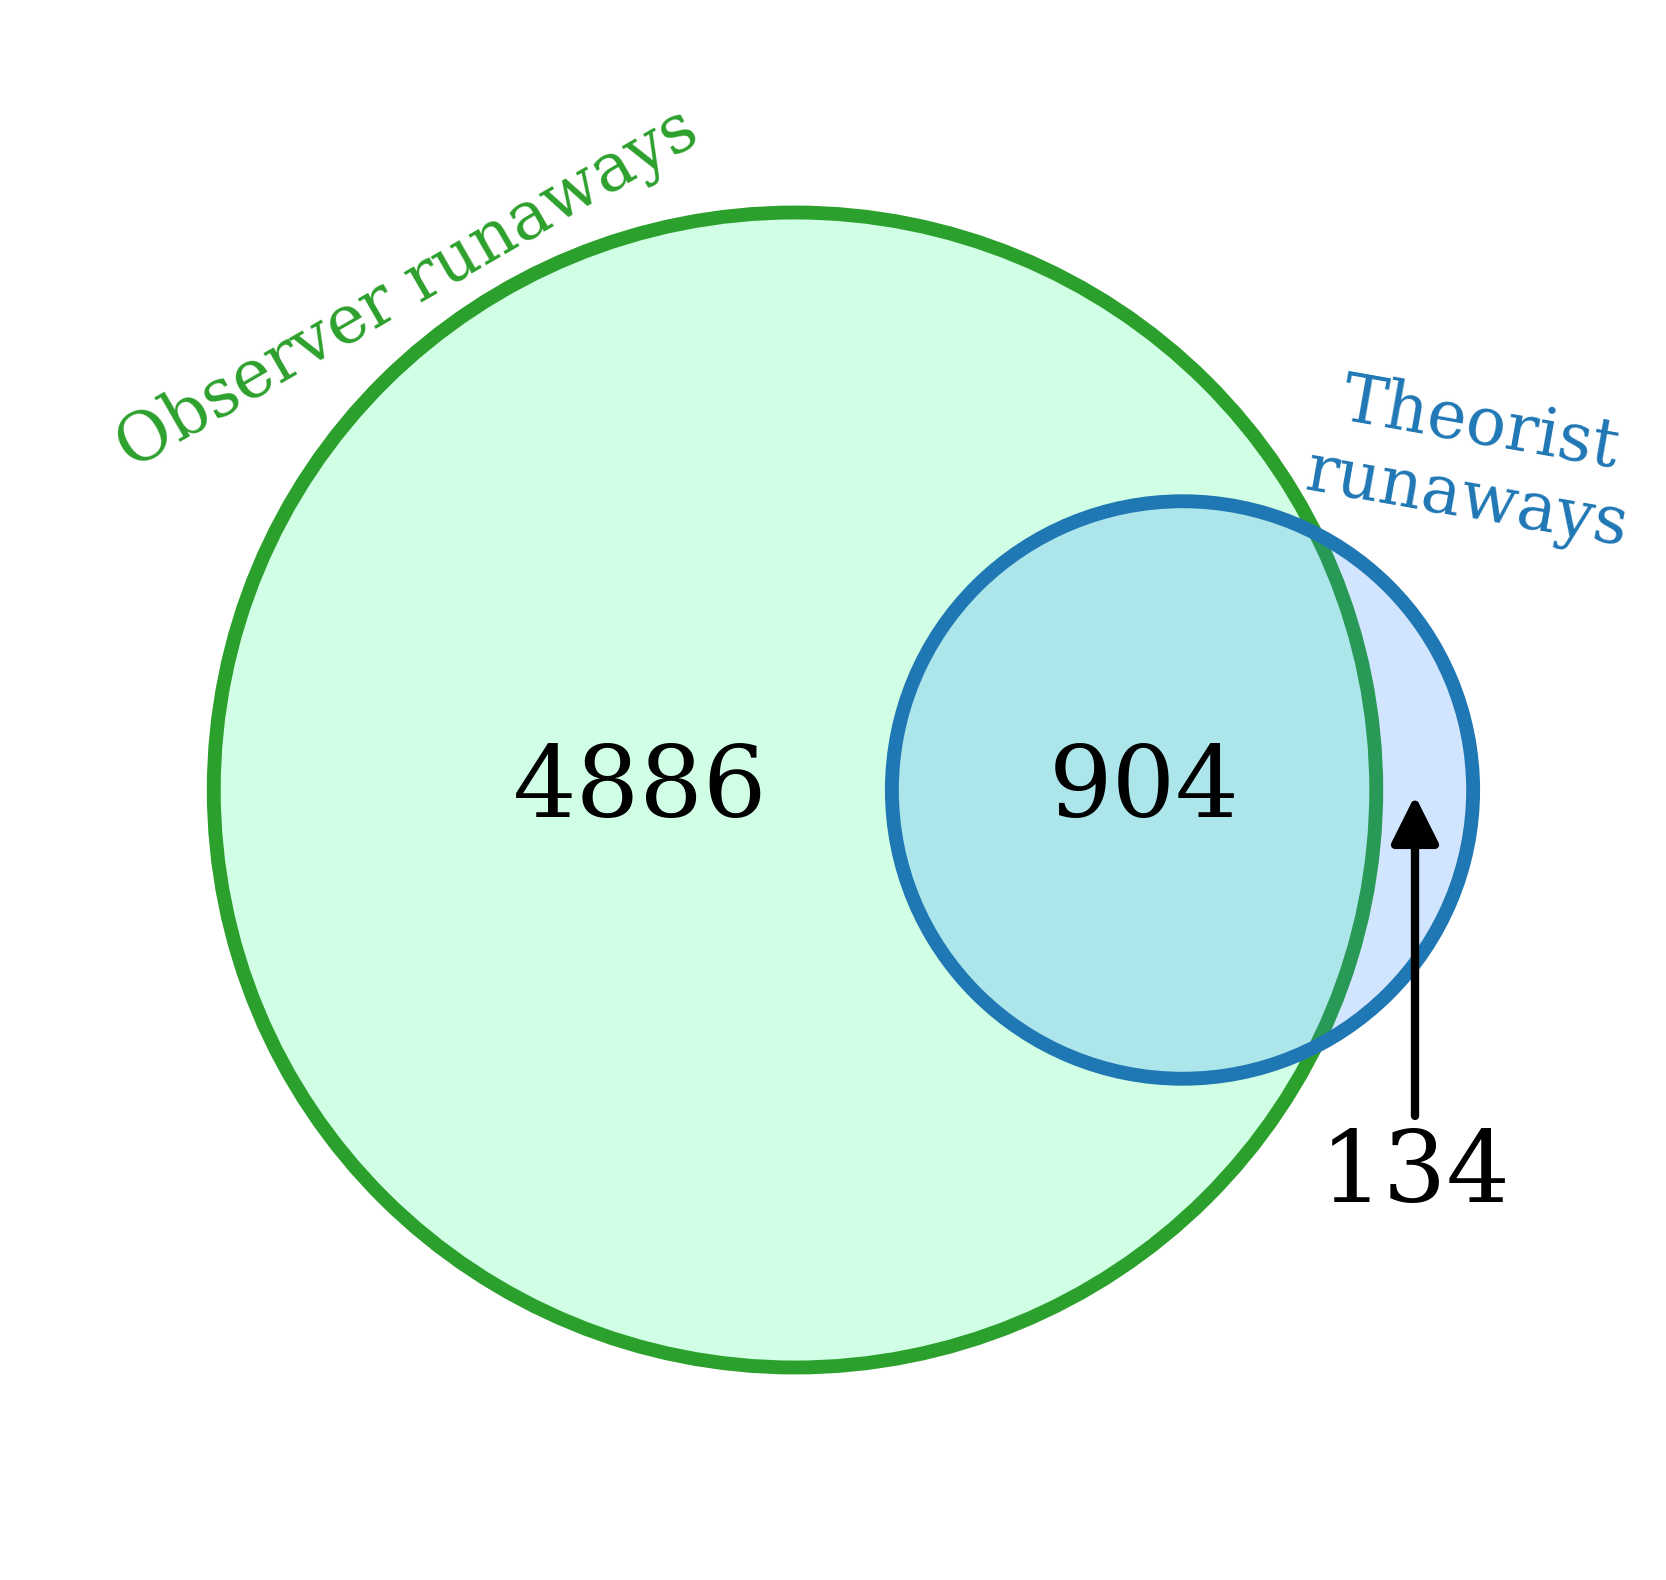

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

circles = [
    mpl.patches.Circle((0,0), 15, facecolor=(.1, 1, .5, 0.2), edgecolor="tab:green", linewidth=5),
    mpl.patches.Circle((10,0), 15/2, facecolor=(.1, .5, 1, 0.2), edgecolor="tab:blue", linewidth=5)
]

ax.annotate(f"Observer runaways", xy=(-10, 13), ha="center", va="center", fontsize=fs, color="tab:green", rotation=30)
ax.annotate(f"Theorist\nrunaways", xy=(17.5, 8.5), ha="center", va="center", fontsize=fs, color="tab:blue", rotation=-10)

intersect_count = len(np.intersect1d(theorist_still_hot, observer_runaway_pop.bin_nums))

ax.annotate(f"{len(observer_runaway_pop) - intersect_count}", xy=(-4, 0), ha="center", va="center", fontsize=1.5 * fs)
ax.annotate(f"{intersect_count}", xy=(9, 0), ha="center", va="center", fontsize=1.5 * fs)
ax.annotate(f"{len(theorist_still_hot) - intersect_count}", xy=(16, 0), xytext=(16, -10),
            ha="center", va="center", fontsize=1.5 * fs, arrowprops=dict(arrowstyle="-|>", lw=3, color="black"))

for c in circles:
    ax.add_artist(c)

ax.set(xlim=(-20, 20), ylim=(-20, 20))
ax.axis("off")
plt.show()

# Distributions of different pops

## Velocities

In [25]:
both_nums = np.intersect1d(theorist_still_hot, observer_runaway_pop.bin_nums)

In [26]:
just_theorist = np.setdiff1d(theorist_still_hot, both_nums)
just_obs = np.setdiff1d(observer_runaway_pop.bin_nums, both_nums)

In [27]:
just_theorist_pop = p[just_theorist]

In [28]:
just_obs_pop = p[just_obs]

### Theorist plot

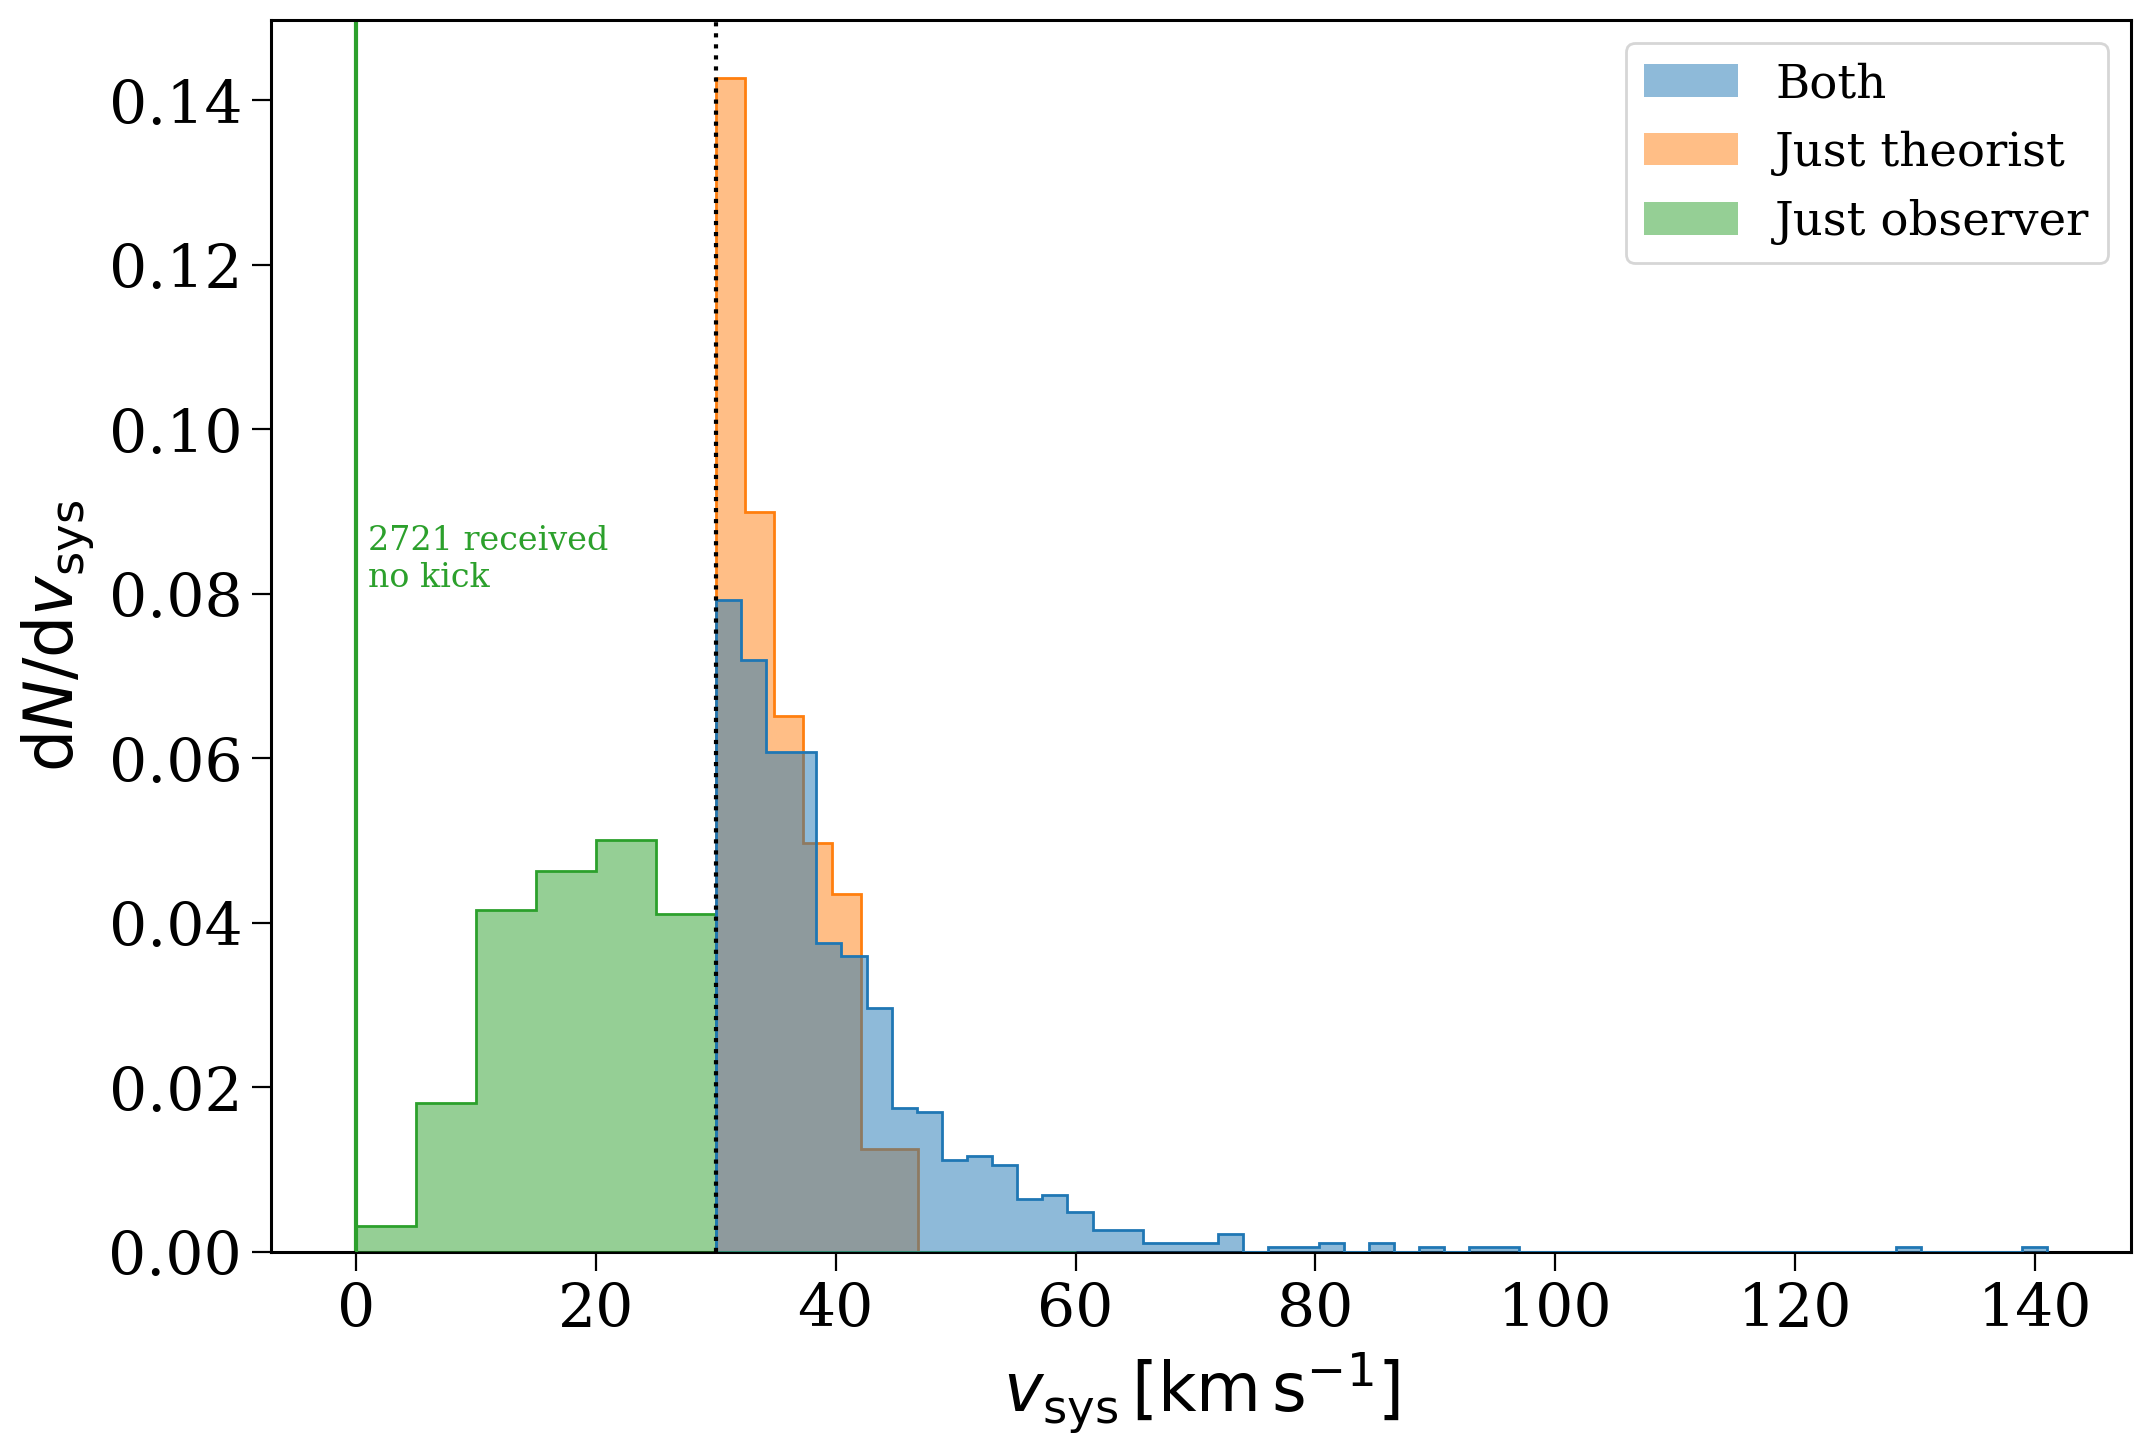

In [315]:
fig, ax = plt.subplots()

for nums, label, zorder, bins, c in zip([both_nums, just_theorist, just_obs], 
                                        ["Both", "Just theorist", "Just observer"],
                                        [10, 5, 5],
                                        ["fd", "fd", np.concatenate((np.arange(0.0, 30 + 5, 5), np.arange(31, 60 + 1, 1)))],
                                        ["C0", "C1", "C2"]):
    kicks = p.kick_info.loc[nums].drop_duplicates(subset="bin_num", keep="first")
    mag = kicks["natal_kick"].values
    v_sys = kicks["vsys_1_total"].values
    v_sys[kicks["disrupted"] == 1] = kicks["vsys_2_total"][kicks["disrupted"] == 1].values
    
    n_no_kick = (v_sys == 0).sum()
    
    v_sys = v_sys[v_sys != 0]
    ax.hist(v_sys, label=label, zorder=zorder, bins=bins, alpha=0.5, density=True, color=c)
    ax.hist(v_sys, histtype="step", zorder=zorder, bins=bins, density=True, color=c)

if n_no_kick > 0:
    ax.axvline(0.0, color="C2")
    ax.annotate(f'{n_no_kick} received\nno kick', xy=(1, 0.08), ha="left", va="bottom", color="C2", fontsize=0.5* fs)
    
ax.legend(fontsize=0.7*fs)

ax.axvline(30, color="black", linestyle="dotted", zorder=100)

ax.set(xlabel=r"$v_{\rm sys} \, [\rm km \, s^{-1}]$", ylabel=r"$\mathrm{d}N/\mathrm{d}v_{\rm sys}$")

plt.show()

### Observer plot

In [295]:
v_circ = p.galactic_potential.circular_velocity(p.final_pos.T)

In [296]:
rel_vel = np.linalg.norm([p.final_vel[:, 0], p.final_vel[:, 1] - v_circ, p.final_vel[:, 2]], axis=0)

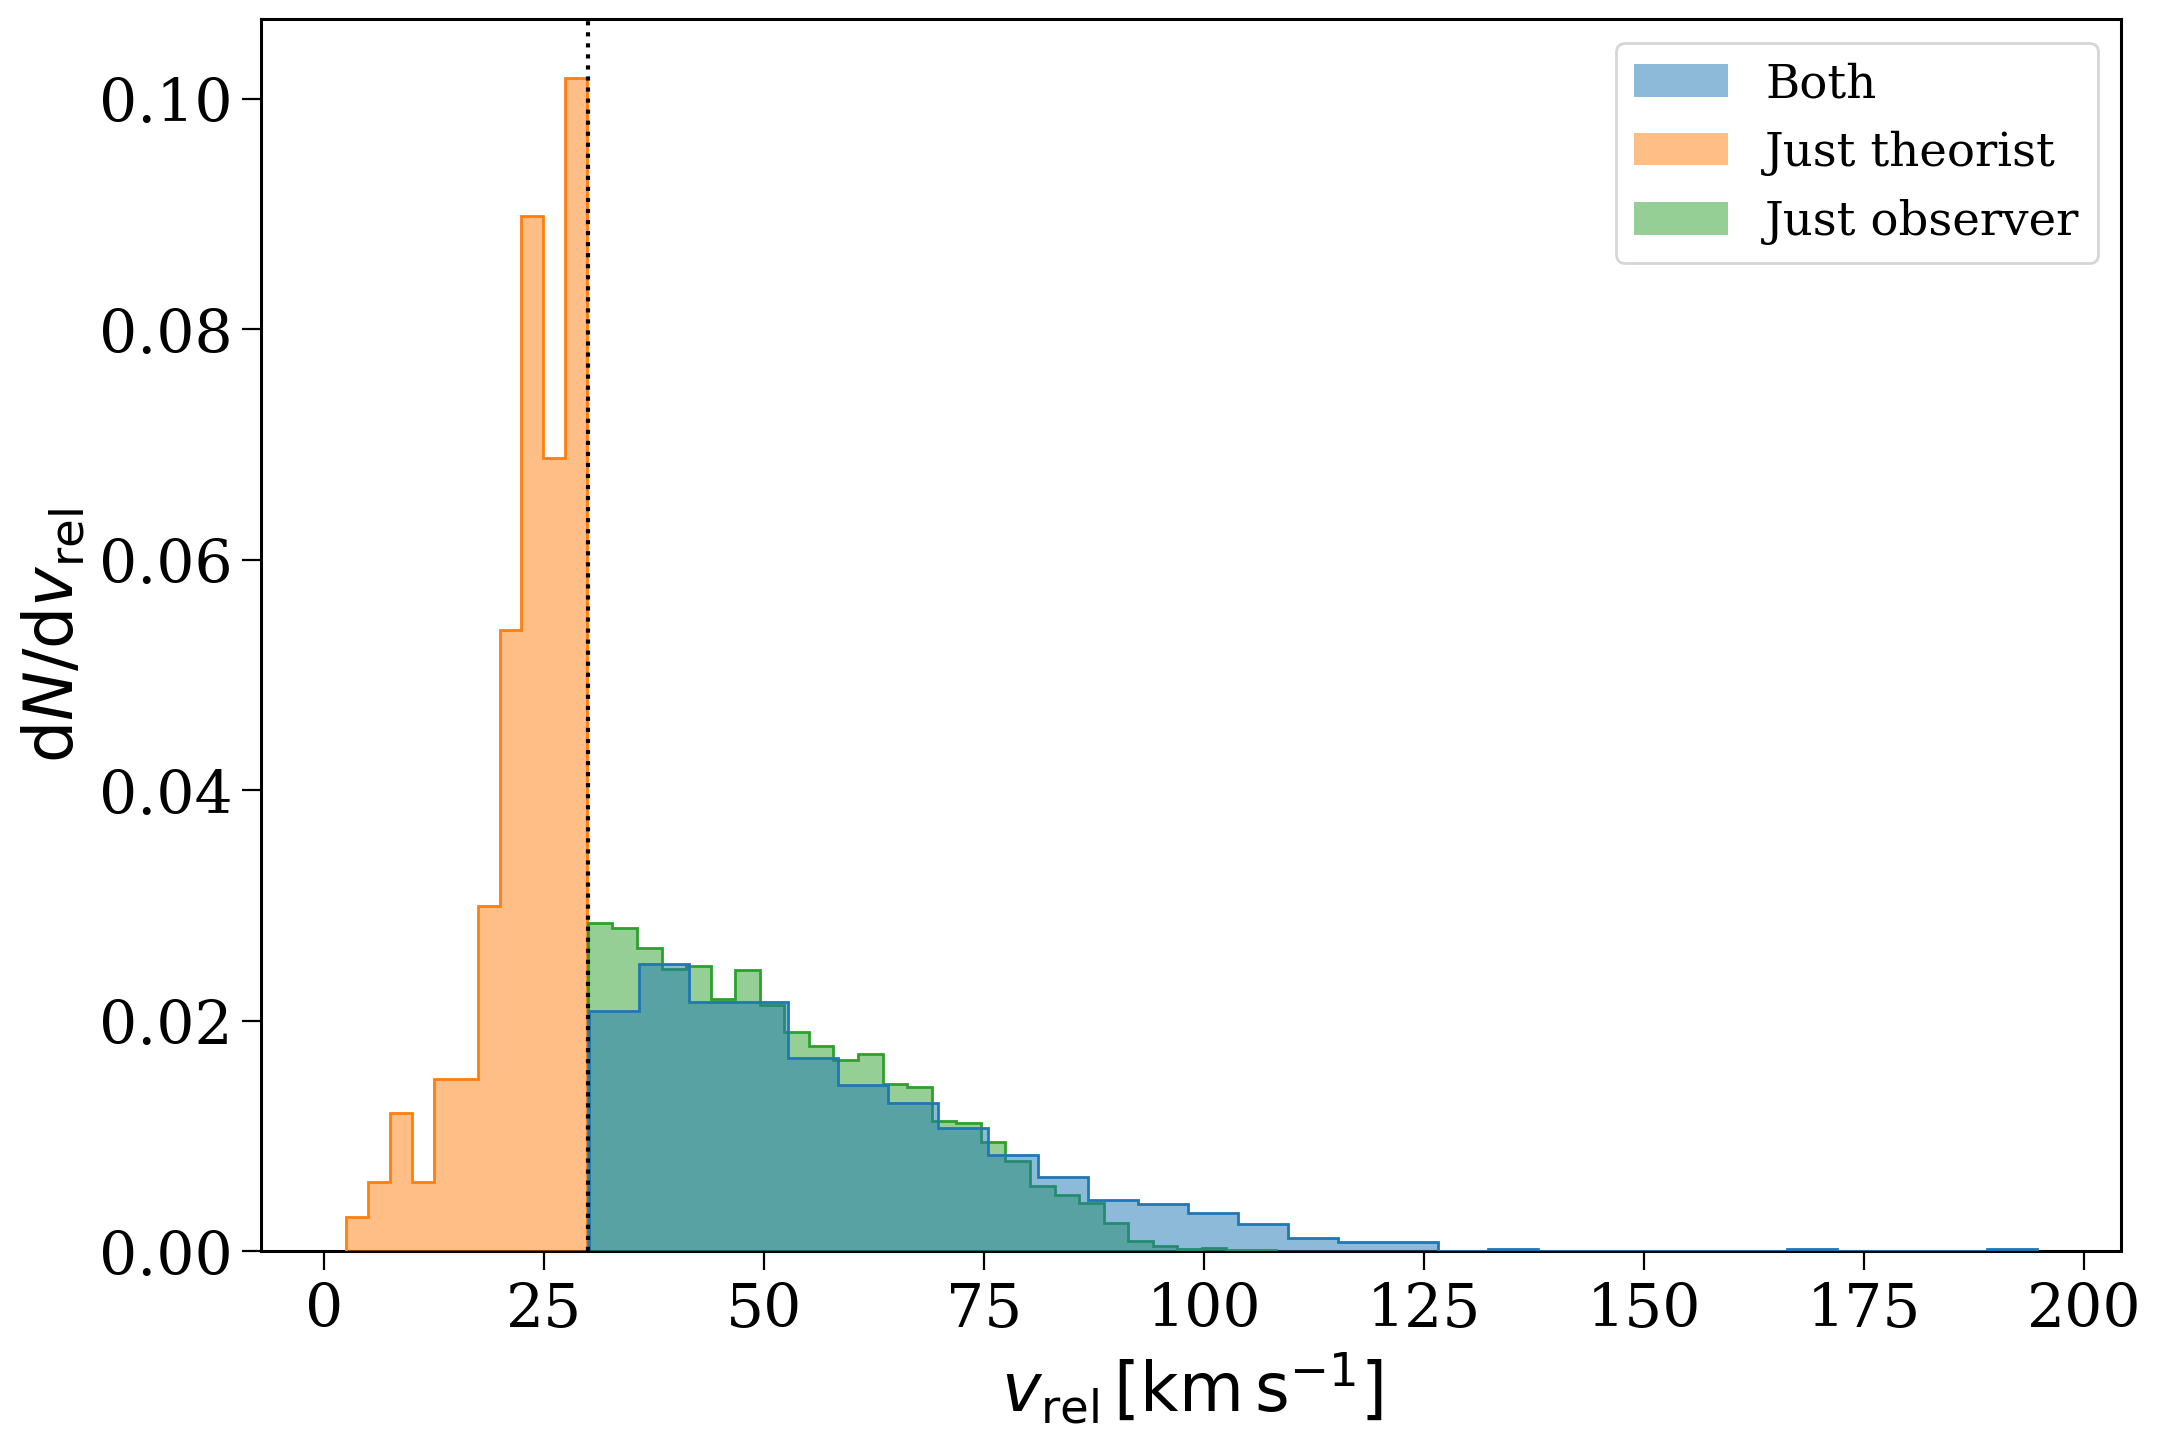

In [298]:
fig, ax = plt.subplots()

for nums, label, zorder, bins, c in zip([both_nums, just_theorist, just_obs], 
                                        ["Both", "Just theorist", "Just observer"],
                                        [10, 5, 5],
                                        ["fd", "fd", "fd"],
                                        ["C0", "C1", "C2"]):
    final_bpp = p.final_bpp.loc[nums]
    disrupted = final_bpp["sep"] < 0
    
    vels = np.concatenate((rel_vel[len(p):][np.isin(p.bin_nums[p.disrupted], nums[disrupted])],
                           rel_vel[:len(p):][np.isin(p.bin_nums, nums[~disrupted])]))

    ax.hist(vels, label=label, zorder=zorder, bins=bins, alpha=0.5, density=True, color=c)
    ax.hist(vels, histtype="step", zorder=zorder, bins=bins, density=True, color=c)
    
ax.legend(fontsize=0.7*fs)

ax.axvline(30, color="black", linestyle="dotted", zorder=100)

ax.set(xlabel=r"$v_{\rm rel} \, [\rm km \, s^{-1}]$", ylabel=r"$\mathrm{d}N/\mathrm{d}v_{\rm rel}$")

plt.show()

## Positions

In [116]:
hot_theorists = p[theorist_still_hot]

In [117]:
ht_pos = np.concatenate((hot_theorists.final_pos[:len(hot_theorists)][~hot_theorists.disrupted],
                         hot_theorists.final_pos[len(hot_theorists):]))

In [118]:
ht_nums = np.concatenate((hot_theorists.bin_nums[~hot_theorists.disrupted],
                          hot_theorists.bin_nums[hot_theorists.disrupted]))

In [119]:
ht_init_pos = hot_theorists.initial_galaxy.positions[:, np.argsort(ht_nums)].T

In [120]:
np.sum(ht_init_pos[:, :2]**2, axis=1)**(0.5)

<Quantity [9.92861843, 9.45809787, 9.79478199, ..., 8.94230448, 8.7643015 ,
           8.39326546] kpc>

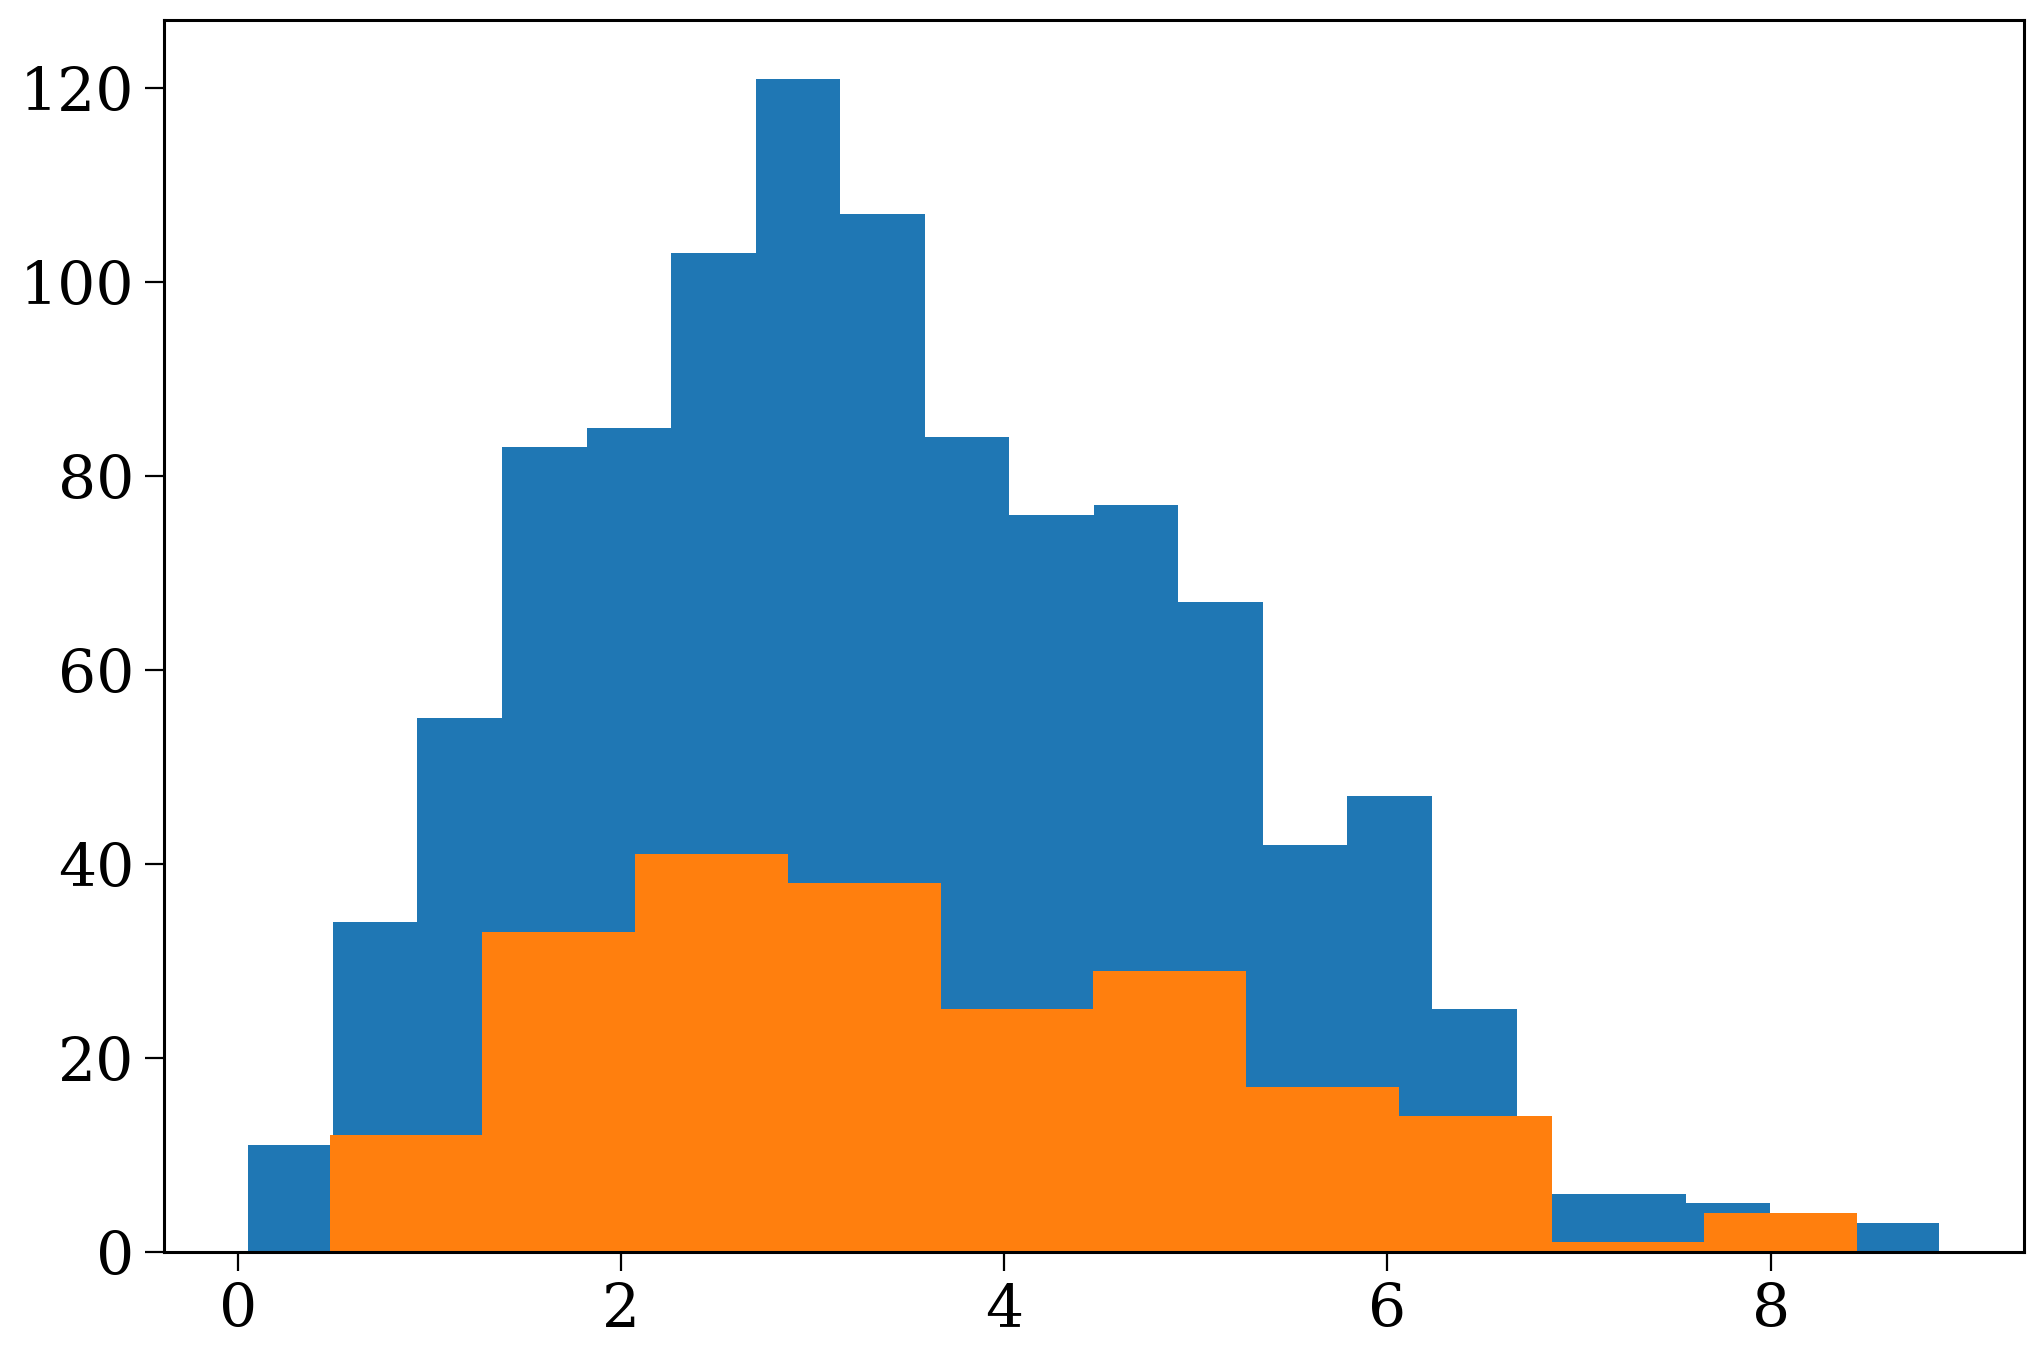

In [121]:
plt.hist(np.sum((ht_init_pos - ht_pos)**2, axis=1)**(.5), bins="fd")
plt.hist((np.sum((ht_init_pos - ht_pos)**2, axis=1)**(.5))[~np.isin(ht_nums, just_theorist)], bins="fd");

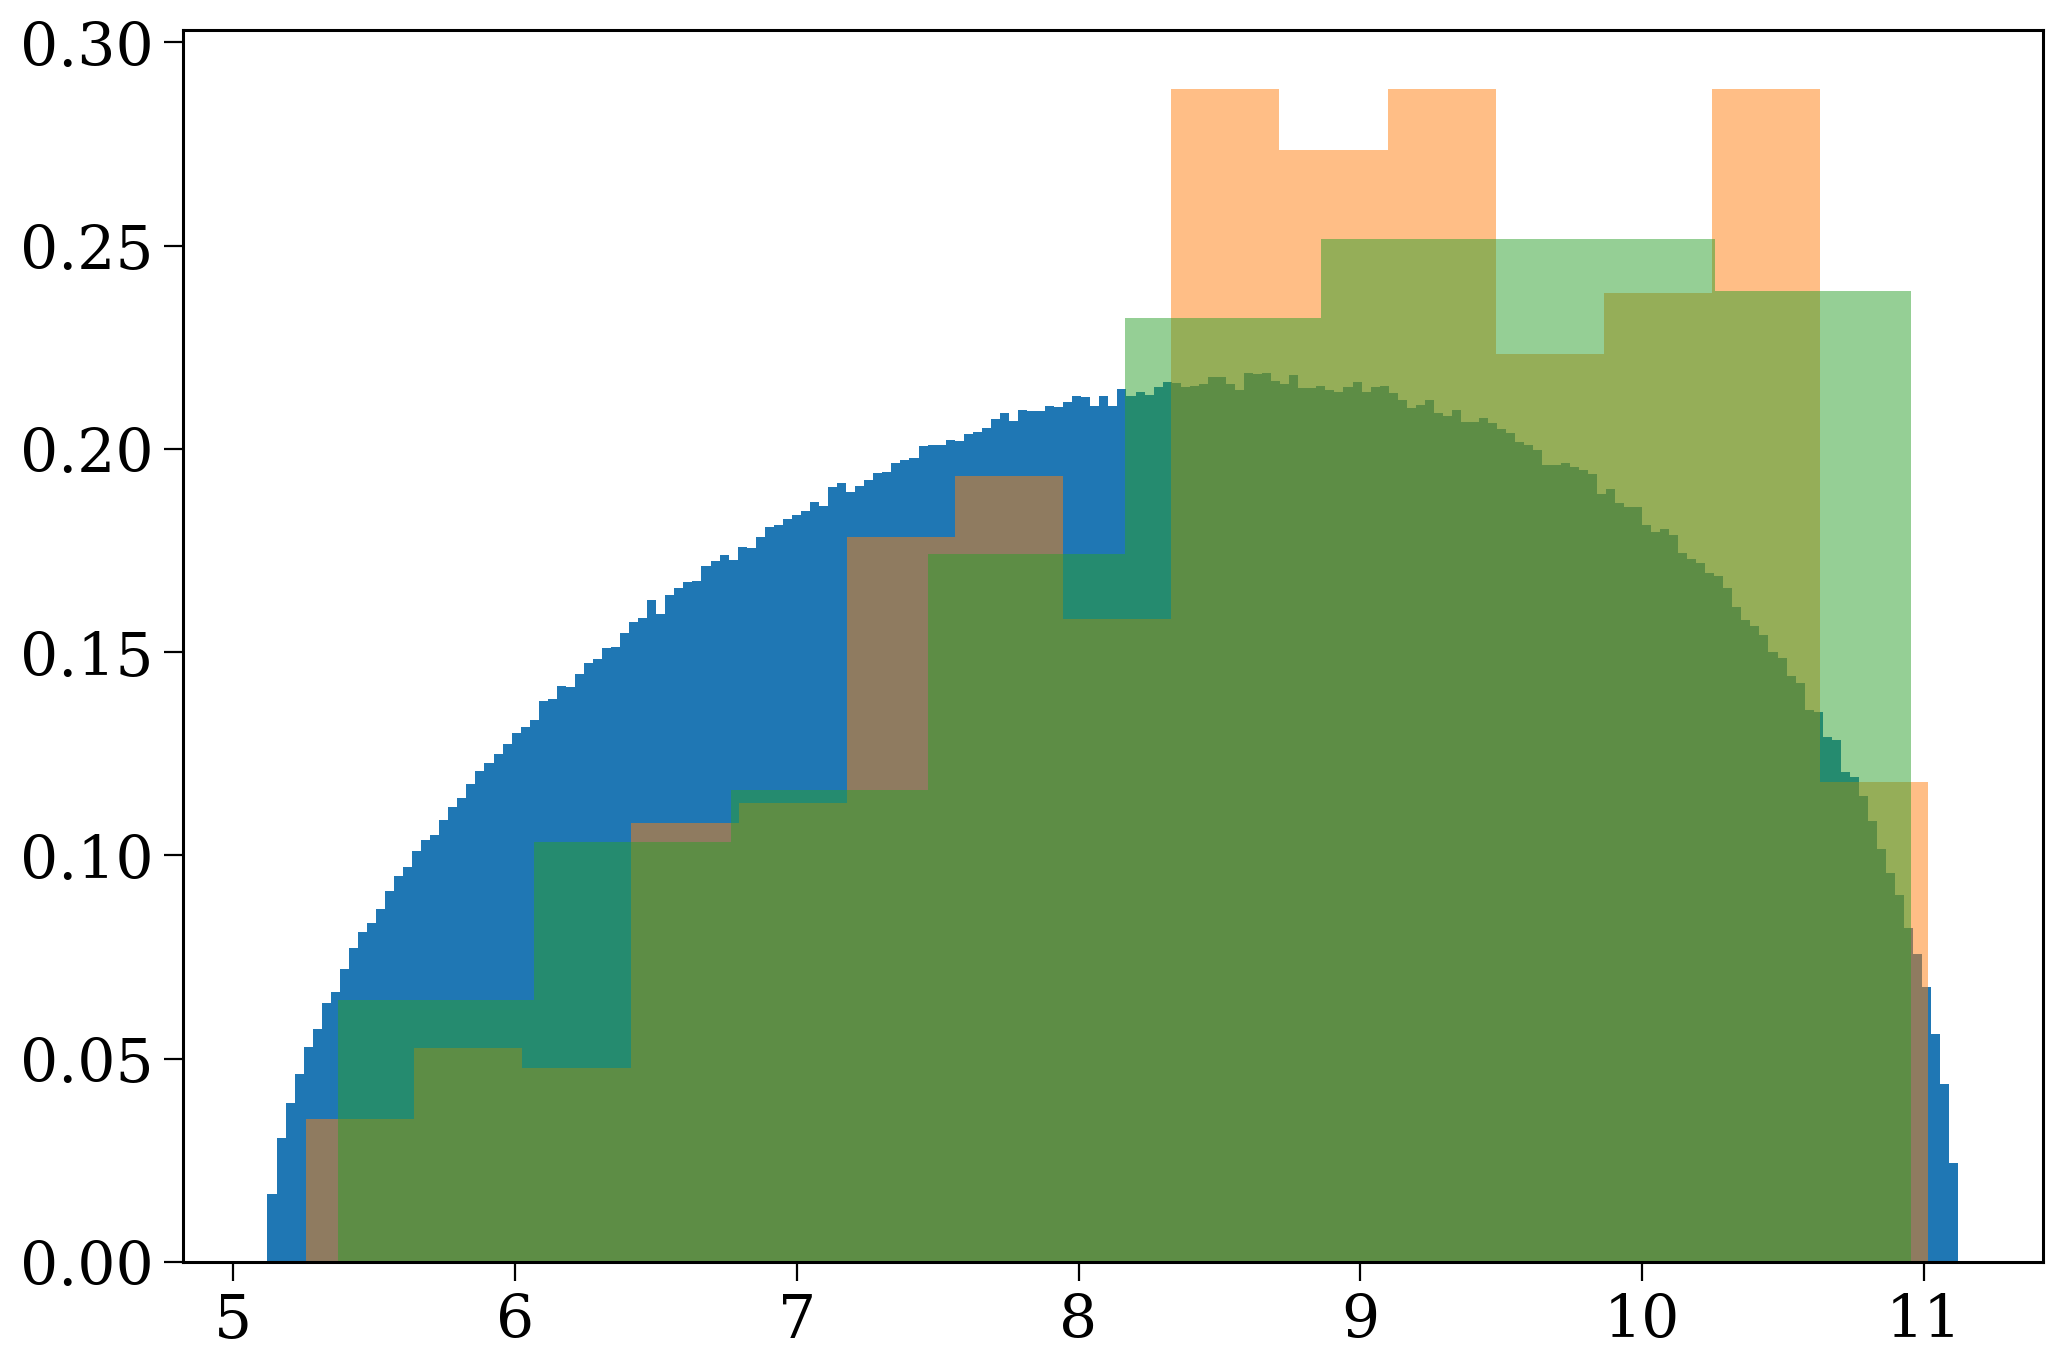

In [122]:
plt.hist(p.initial_galaxy.rho, bins="fd", density=True);
plt.hist(hot_theorists.initial_galaxy.rho, bins="fd", density=True, alpha=0.5);
plt.hist(observer_runaway_pop.initial_galaxy.rho, bins="fd", density=True, alpha=0.5);

In [123]:
pd.read_hdf("slurm/bad_orbits.h5", key='bpp').drop_duplicates(subset="bin_num", keep="last")

tphys     mass_1     mass_2  kstar_1  kstar_2           sep  \
16739    51.254353   0.000000   1.324762     15.0     13.0      0.000000   
18040     4.160893  15.347715  41.488036     14.0      4.0  39848.764226   
20040    48.344928   0.000000   1.284621     15.0     13.0      0.000000   
26491    42.561771   1.277584   0.000000     13.0     15.0      0.000000   
33644    42.570628   0.000000   1.979672     15.0     13.0      0.000000   
...            ...        ...        ...      ...      ...           ...   
3292657  14.309067   1.620043   6.010916     13.0      1.0     -1.000000   
3298910  15.051129   1.499746  10.448325     13.0      1.0     -1.000000   
3301757  22.035694   1.277584   7.628439     13.0      1.0     -1.000000   
3303044  11.372754   1.287185  21.430763     13.0      1.0     -1.000000   
3308836   7.873637   2.161276  38.380116     13.0      1.0     -1.000000   

                  porb       ecc        RRLO_1    RRLO_2  evol_type  \
16739         0.000000 -1.000000 -1.000000e+00  0.000100       10.0   
18040    122287.944138  0.019944  5.610818e-09  0.115269       10.0   
20040         0.000000 -1.000000 -1.000000e+00  0.000100       10.0   
26491         0.000000 -1.000000  1.000000e-04 -1.000000       10.0   
33644         0.000000 -1.000000 -1.000000e+00  0.000100       10.0   
...                ...       ...           ...       ...        ...   
3292657      -1.000000 -1.000000  1.000000e-04  0.000100       10.0   
3298910      -1.000000 -1.000000  1.000000e-04  0.000100       10.0   
3301757      -1.000000 -1.000000  1.000000e-04  0.000100       10.0   
3303044      -1.000000 -1.000000  1.000000e-04  0.000100       10.0   
3308836      -1.000000 -1.000000  1.000000e-04  0.000100       10.0   

              aj_1       aj_2         tms_1         tms_2    massc_1  \
16739    10.687139   0.000243  3.198348e+01  1.000000e+10   0.000000   
18040     0.011894   4.370198  1.000000e+10  4.319625e+00  15.347715   
20040     7.827311   0.092720  1.000000e+10  1.000000e+10   0.000000   
26491     0.000732  38.759720  1.000000e+10  4.034210e+03   1.277584   
33644     7.418985   0.021337  6.970928e+00  1.000000e+10   0.000000   
...            ...        ...           ...           ...        ...   
3292657   0.029294  14.080554  1.000000e+10  6.810539e+01   1.620043   
3298910   0.041749  14.060384  1.000000e+10  2.195595e+01   1.499746   
3301757   0.015663  22.138858  1.000000e+10  3.970886e+01   1.277584   
3303044   0.059335   2.802785  1.000000e+10  7.625943e+00   1.287185   
3308836   0.114999   3.377982  1.000000e+10  5.016391e+00   2.161276   

           massc_2     rad_1        rad_2    mass0_1    mass0_2         lum_1  \
16739     1.324762  0.204127     0.000014   0.844208  12.395026  1.677547e+02   
18040    19.143399  0.000065  2101.503624  15.987690  48.907515  1.000000e-10   
20040     1.284621  0.007326     0.000014   1.064327  12.125319  2.303191e-01   
26491     0.000000  0.000014     1.328831   8.715202   1.343115  2.356735e+00   
33644     1.979672  1.125518     0.000014   1.634784  15.958738  7.408290e+03   
...            ...       ...          ...        ...        ...           ...   
3292657   0.000000  0.000014     3.231032  14.585040   6.010916  2.763203e+00   
3298910   0.000000  0.000014     6.269876  13.727286  10.448325  2.623988e+00   
3301757   0.000000  0.000014     5.003652  10.630427   7.628439  2.356735e+00   
3303044   0.000000  0.000014     8.177539   3.716556  21.430763  2.368588e+00   
3308836   0.000000  0.000014    14.679380   6.191970  38.380116  2.534549e+00   

                 lum_2        teff_1        teff_2    radc_1    radc_2  \
16739         2.414695  4.618362e+04  1.931618e+06  0.000000  0.000014   
18040    814266.881892  2.272819e+03  3.799236e+03  0.000065  1.410029   
20040         2.365425  4.692750e+04  1.921688e+06  0.007326  0.000014   
26491         2.631833  1.919921e+06  6.406183e+03  0.000014  0.000000   
33644         3.160440  5.070175e+04  2

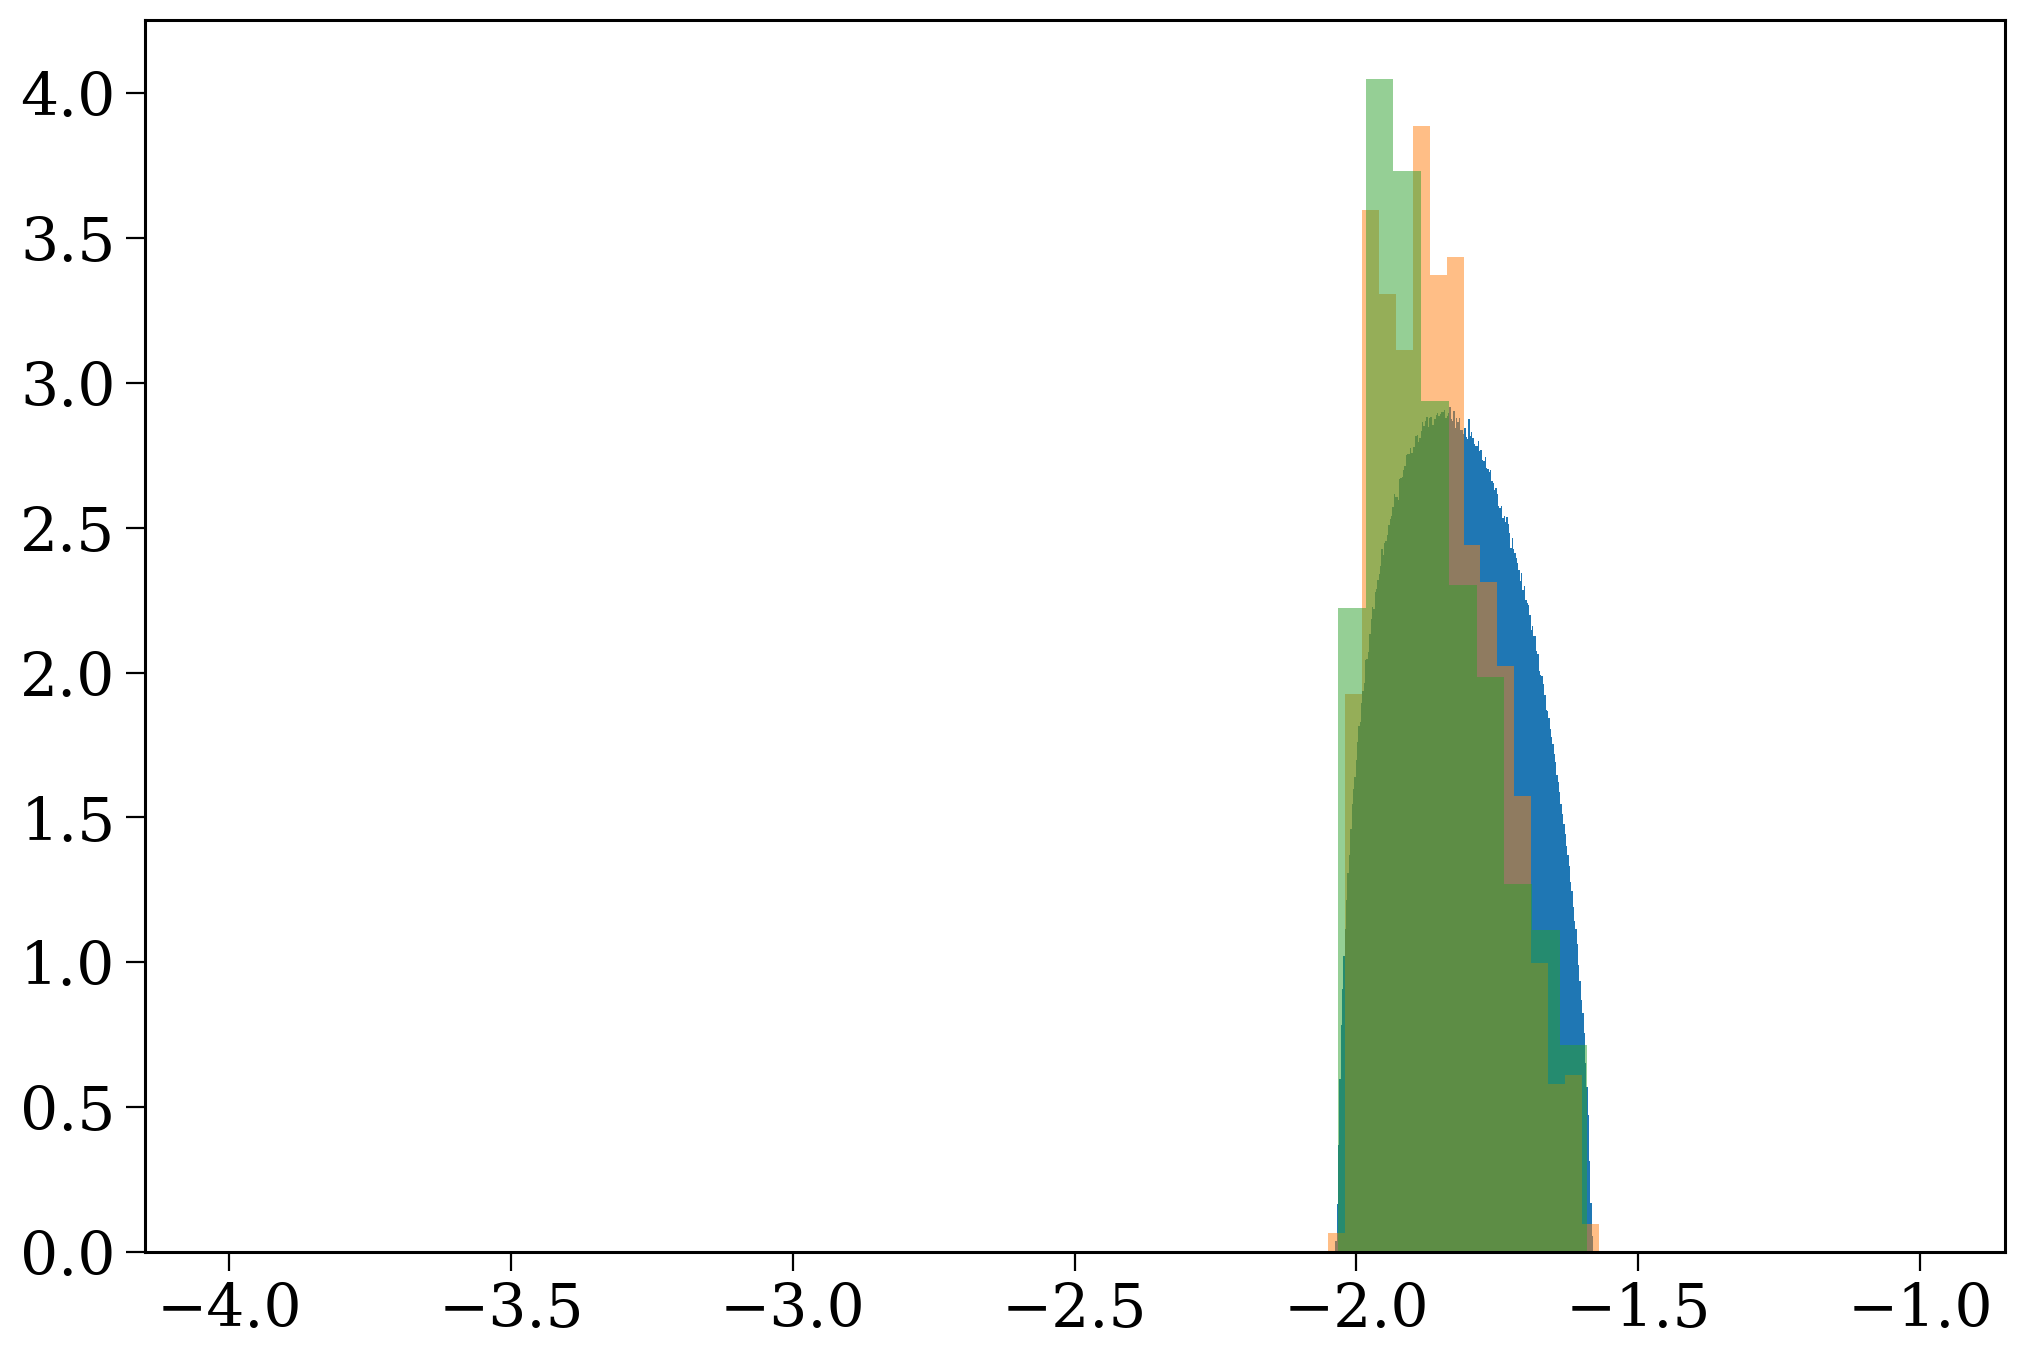

In [35]:
plt.hist(np.log10(p.initial_galaxy.Z), bins="fd", density=True, range=(-4, -1));
plt.hist(np.log10(hot_theorists.initial_galaxy.Z), bins="fd", density=True, alpha=0.5, range=(-4, -1));
plt.hist(np.log10(observer_runaway_pop.initial_galaxy.Z), bins="fd", density=True, alpha=0.5, range=(-4, -1));

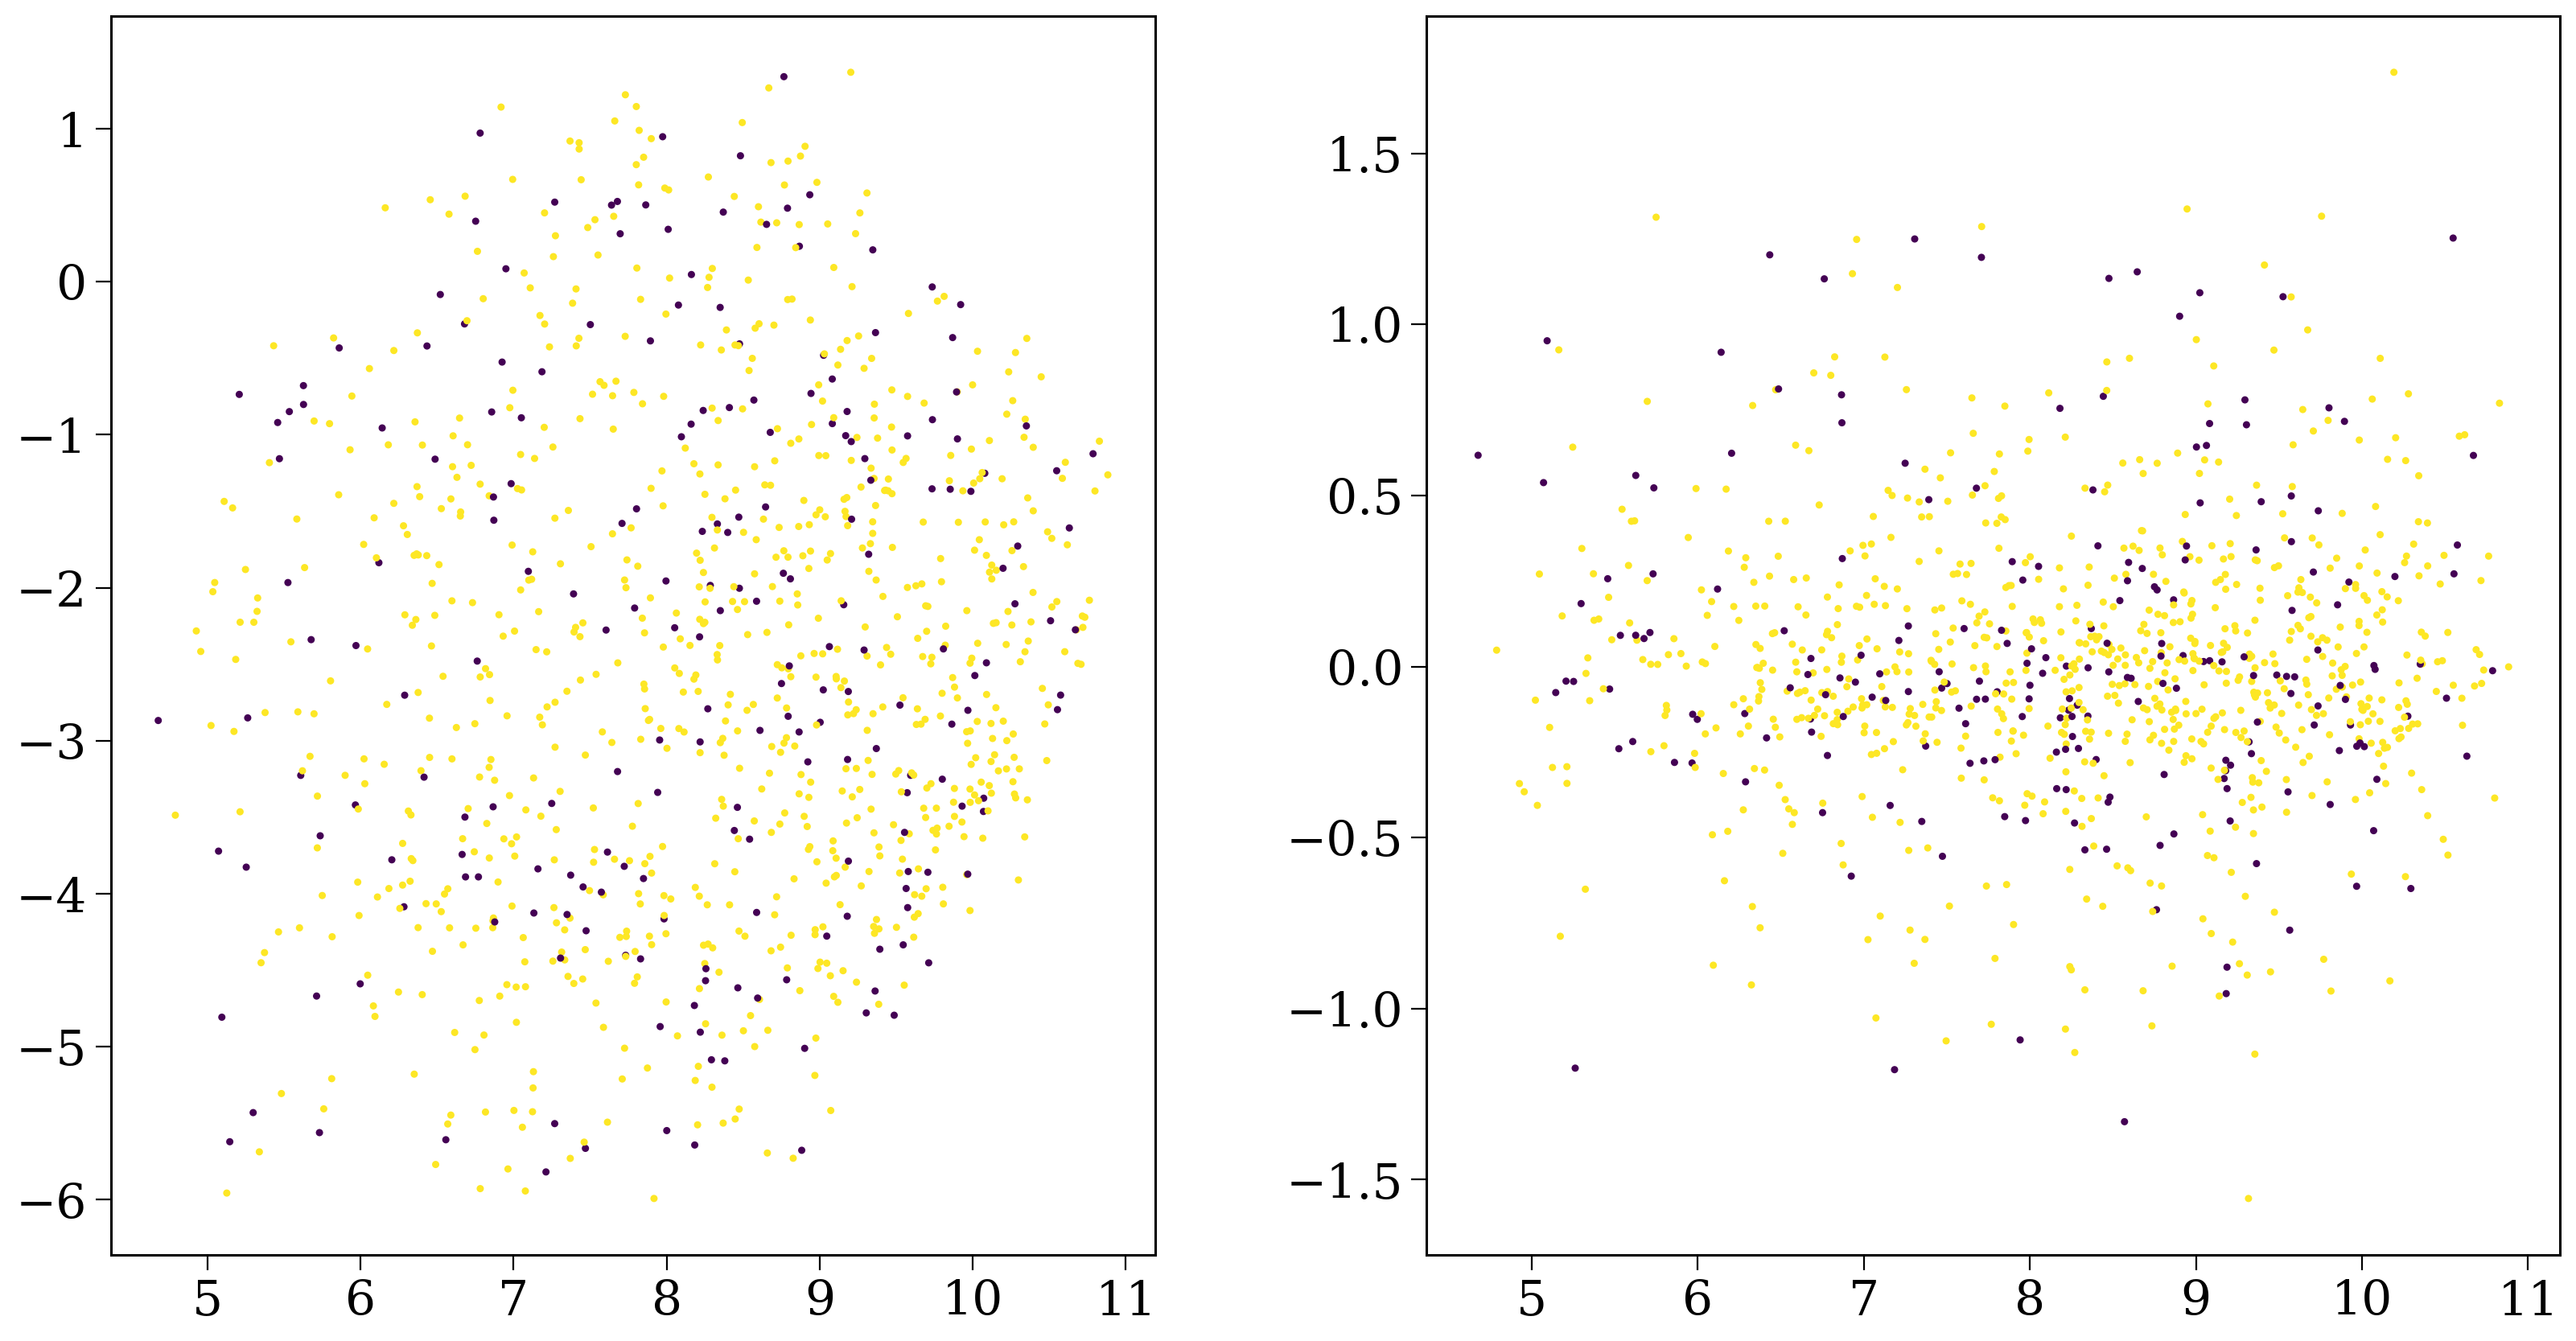

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(ht_init_pos[:, 0], ht_init_pos[:, 1], s=5, c=np.isin(ht_nums, just_theorist))
axes[1].scatter(ht_init_pos[:, 0], ht_init_pos[:, 2], s=5, c=np.isin(ht_nums, just_theorist))

for ax in axes:
    axes[0].set_aspect("equal")

plt.show()

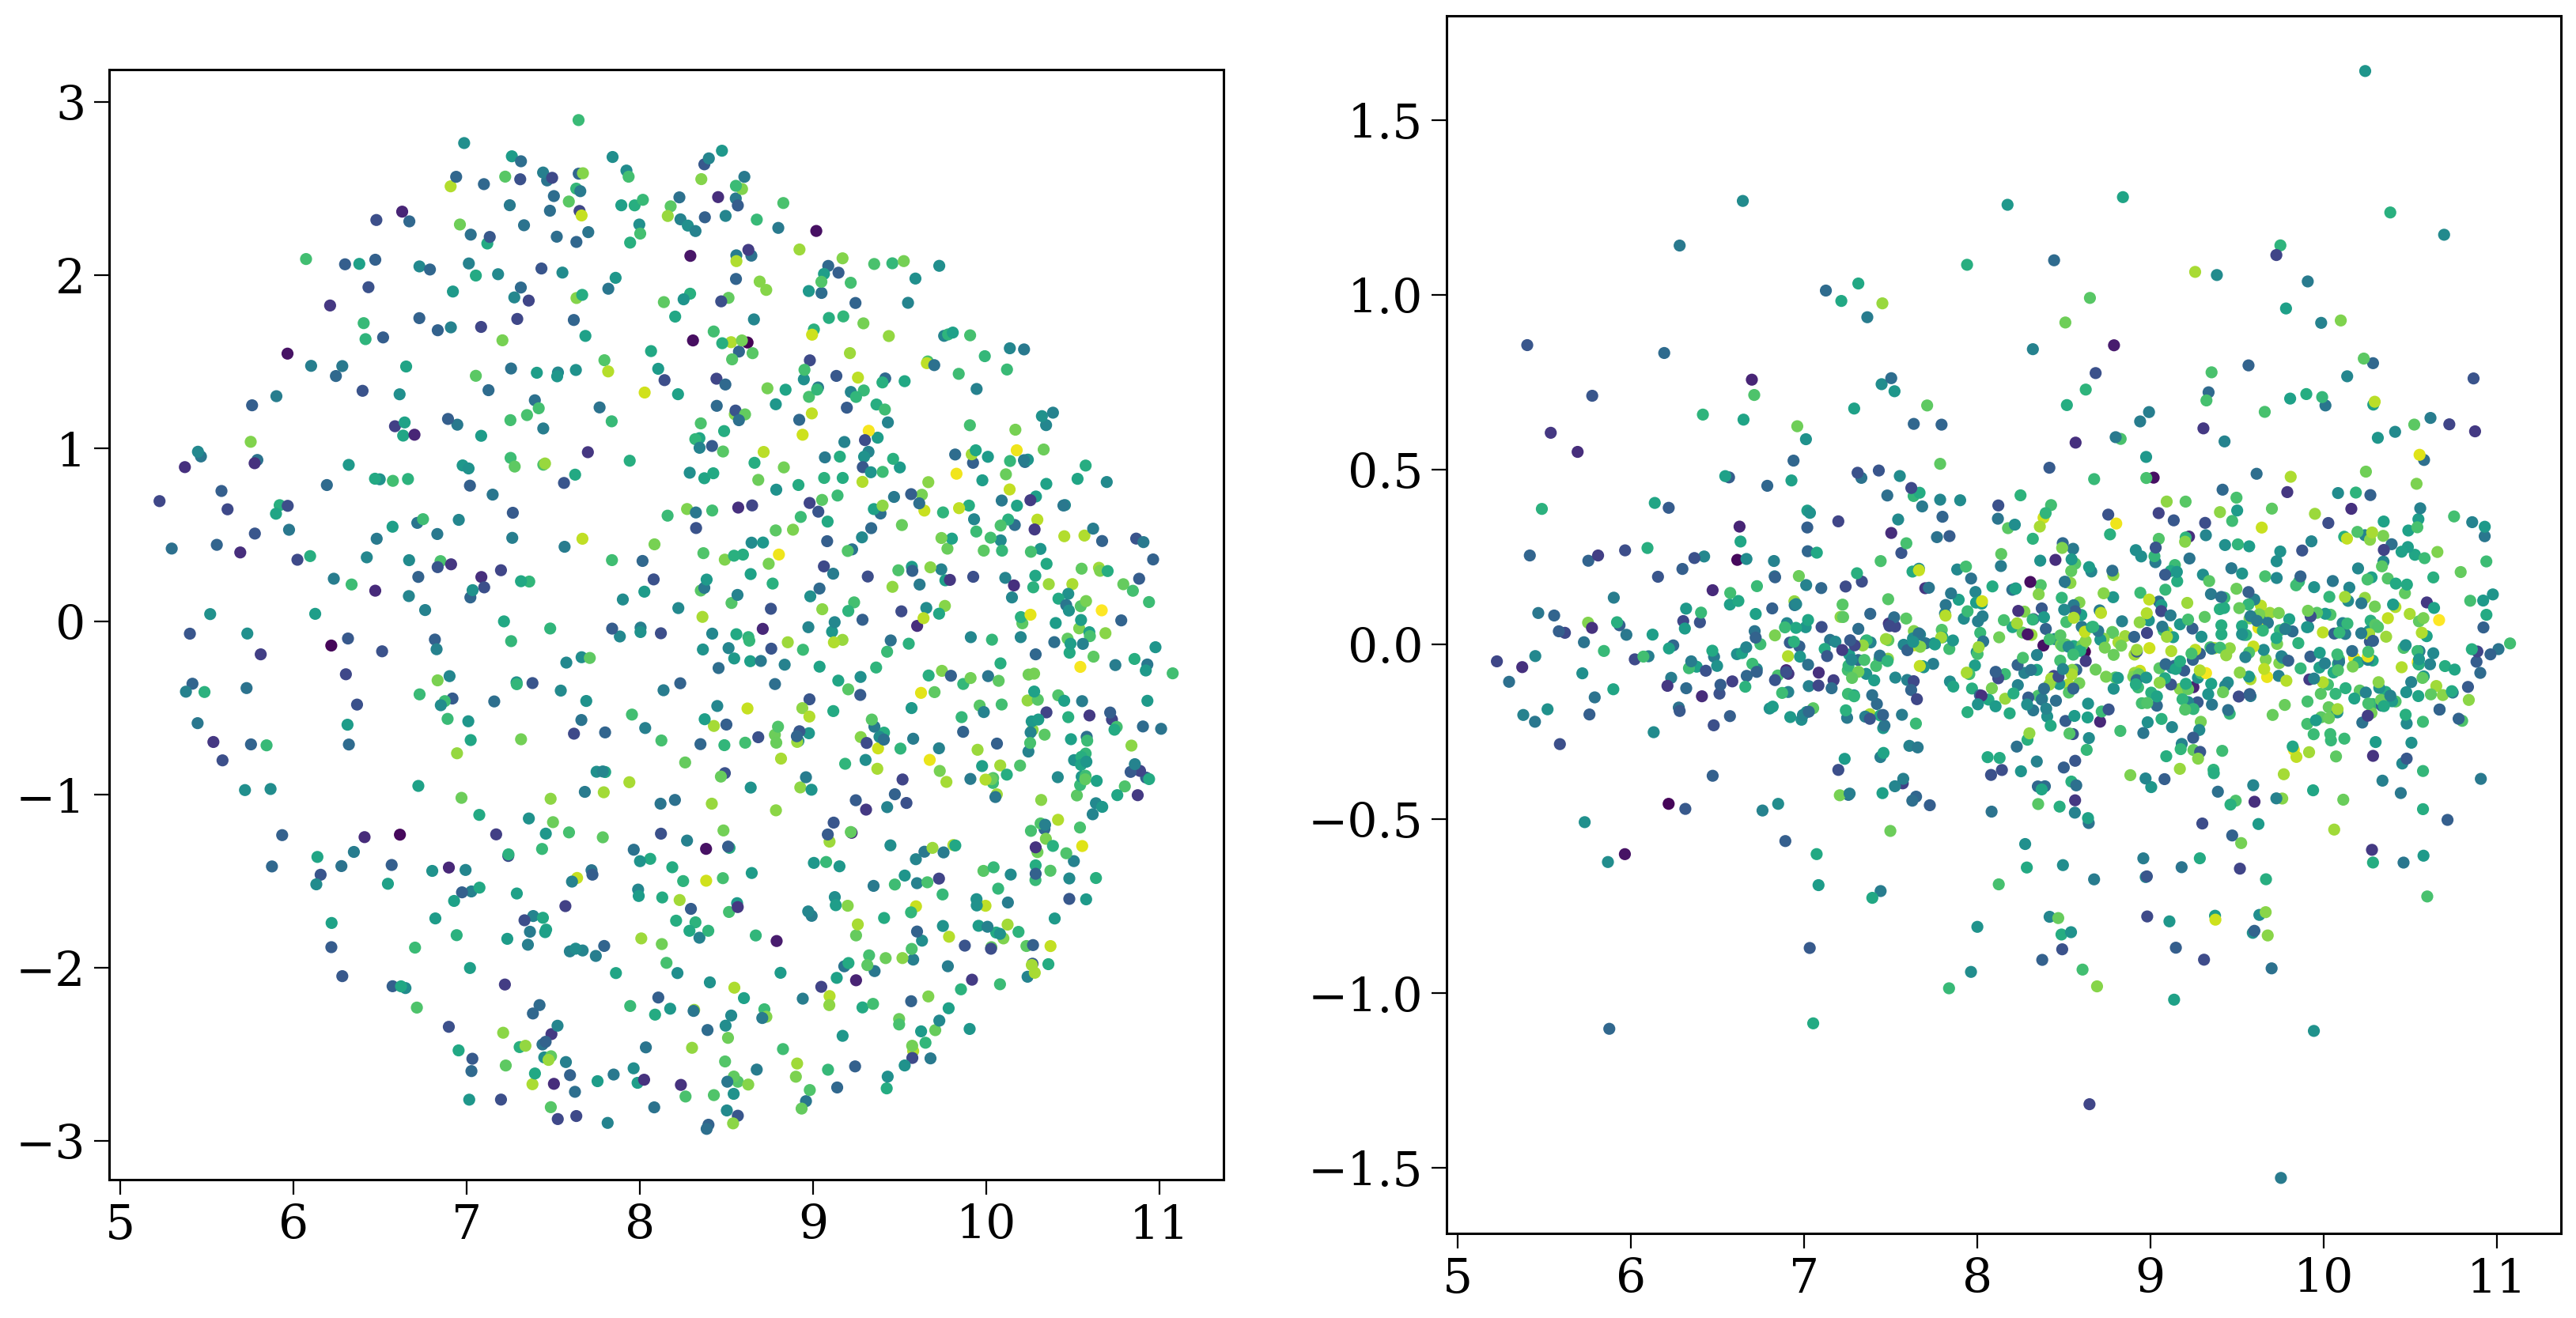

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(ht_pos[:, 0], ht_pos[:, 1], s=20, c=np.log10(hot_theorists.final_bpp["tphys"].loc[ht_nums]))
axes[1].scatter(ht_pos[:, 0], ht_pos[:, 2], s=20, c=np.log10(hot_theorists.final_bpp["tphys"].loc[ht_nums]))

for ax in axes:
    axes[0].set_aspect("equal")

plt.show()

## TODO: Relative galactocentric radius

In [130]:
def get_radius_difference(p):
    print(p.disrupted.sum() / len(p))
    
    initial_r = ((p.initial_galaxy.x**2 + p.initial_galaxy.y**2)**(0.5))[p.disrupted]
    final_r = np.linalg.norm(p.final_pos[len(p):, :2], axis=1)
    return initial_r, final_r

In [154]:
just_theorist_pop.store_entire_orbits = True

In [193]:
just_theorist_pop.orbits[len(just_theorist_pop)].vel.d_xyz.to(u.km/u.s)[:, 72:76]

<Quantity [[ 18.99245033,  -1.75276349,  -2.37003481,  -2.98771693],
           [224.62962804, 230.33549863, 230.38871531, 230.44023776],
           [  2.01918556,  31.19842516,  31.27568925,  31.35240248]] km / s>

In [206]:
rel_vel[np.concatenate((p.bin_nums, p.bin_nums[p.disrupted])) == 2260]

<Quantity [380.21855916,   6.19005563] km / s>

In [201]:
rel_vel

<Quantity [ 80.08103874, 213.54561281,   1.30912197, ...,   2.21787366,
            11.73341008, 292.95517695] km / s>

In [ ]:
np.abs(np.sum(p.final_vel**2, axis=1)**(0.5) - v_circ)

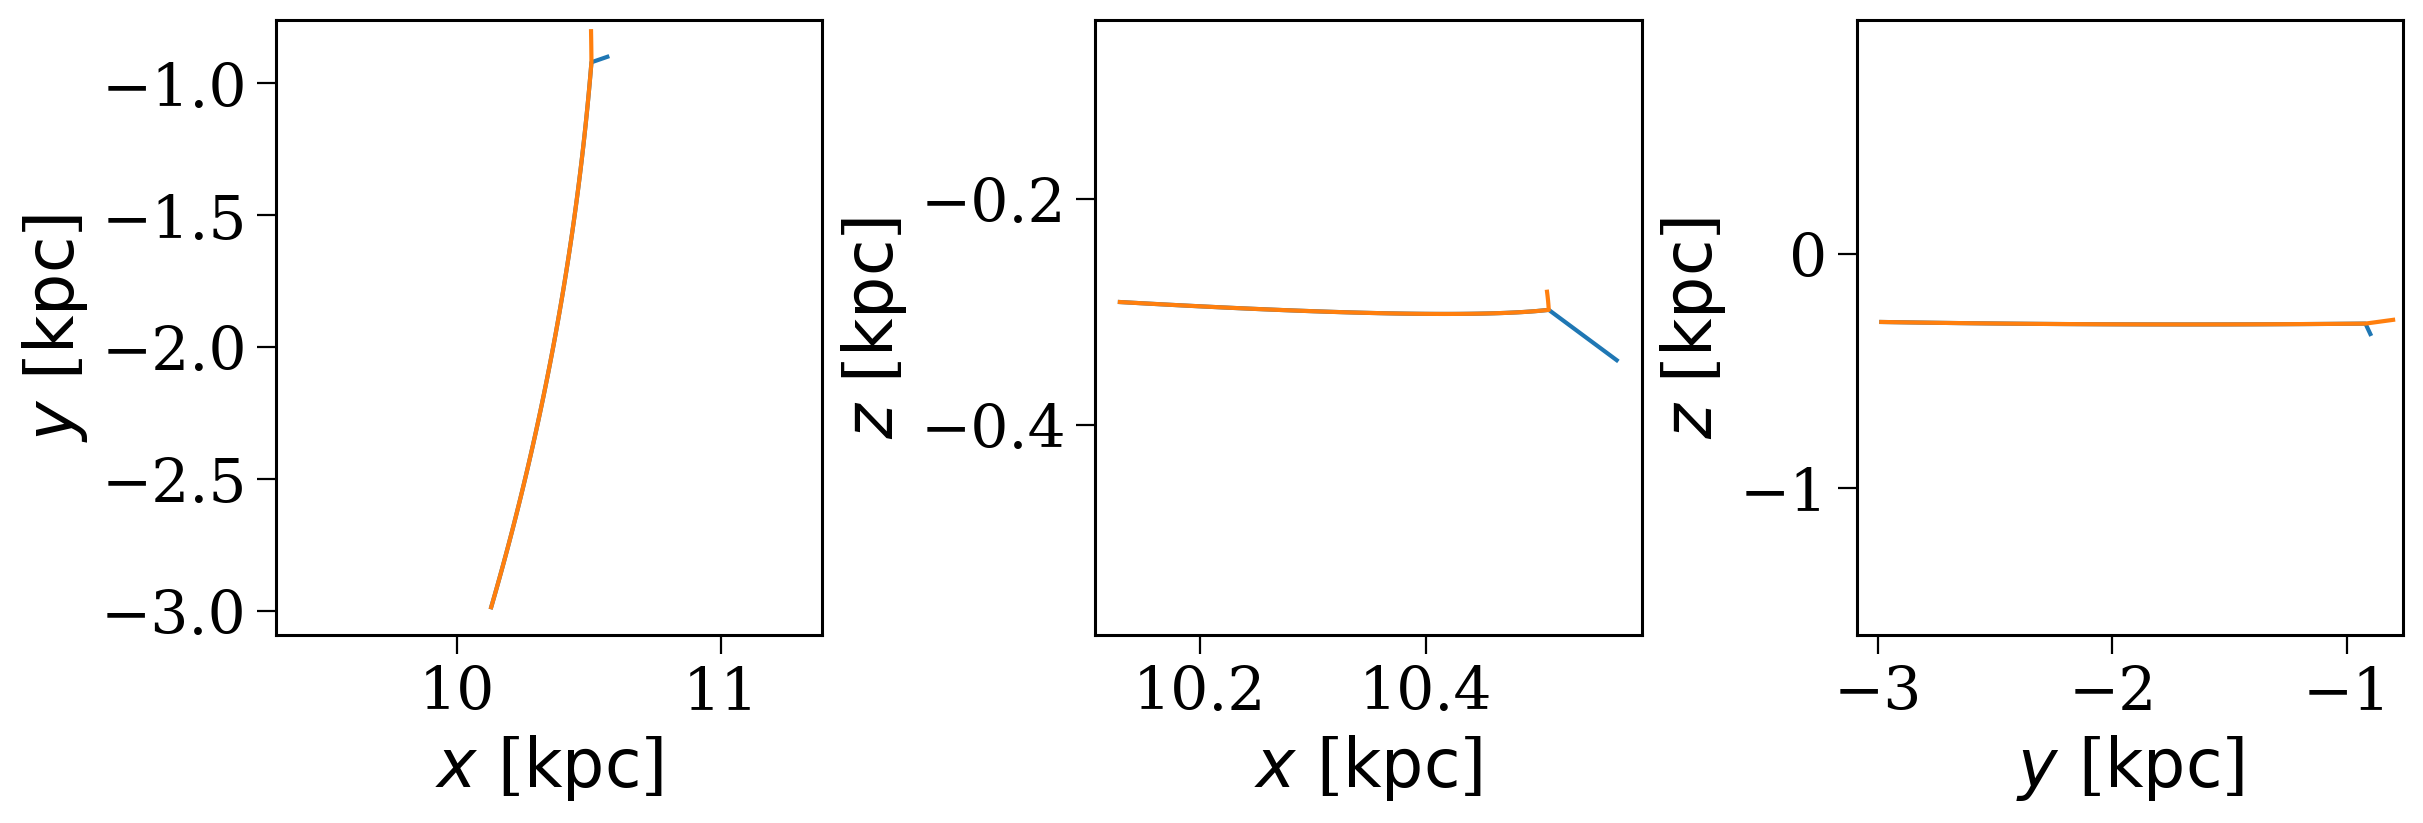

In [191]:
fig = just_theorist_pop.orbits[0][:75].plot();
just_theorist_pop.orbits[len(just_theorist_pop)].plot(axes=fig.axes);

In [147]:
just_theorist_pop.kick_info

star  disrupted  natal_kick        phi       theta  mean_anomaly  \
2260      1.0        1.0  473.358498  17.581122  186.320808      0.000000   
2260      0.0        0.0    0.000000   0.000000    0.000000      0.000000   
12689     1.0        1.0  710.627547  48.039900   94.696763      0.000000   
12689     0.0        0.0    0.000000   0.000000    0.000000      0.000000   
17815     1.0        1.0  740.955949  30.555122   20.282079      0.000000   
...       ...        ...         ...        ...         ...           ...   
3294677   0.0        0.0    0.000000   0.000000    0.000000      0.000000   
3307172   1.0        1.0  523.347071 -18.989023   33.016829      0.000000   
3307172   0.0        0.0    0.000000   0.000000    0.000000      0.000000   
3307673   1.0        0.0  270.662182  11.603026   69.038365    226.500642   
3307673   0.0        0.0    0.000000   0.000000    0.000000      0.000000   

         delta_vsysx_1  delta_vsysy_1  delta_vsysz_1  vsys_1_total  \
2260        138.409543     367.660255     420.986818    575.813481   
2260          0.000000       0.000000       0.000000      0.000000   
12689       162.119763     385.921782    -232.872121    479.007165   
12689         0.000000       0.000000       0.000000      0.000000   
17815       -43.595943     386.212817     -88.042617    398.512796   
...                ...            ...            ...           ...   
3294677       0.000000       0.000000       0.000000      0.000000   
3307172     -21.761270     140.758079      97.928482    172.847844   
3307172       0.000000       0.000000       0.000000      0.000000   
3307673      10.104347      -9.573626     -27.492040     30.815003   
3307673       0.000000       0.000000       0.000000      0.000000   

         delta_vsysx_2  delta_vsysy_2  delta_vsysz_2  vsys_2_total  \
2260         -3.544363     -15.241082     -32.235604     35.832768   
2260          0.000000       0.000000       0.000000      0.000000   
12689       -33.175993       6.883019     -13.456057     36.456658   
12689         0.000000       0.000000       0.000000      0.000000   
17815        -7.321261      33.845277      12.154487     36.699253   
...                ...            ...            ...           ...   
3294677       0.000000       0.000000       0.000000      0.000000   
3307172     -11.392656      37.076061       9.090642     39.838005   
3307172       0.000000       0.000000       0.000000      0.000000   
3307673       0.000000       0.000000      -0.000000      0.000000   
3307673       0.000000       0.000000       0.000000      0.000000   

         delta_theta_total      omega    randomseed    bin_num  
2260              0.000000   0.000000 -3.143252e+08     2260.0  
2260              0.000000   0.000000  0.000000e+00     2260.0  
12689             0.000000   0.000000 -1.164514e+09    12689.0  
12689             0.000000   0.000000  0.000000e+00    12689.0  
17815             0.000000   0.000000 -1.618857e+06    17815.0  
...                    ...        ...           ...        ...  
3294677           0.000000   0.000000  0.000000e+00  3294677.0  
3307172           0.000000   0.000000 -2.538712e+07  3307172.0  
3307172           0.000000   0.000000  0.000000e+00  3307172.0  
3307673          18.623627  56.877116 -1.272039e+09  3307673.0  
3307673           0.000000   0.000000  0.000000e+00  3307673.0  

[1648 rows x 18 columns]

In [145]:
just_theorist_pop.initial_galaxy.rho[0]

<Quantity 10.56017923 kpc>

In [144]:
np.linalg.norm(just_theorist_pop.final_pos[len(just_theorist_pop):, :2][0])

<Quantity 10.53819789 kpc>

0.8907766990291263


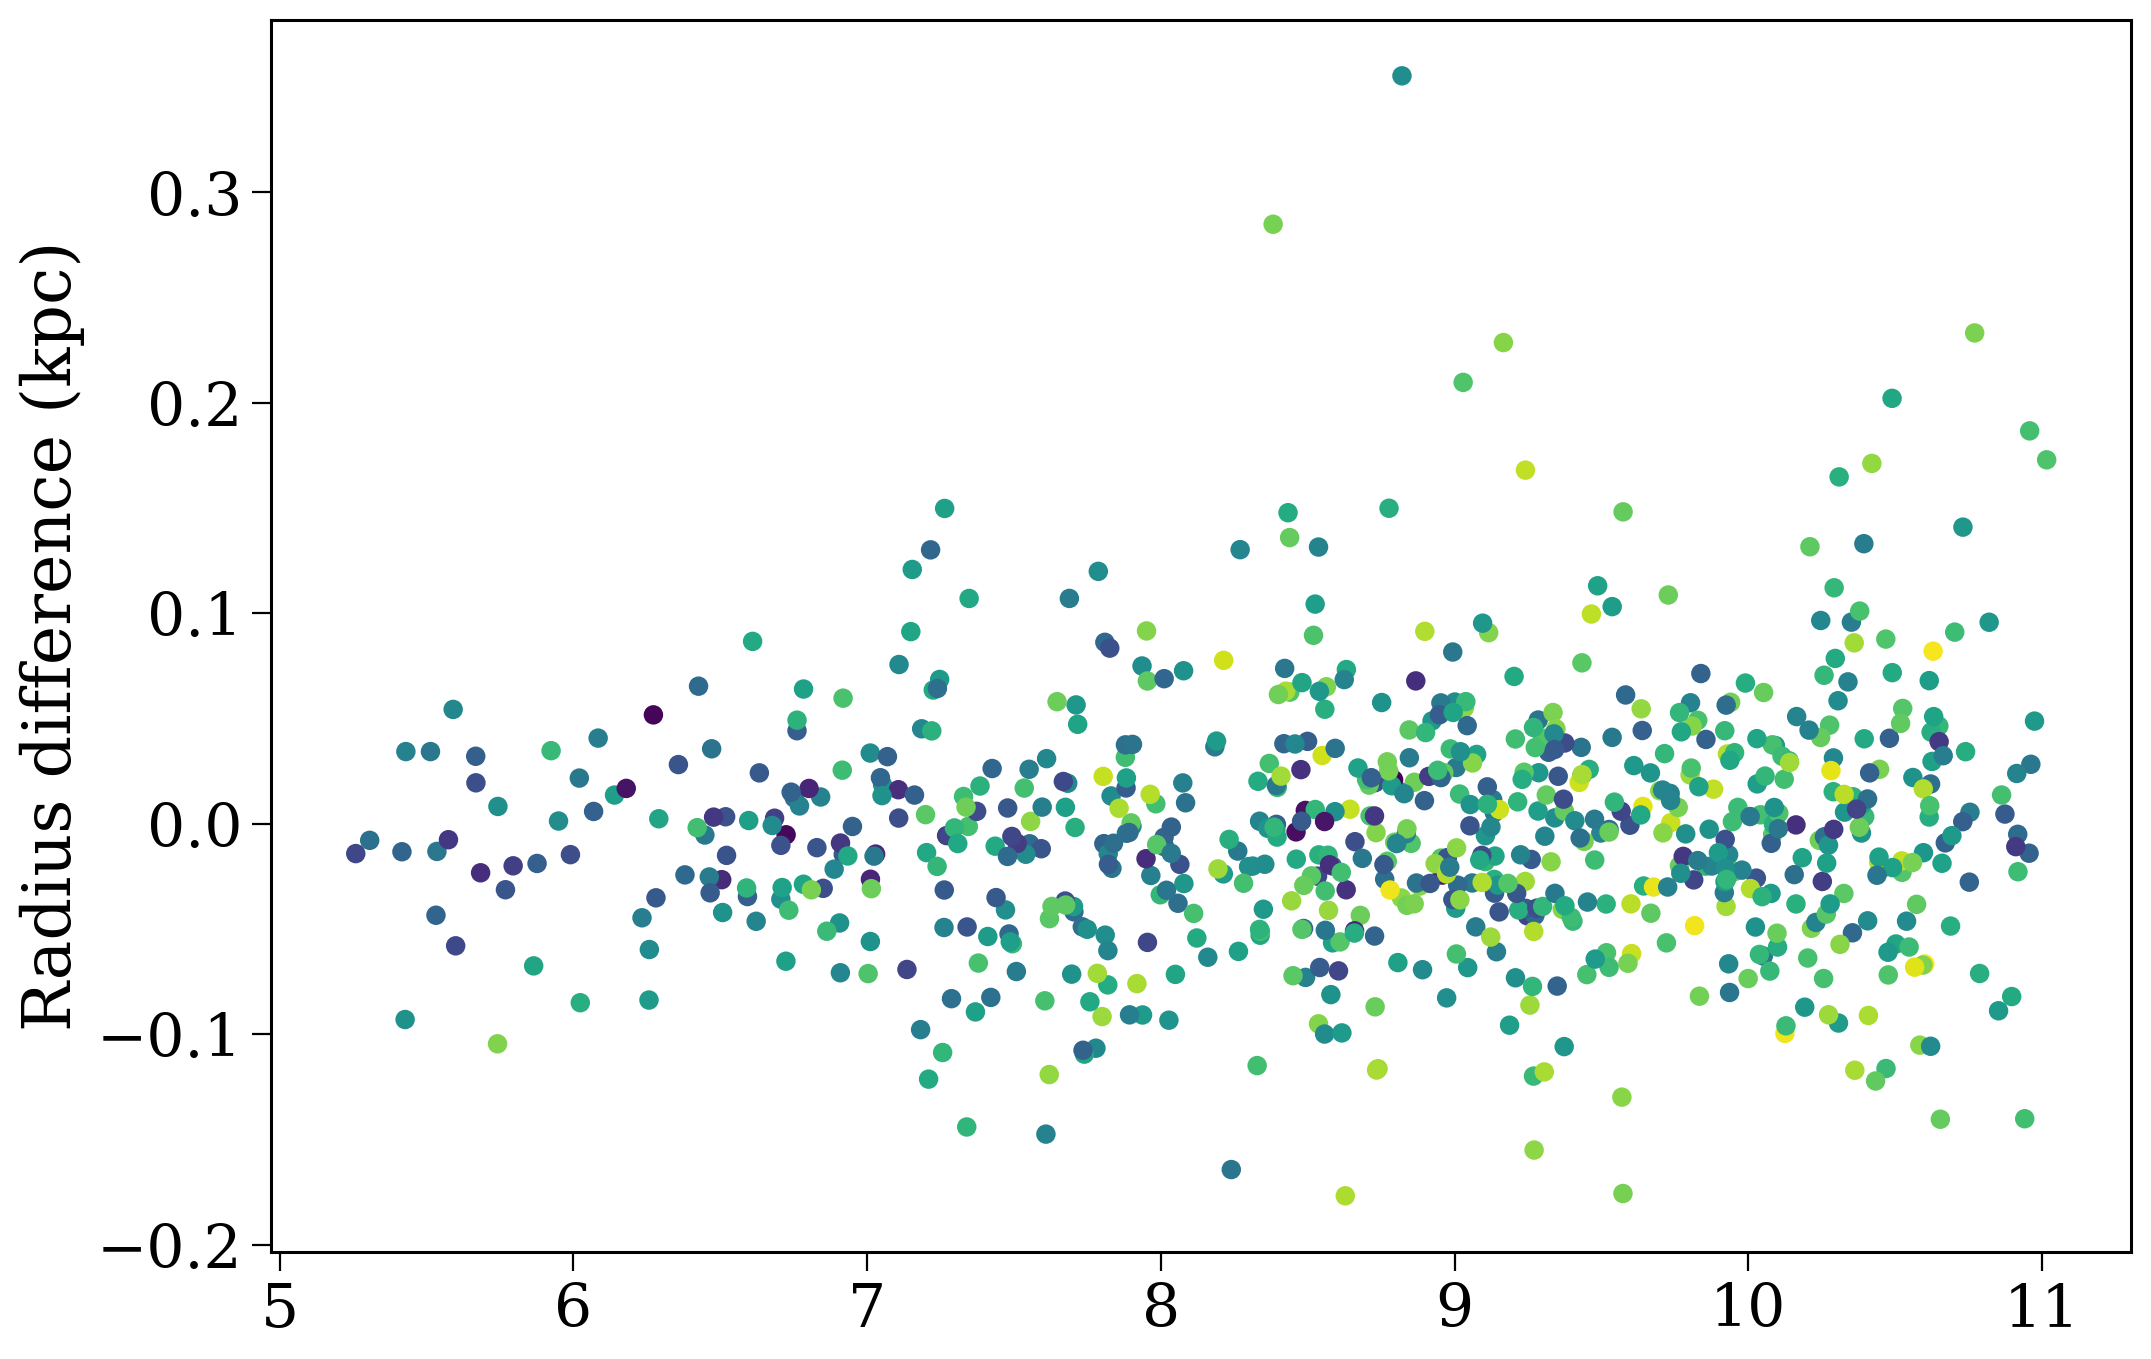

0.75


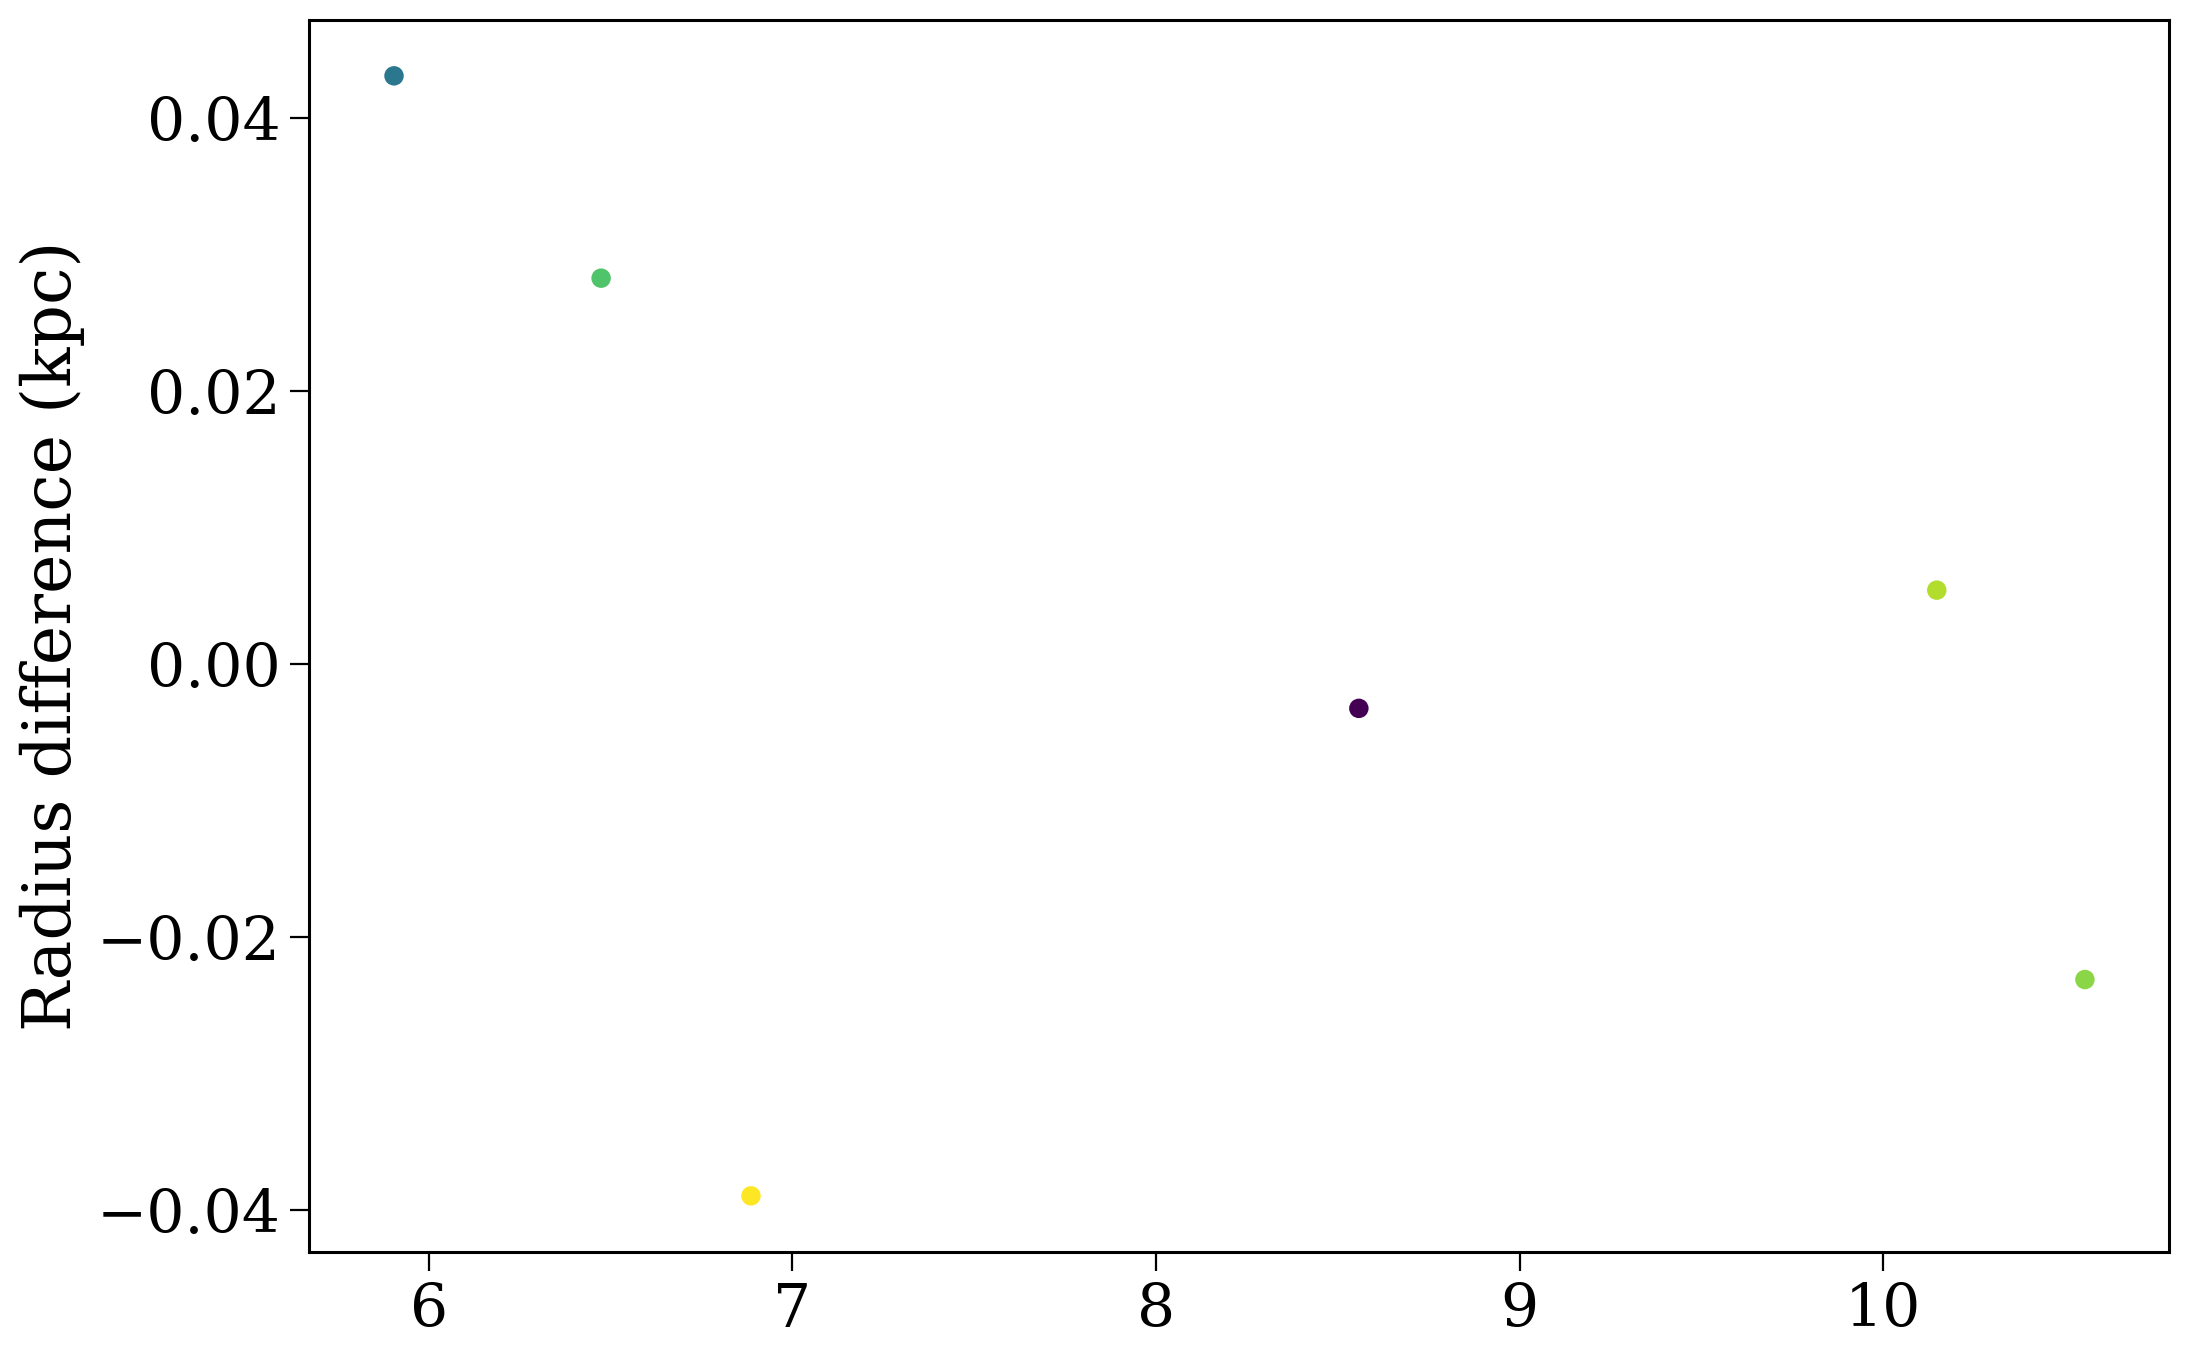

In [131]:
for thing in [just_theorist_pop, just_obs_pop]:
    initial_r, final_r = get_radius_difference(thing)
    plt.scatter(initial_r, initial_r - final_r, c=np.log10(thing.final_bpp[thing.disrupted]["tphys"]), label="Just theorist")
    plt.ylabel("Radius difference (kpc)")
    plt.show()

In [83]:
import gala.potential as gp

In [84]:
x_range = np.linspace(0, 30, 1000) * u.kpc
mw_v_circ = gp.MilkyWayPotential2022().circular_velocity(q=[x_range, np.zeros_like(x_range), np.zeros_like(x_range)])

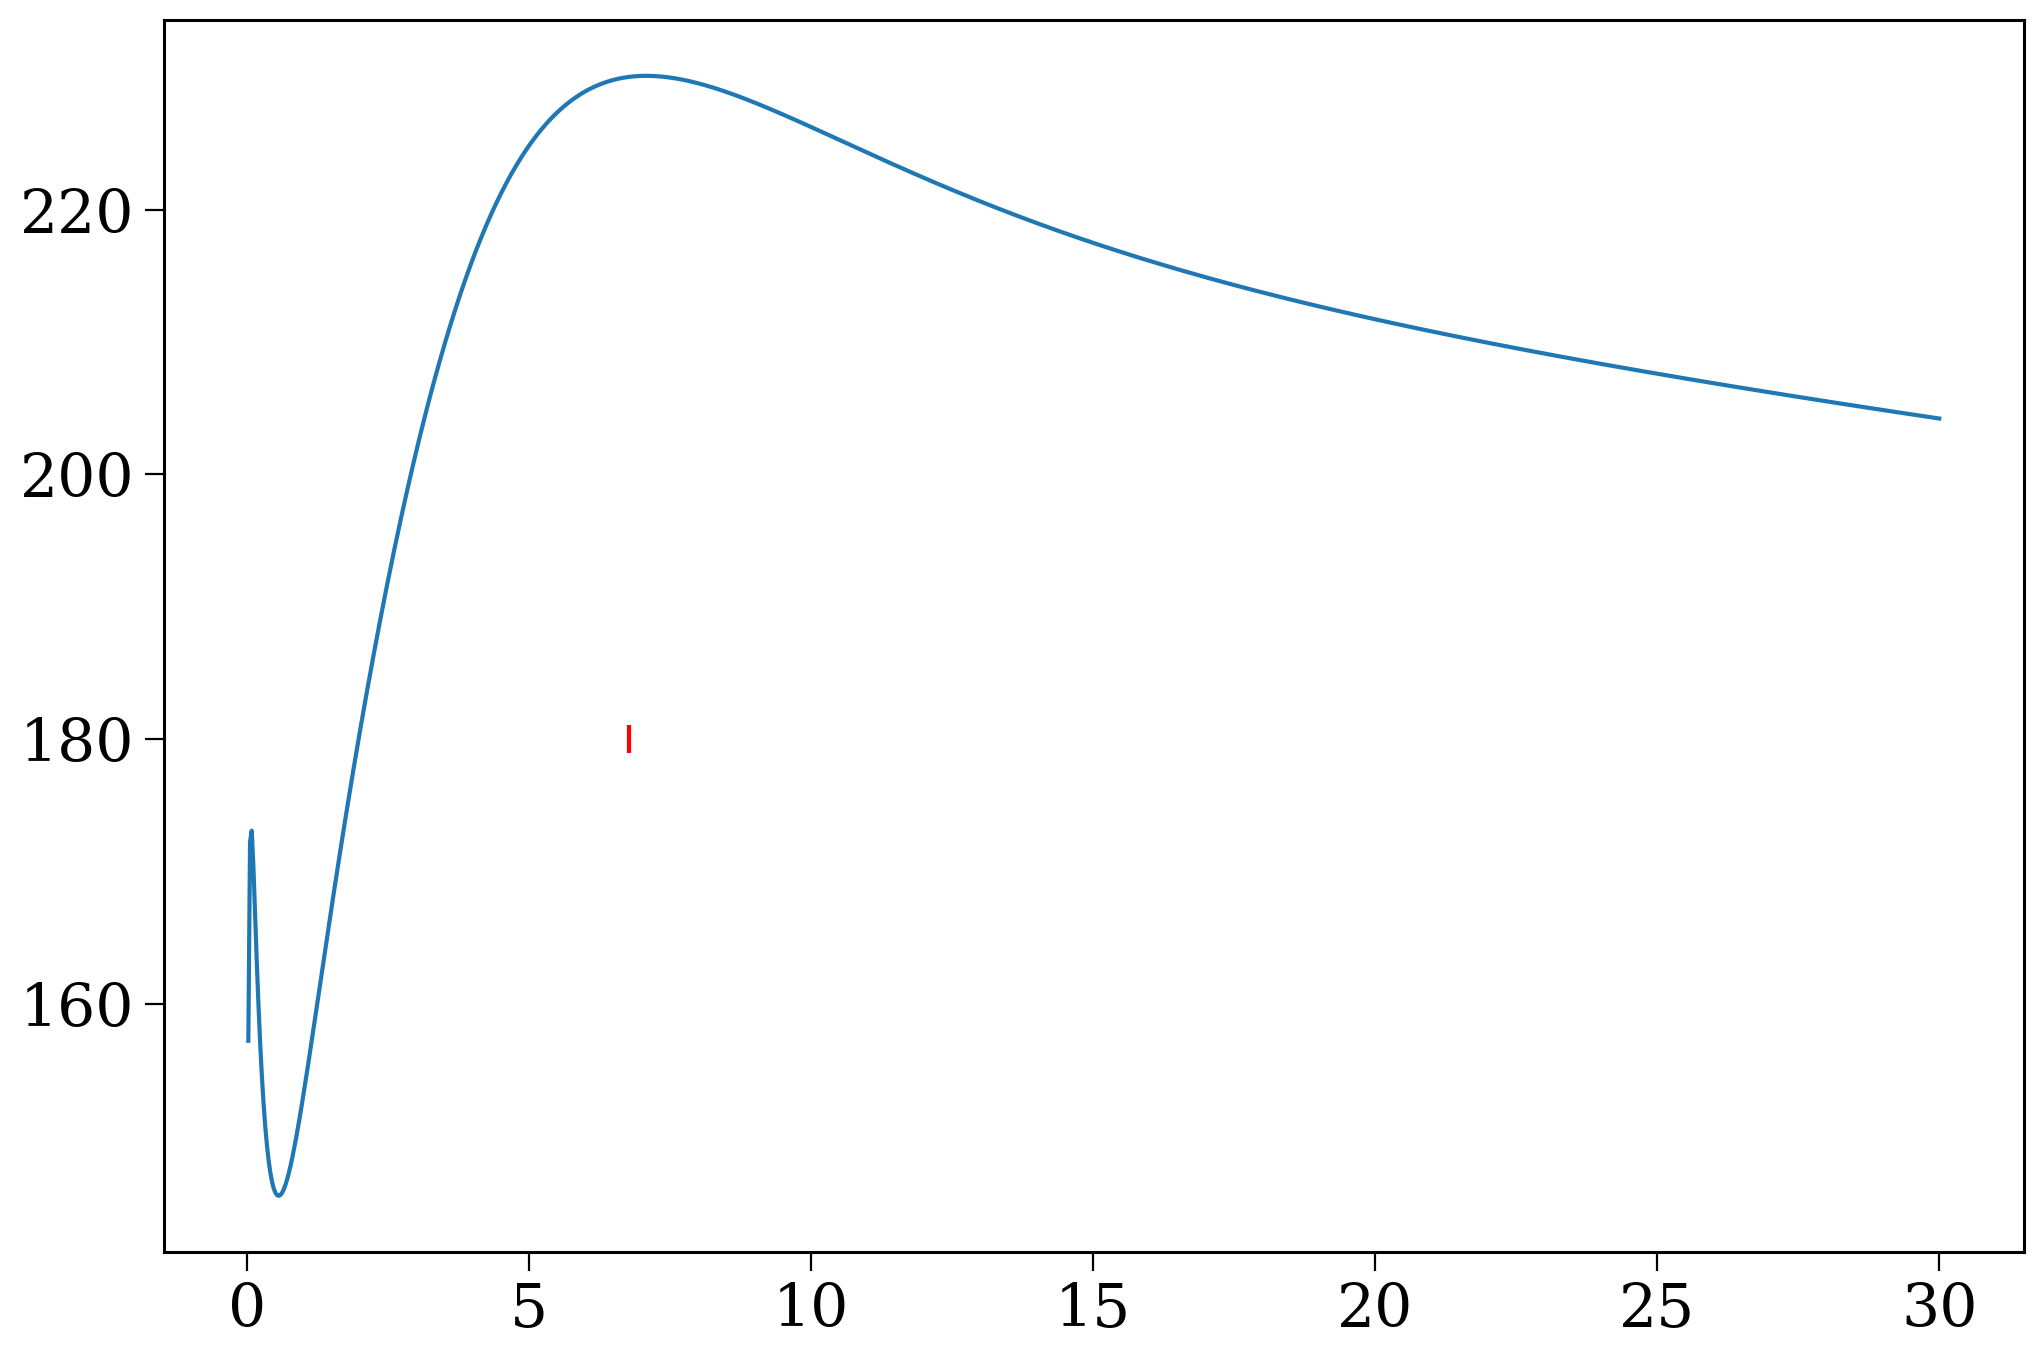

In [85]:
plt.plot(x_range, mw_v_circ)

test = get_radius_difference(just_obs_pop)[0]
plt.scatter(test, [180] * len(test), s=100, color='r', marker='|')

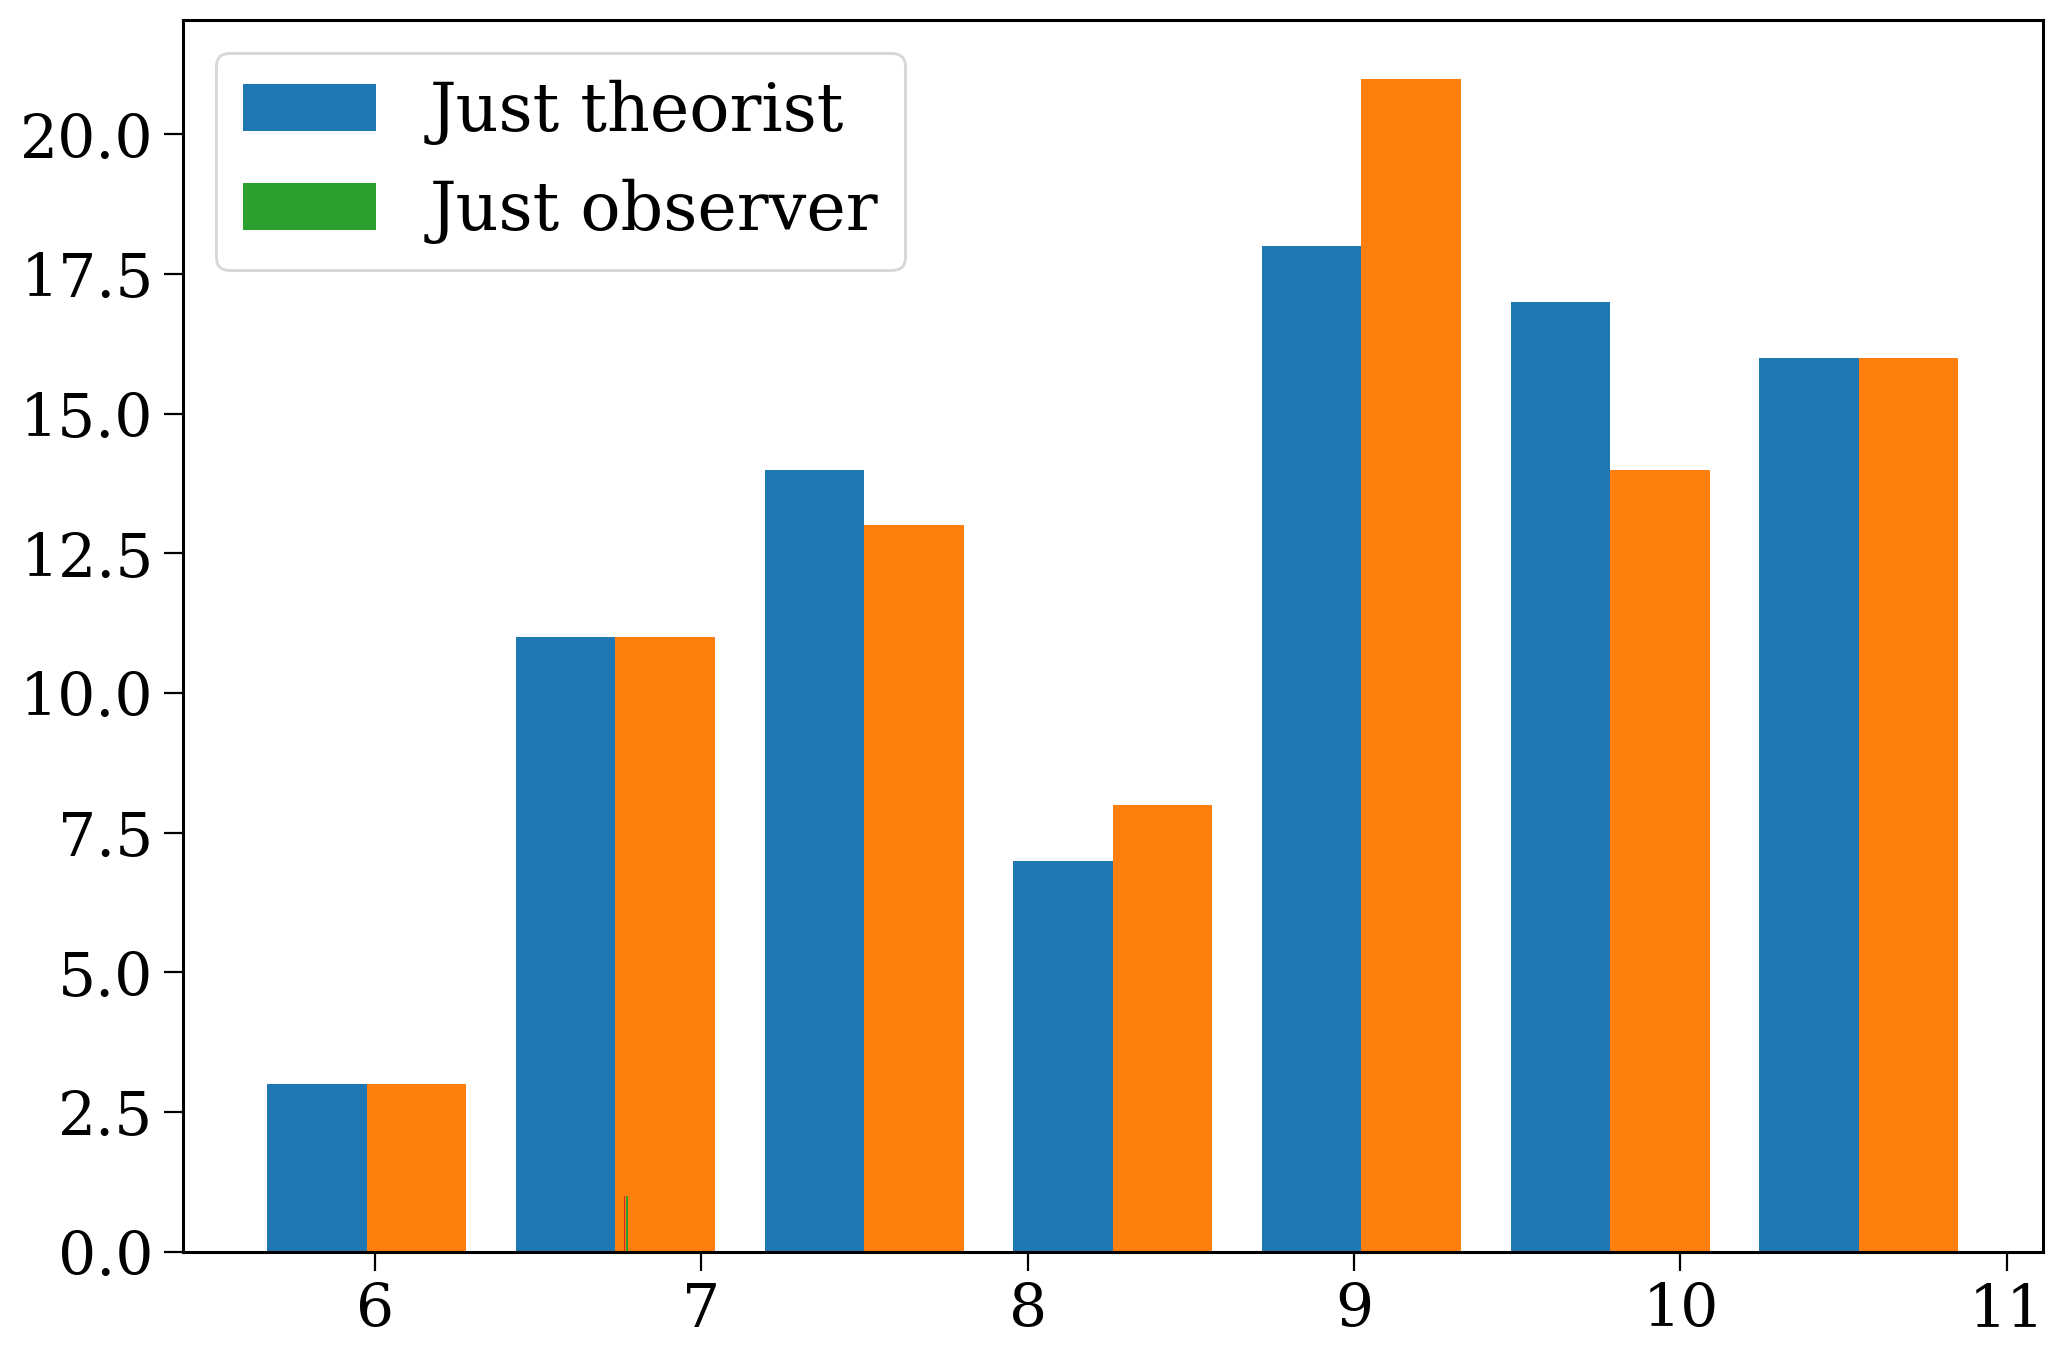

In [86]:
plt.hist(get_radius_difference(just_theorist_pop), bins="fd", label="Just theorist");
plt.hist(get_radius_difference(just_obs_pop), bins="fd", label="Just observer");
plt.legend()

## TODO: Kick direction

In [134]:
def kick_gal_pop(p):
    
    kick_nums = p.kick_info[p.kick_info["star"] == 1]["bin_num"].values
    kick_xyzs = p.kick_info[p.kick_info["star"] == 1][["delta_vsysx_2", "delta_vsysy_2", "delta_vsysz_2"]].values
    phases = p.initC.loc[kick_nums]["phase_sn_1"].values
    incs = p.initC.loc[kick_nums]["inc_sn_1"].values
    
    return kick_gal_direction(kick_xyzs, phases, incs)
    

def kick_gal_direction(delta_v_sys_xyz, theta, phi):
    v_X = delta_v_sys_xyz[:, 0] * np.cos(theta) - delta_v_sys_xyz[:, 1] * np.sin(theta) * np.cos(phi)\
        + delta_v_sys_xyz[:, 2] * np.sin(theta) * np.sin(phi)
    v_Y = delta_v_sys_xyz[:, 0] * np.sin(theta) + delta_v_sys_xyz[:, 1] * np.cos(theta) * np.cos(phi)\
        - delta_v_sys_xyz[:, 2] * np.cos(theta) * np.sin(phi)
    v_Z = delta_v_sys_xyz[:, 1] * np.sin(phi) + delta_v_sys_xyz[:, 2] * np.cos(phi)
    return np.array([v_X, v_Y, v_Z])

In [146]:
y = kick_gal_pop(just_obs_pop)

In [149]:
y[:2, :]

array([[ -1.17696432, -13.53013499,   7.07565991,  -3.60209742,
         -9.74268666,  11.07443827,   0.21249401,   0.26800091,
         -9.07173998,   7.33895686, -18.78881634,  10.60080234,
         17.74218801,  24.86774198,   7.70144912, -21.91059399,
        -28.0394163 , -29.28427706,   4.63471717,  -0.90772826,
          2.52332955,   9.60600784,   6.66885153,   5.44844804,
        -22.96899056,  -3.20322234,   8.89098673,   6.19168333,
         -9.22548047, -11.84528369,   6.23682968, -23.84563839,
         10.90875879,  -6.57484353,  10.02882604,  16.04094628,
         -8.63170253,  23.00013068,  -1.18063655,  -3.07116994,
          0.        , -21.28887042,   0.        ,   0.        ],
       [-20.05111918, -14.6898263 ,   8.44710085,   6.538833  ,
         23.87832229,   2.83186333,   8.51098047,   4.66859998,
          3.90418932,  -7.79951615,  -5.3324617 ,  -3.54152786,
         -5.63443643,  12.76369553,  10.33441057,  13.058124  ,
          2.14179147,   1.11876765,  -3

## TODO: Initial pos/vel

In [43]:
just_obs_pop = observer_runaway_pop[just_obs]

In [82]:
obs_no_kick_pop = just_obs_pop[~np.isin(just_obs_pop.bin_nums,
                                        just_obs_pop.kick_info[just_obs_pop.kick_info["star"] != 0.0]["bin_num"])]

In [44]:
just_obs_pop.initial_galaxy.rho

<Quantity [ 1.51063647,  0.78750034,  1.5500156 ,  0.11121113,  0.78909854,
            0.78121877,  0.58607348,  1.07541354,  2.96035093,  0.51547775,
            1.79896031,  1.31914741,  1.00372323,  0.83573571,  2.41027104,
            1.14563462,  2.59839047,  0.88532805,  0.59993463,  1.86682857,
            1.31468369, 13.71028122,  0.66162754,  1.15625193,  2.87508537,
            9.82863898, 37.52287548,  0.99031538,  0.99250389,  1.8894931 ,
            1.2755582 ,  0.58276258, 14.30049899,  1.52129085,  0.99802196,
            1.26252062,  1.22035905,  0.66907071,  1.0051871 ,  1.71088776,
            0.61737626,  1.75457408,  1.02513702,  0.20314592,  0.57465208,
            9.88222667,  0.4784204 ,  2.89204086,  0.77453494,  0.86690127,
            1.9581295 ,  1.41136047,  2.27687048,  1.31119364,  1.42926834,
            7.59972996,  1.12847623,  1.8003094 ,  0.14523992,  0.9900236 ,
            6.56759625,  0.88515131,  1.59439825,  1.66904613, 11.32124634,
           1

In [115]:
hot_theorists.kick_info[hot_theorists.kick_info["star"] == 1]

star  disrupted  natal_kick        phi       theta  mean_anomaly  \
68        1.0        1.0  583.611455  -4.903116  111.921909      0.000000   
2393      1.0        1.0  550.811495 -73.747538  251.314530      0.000000   
3021      1.0        1.0  621.308201  38.253031   56.804799      0.000000   
3098      1.0        1.0  564.904606 -52.768941   47.987401      0.000000   
5138      1.0        1.0  508.215540  73.817396  250.248857      0.000000   
...       ...        ...         ...        ...         ...           ...   
3302537   1.0        1.0  581.880296 -65.918581  116.803122      0.000000   
3302666   1.0        0.0  174.849344 -31.572475   28.957255    231.874952   
3302691   1.0        1.0  301.740671 -35.740891  145.816212      0.000000   
3304068   1.0        1.0  624.822051  40.134077  234.883833      0.000000   
3307326   1.0        1.0  420.437902 -15.253214  316.972196      0.000000   

         delta_vsysx_1  delta_vsysy_1  delta_vsysz_1  vsys_1_total  \
68          421.462193    -185.350342     398.193807    608.722792   
2393         92.456456    -134.216574    -162.024186    229.813233   
3021        -22.957363     227.052900      77.772991    241.098939   
3098         64.779665      12.116872     230.533490    239.768458   
5138       -149.270835    -227.390279      97.719262    289.027984   
...                ...            ...            ...           ...   
3302537     -43.617227    -228.400636     107.964098    256.369966   
3302666      22.076135     -19.553925      -6.399537     30.177240   
3302691      26.534407    -217.269415    -235.275344    321.348037   
3304068     178.376743    -262.296778     471.141242    567.971771   
3307326      63.934793      68.905214     130.944198    161.189234   

         delta_vsysx_2  delta_vsysy_2  delta_vsysz_2  vsys_2_total  \
68           -9.812821     -22.124785     -24.951718     34.761844   
2393         32.598491      11.105368      24.021496     41.988369   
3021         33.930183       6.129308      37.541829     50.972685   
3098        -27.546808     -21.377149      29.003639     45.354385   
5138         -6.116800      38.821572      19.212821     43.745425   
...                ...            ...            ...           ...   
3302537     -34.154817       6.595555       2.384794     34.867465   
3302666       0.000000      -0.000000       0.000000      0.000000   
3302691      10.911199      22.525130      18.410250     31.070453   
3304068     -25.243830      18.301749       1.386917     31.211032   
3307326     -13.431731      24.132703     -17.987108     32.959593   

         delta_theta_total      omega    randomseed    bin_num  
68                0.000000   0.000000 -1.567868e+09       68.0  
2393              0.000000   0.000000 -1.340664e+08     2393.0  
3021              0.000000   0.000000 -7.651093e+08     3021.0  
3098              0.000000   0.000000 -4.928208e+08     3098.0  
5138              0.000000   0.000000 -1.246441e+09     5138.0  
...                    ...        ...           ...        ...  
3302537           0.000000   0.000000 -6.627540e+08  3302537.0  
3302666          87.963945  87.416293 -5.857799e+08  3302666.0  
3302691           0.000000   0.000000 -1.329605e+09  3302691.0  
3304068           0.000000   0.000000 -5.544534e+08  3304068.0  
3307326           0.000000   0.000000 -1.835575e+08  3307326.0  

[1995 rows x 18 columns]

In [116]:
x = kick_gal_pop(hot_theorists)

In [122]:
plt.hist(x[:, 2])

(array([  3.,  23., 359., 825., 553., 219.,   8.,   4.,   0.,   1.]),
 array([-98.82245465, -73.22250615, -47.62255766, -22.02260917,
          3.57733933,  29.17728782,  54.77723631,  80.37718481,
        105.9771333 , 131.57708179, 157.17703029]),
 <BarContainer object of 10 artists>)

In [108]:
kick_gal_direction(hot_theorists.kick_info.loc[68].iloc[0][["delta_vsysx_2", "delta_vsysy_2", "delta_vsysz_2"]].values,
                   hot_theorists.initC.loc[68]["phase_sn_1"],
                   hot_theorists.initC.loc[68]["inc_sn_1"])

(-7.1672109528453465, -14.947827059261455, 30.554530243452334)

In [107]:
hot_theorists.initC.loc[68]["phase_sn_1"]

2.061025604396207

In [104]:
hot_theorists.kick_info.loc[68].iloc[0][["delta_vsysx_2", "delta_vsysy_2", "delta_vsysz_2"]].values

array([ -9.81282085, -22.12478459, -24.95171775])

In [92]:
hot_theorists.kick_info

star  disrupted  natal_kick        phi       theta  mean_anomaly  \
68        1.0        1.0  583.611455  -4.903116  111.921909           0.0   
68        0.0        0.0    0.000000   0.000000    0.000000           0.0   
2393      1.0        1.0  550.811495 -73.747538  251.314530           0.0   
2393      0.0        0.0    0.000000   0.000000    0.000000           0.0   
3021      1.0        1.0  621.308201  38.253031   56.804799           0.0   
...       ...        ...         ...        ...         ...           ...   
3302691   0.0        0.0    0.000000   0.000000    0.000000           0.0   
3304068   1.0        1.0  624.822051  40.134077  234.883833           0.0   
3304068   0.0        0.0    0.000000   0.000000    0.000000           0.0   
3307326   1.0        1.0  420.437902 -15.253214  316.972196           0.0   
3307326   0.0        0.0    0.000000   0.000000    0.000000           0.0   

         delta_vsysx_1  delta_vsysy_1  delta_vsysz_1  vsys_1_total  \
68          421.462193    -185.350342     398.193807    608.722792   
68            0.000000       0.000000       0.000000      0.000000   
2393         92.456456    -134.216574    -162.024186    229.813233   
2393          0.000000       0.000000       0.000000      0.000000   
3021        -22.957363     227.052900      77.772991    241.098939   
...                ...            ...            ...           ...   
3302691       0.000000       0.000000       0.000000      0.000000   
3304068     178.376743    -262.296778     471.141242    567.971771   
3304068       0.000000       0.000000       0.000000      0.000000   
3307326      63.934793      68.905214     130.944198    161.189234   
3307326       0.000000       0.000000       0.000000      0.000000   

         delta_vsysx_2  delta_vsysy_2  delta_vsysz_2  vsys_2_total  \
68           -9.812821     -22.124785     -24.951718     34.761844   
68            0.000000       0.000000       0.000000      0.000000   
2393         32.598491      11.105368      24.021496     41.988369   
2393          0.000000       0.000000       0.000000      0.000000   
3021         33.930183       6.129308      37.541829     50.972685   
...                ...            ...            ...           ...   
3302691       0.000000       0.000000       0.000000      0.000000   
3304068     -25.243830      18.301749       1.386917     31.211032   
3304068       0.000000       0.000000       0.000000      0.000000   
3307326     -13.431731      24.132703     -17.987108     32.959593   
3307326       0.000000       0.000000       0.000000      0.000000   

         delta_theta_total  omega    randomseed    bin_num  
68                     0.0    0.0 -1.567868e+09       68.0  
68                     0.0    0.0  0.000000e+00       68.0  
2393                   0.0    0.0 -1.340664e+08     2393.0  
2393                   0.0    0.0  0.000000e+00     2393.0  
3021                   0.0    0.0 -7.651093e+08     3021.0  
...                    ...    ...           ...        ...  
3302691                0.0    0.0  0.000000e+00  3302691.0  
3304068                0.0    0.0 -5.544534e+08  3304068.0  
3304068                0.0    0.0  0.000000e+00  3304068.0  
3307326                0.0    0.0 -1.835575e+08  3307326.0  
3307326                0.0    0.0  0.000000e+00  3307326.0  

[3990 rows x 18 columns]

In [88]:
obs_no_kick_pop.initial_galaxy.rho

<Quantity [0.78750034, 0.11121113, 0.78121877, 1.07541354, 0.51547775,
           0.83573571, 0.88532805, 1.86682857, 0.66162754, 0.99031538,
           0.58276258, 1.22035905, 1.75457408, 1.02513702, 0.20314592,
           0.57465208, 0.77453494, 1.41136047, 1.31119364, 1.42926834,
           1.12847623, 1.8003094 , 0.14523992, 1.66904613, 0.44645677,
           1.69812336] kpc>

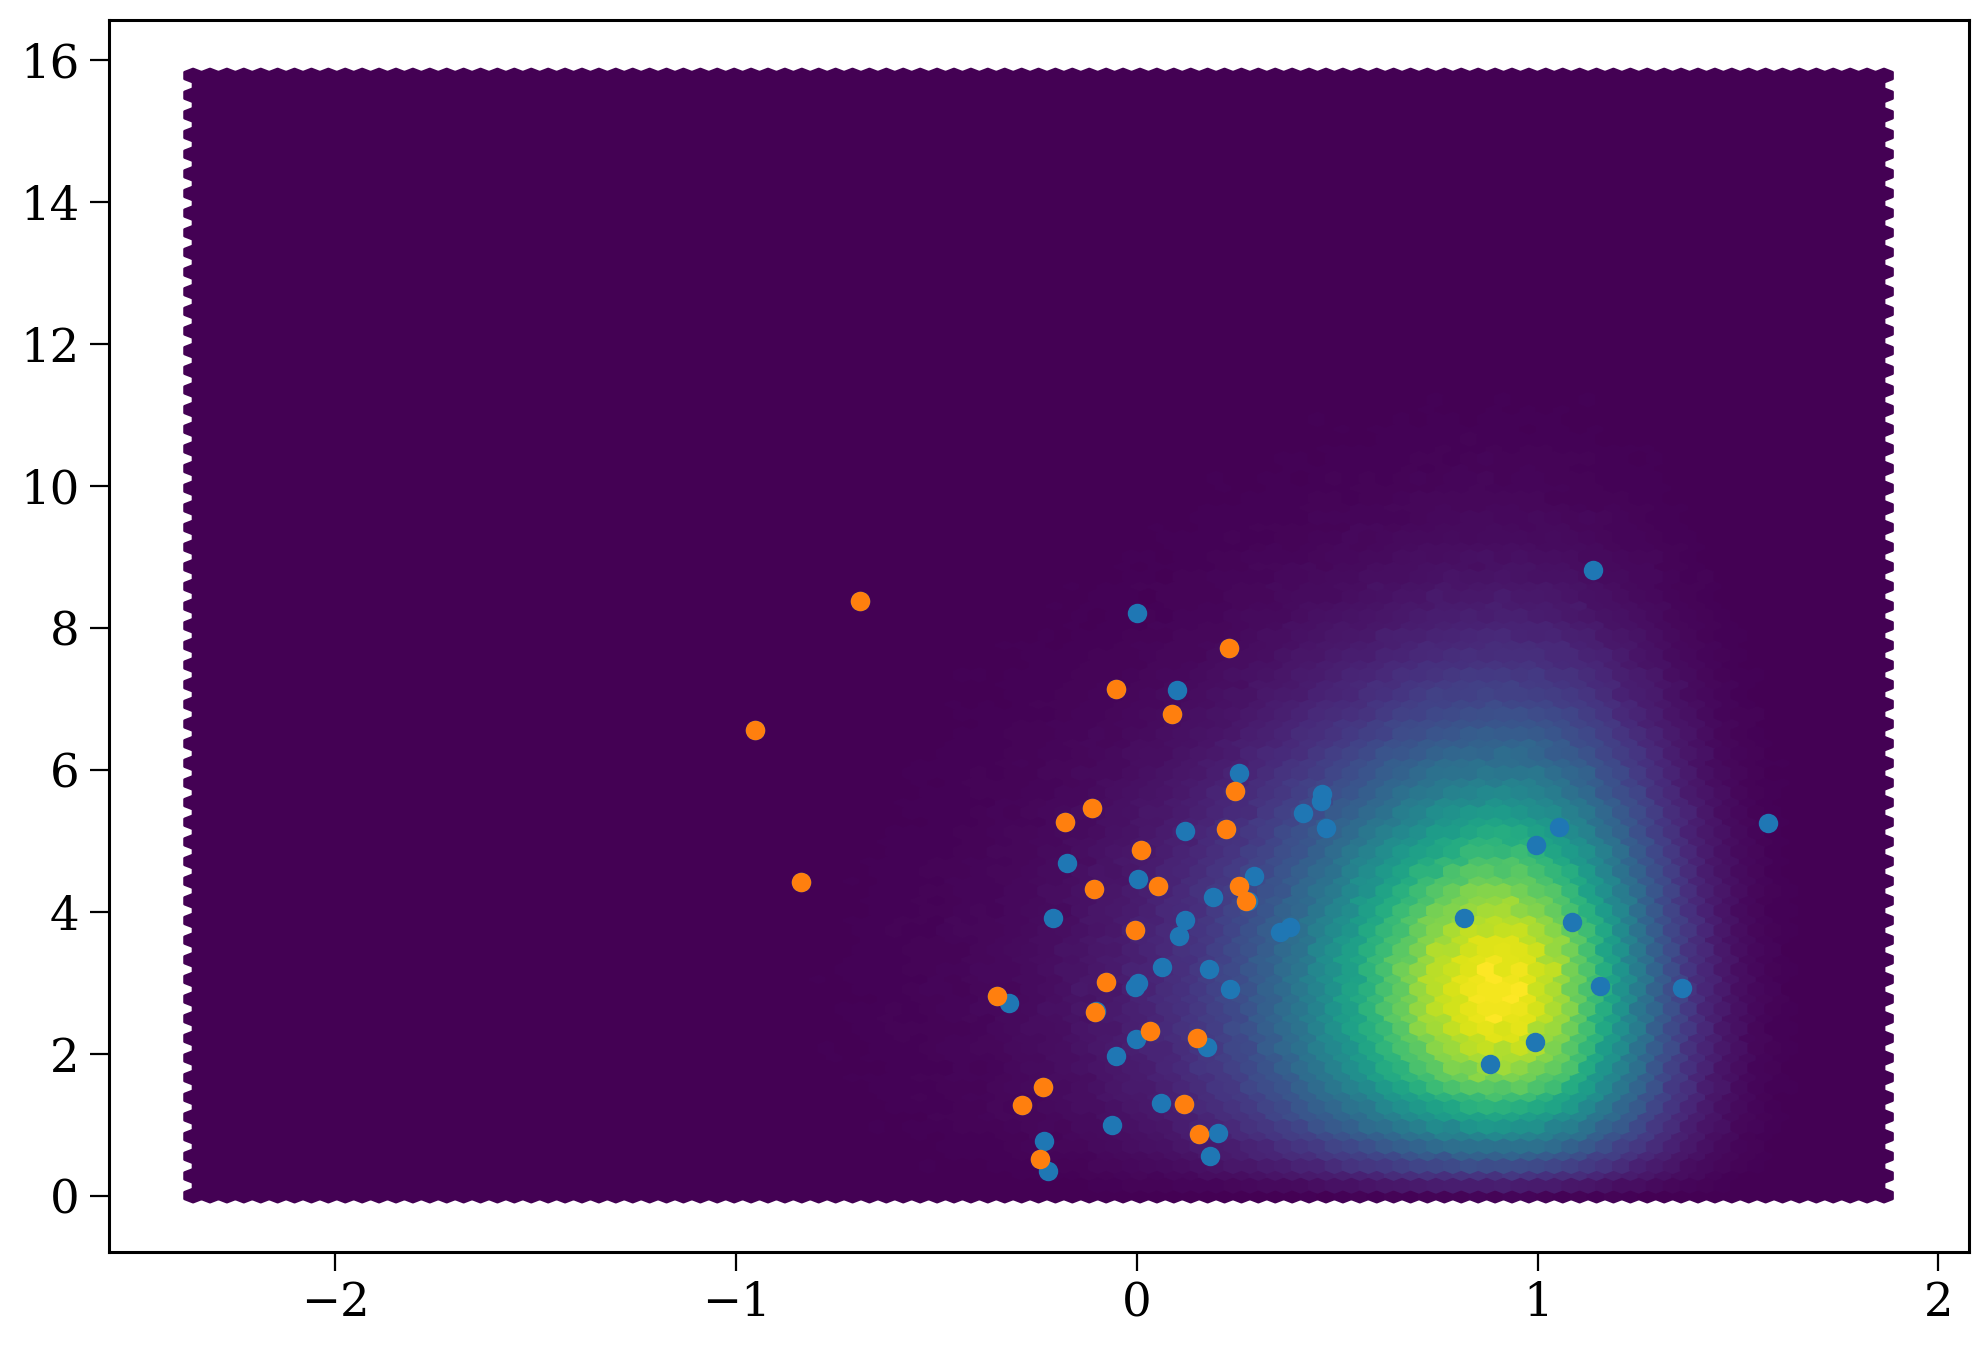

In [84]:
plt.hexbin(np.log10(p.initial_galaxy.rho.value), (p.initial_galaxy.v_R**2 + p.initial_galaxy.v_z**2)**(0.5))
plt.scatter(np.log10(just_obs_pop.initial_galaxy.rho.value), (just_obs_pop.initial_galaxy.v_R**2
                                                              + just_obs_pop.initial_galaxy.v_z**2)**(0.5))
plt.scatter(np.log10(obs_no_kick_pop.initial_galaxy.rho.value), (obs_no_kick_pop.initial_galaxy.v_R**2
                                                              + obs_no_kick_pop.initial_galaxy.v_z**2)**(0.5))

(array([0.00270829, 0.00270829, 0.06229069, 0.1164565 , 0.        ,
        0.        , 0.        , 0.        , 0.00270829, 0.00270829]),
 array([-16.87903722, -11.60422892,  -6.32942062,  -1.05461233,
          4.22019597,   9.49500426,  14.76981256,  20.04462086,
         25.31942915,  30.59423745,  35.86904575]),
 <BarContainer object of 10 artists>)

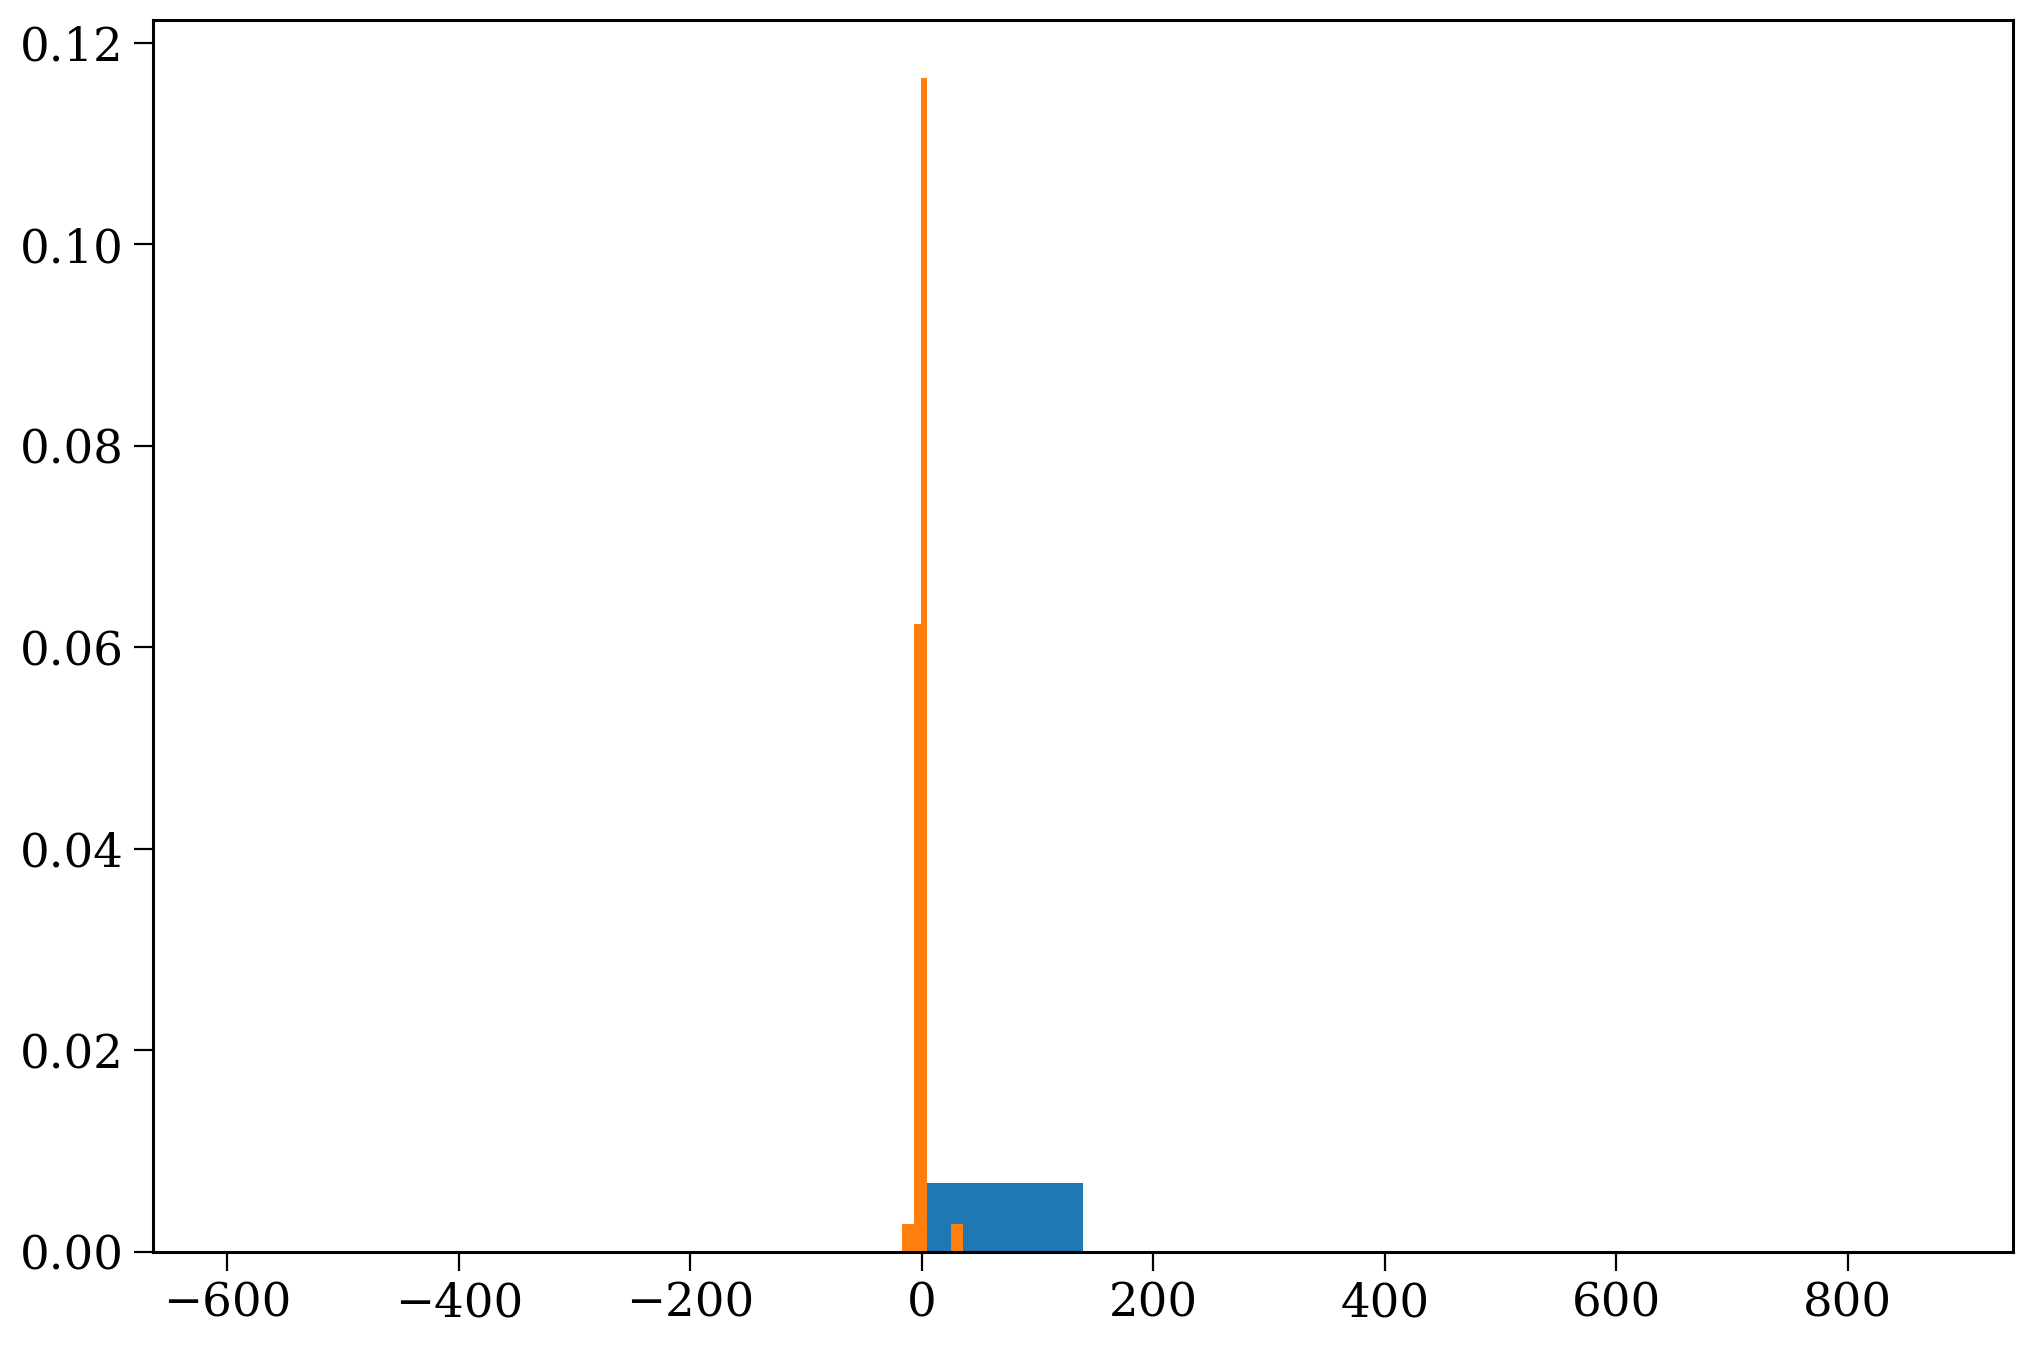

In [54]:
plt.hist(p.initial_galaxy.v_R / p.initial_galaxy.rho, density=True)
plt.hist(just_obs_pop.initial_galaxy.v_R / just_obs_pop.initial_galaxy.rho, density=True)

(array([10., 19., 16.,  9.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.11121113,  0.61003332,  1.10885551,  1.6076777 ,  2.10649989,
         2.60532208,  3.10414427,  3.60296647,  4.10178866,  4.60061085,
         5.09943304,  5.59825523,  6.09707742,  6.59589961,  7.09472181,
         7.593544  ,  8.09236619,  8.59118838,  9.09001057,  9.58883276,
        10.08765495, 10.58647715, 11.08529934, 11.58412153, 12.08294372,
        12.58176591, 13.0805881 , 13.57941029, 14.07823249, 14.57705468,
        15.07587687, 15.57469906, 16.07352125, 16.57234344, 17.07116563,
        17.56998783, 18.06881002, 18.56763221, 19.0664544 , 19.5

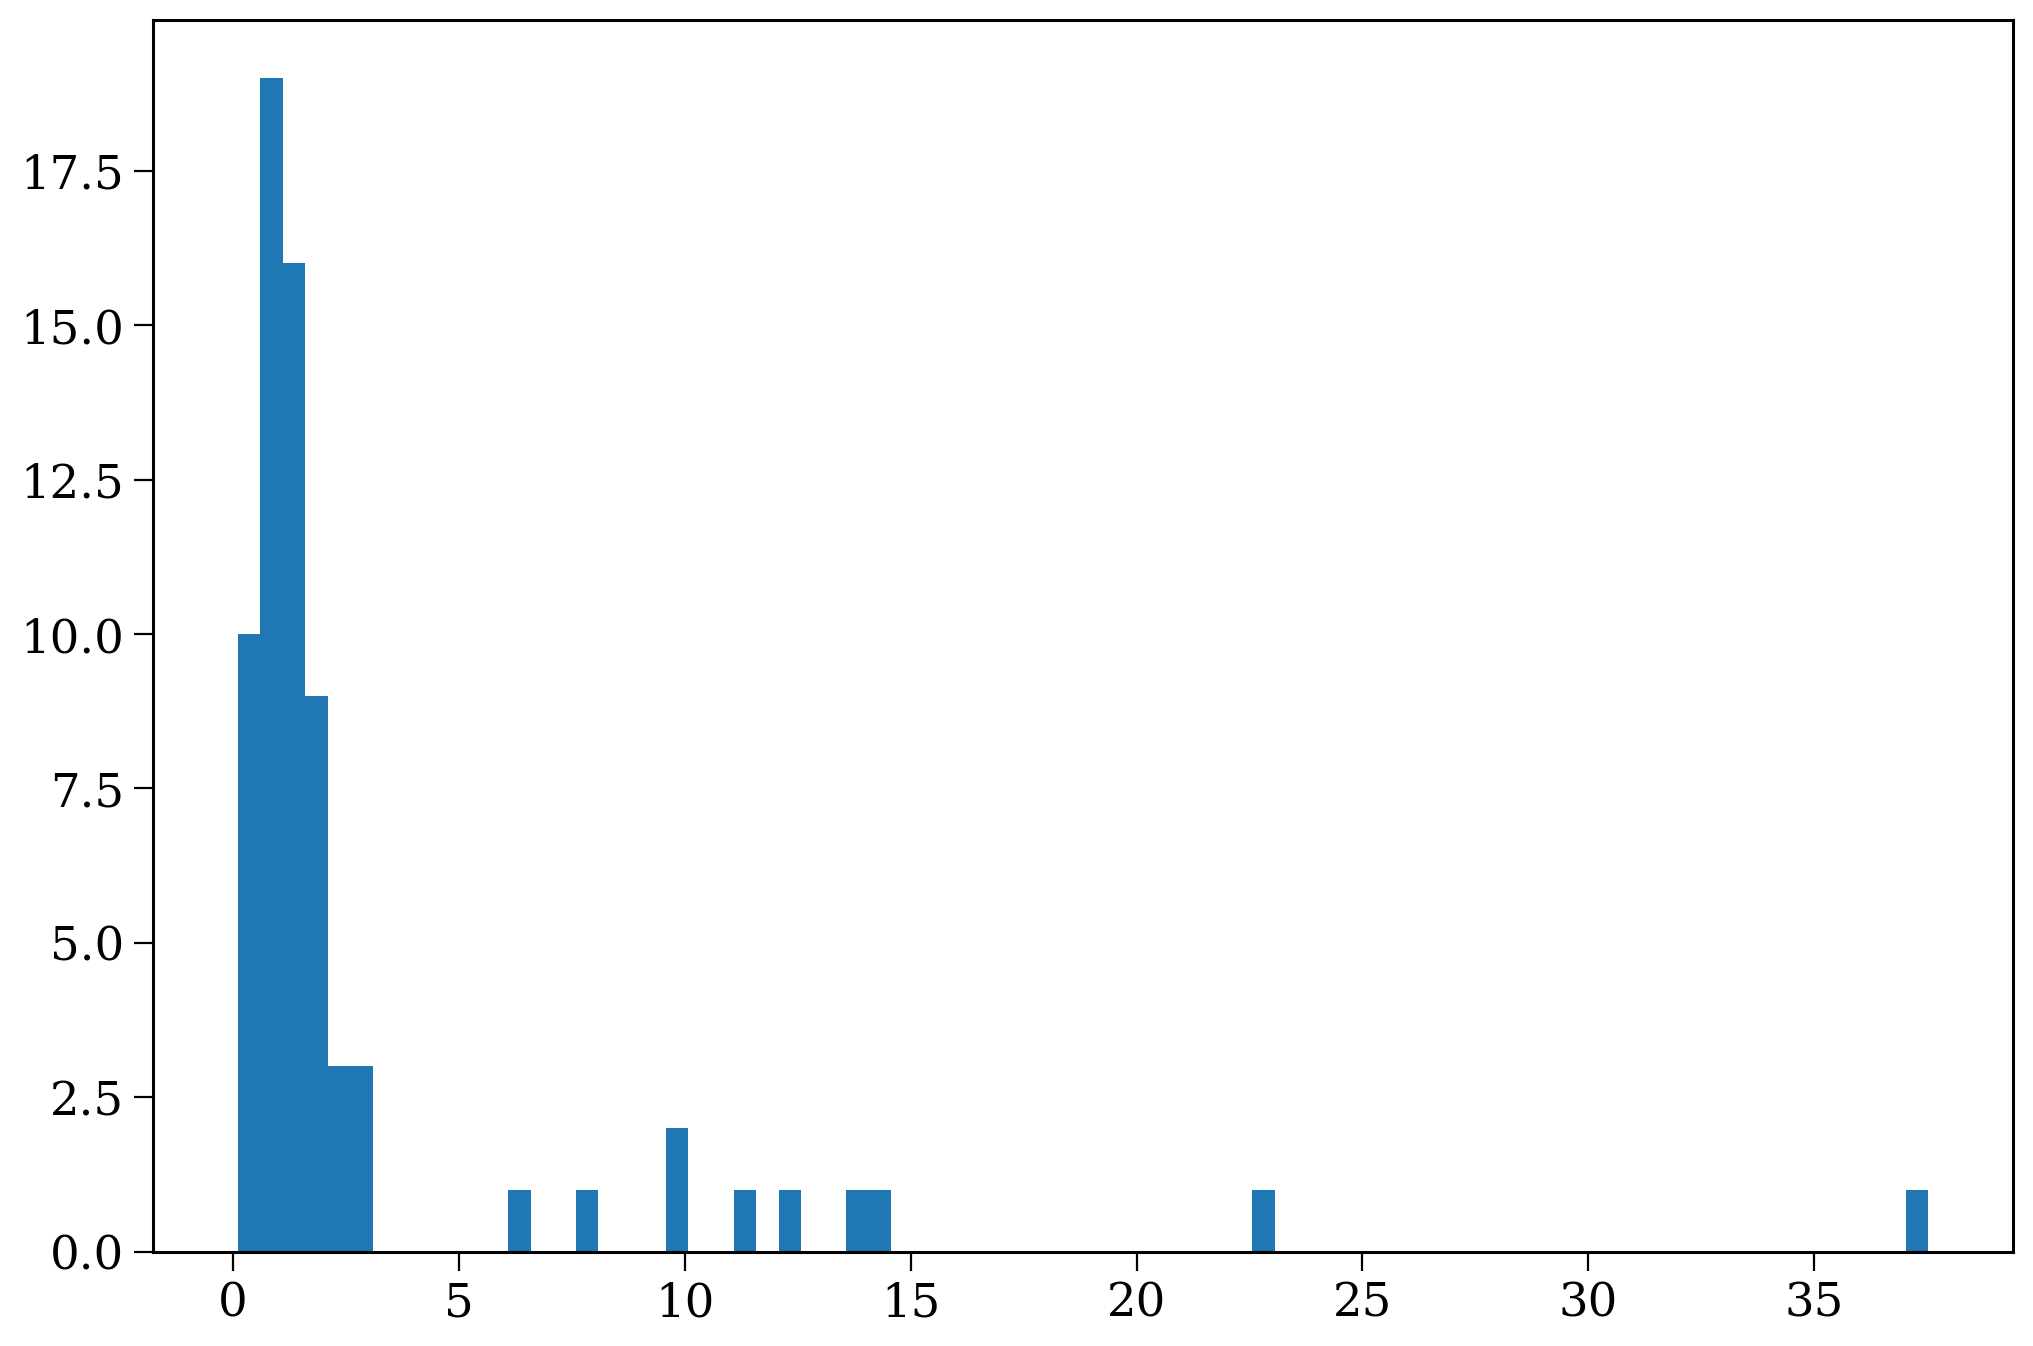

In [45]:
plt.hist(just_obs_pop.initial_galaxy.rho, bins="fd", density=False)
# plt.hist(theorist_runaway_pop[theorist_still_hot].initial_galaxy.rho, bins="fd", density=True)
# plt.hist(observer_runaway_pop.initial_galaxy.rho, bins="fd", density=True)

In [75]:
r_grid = np.geomspace(0.1, 30, 1000) * u.kpc

In [76]:
def get_v_circ(pot, R_grid):
    xyz = np.zeros((3,) + R_grid.shape) * pot.units["length"]
    xyz[0] = R_grid

    return pot.circular_velocity(xyz)

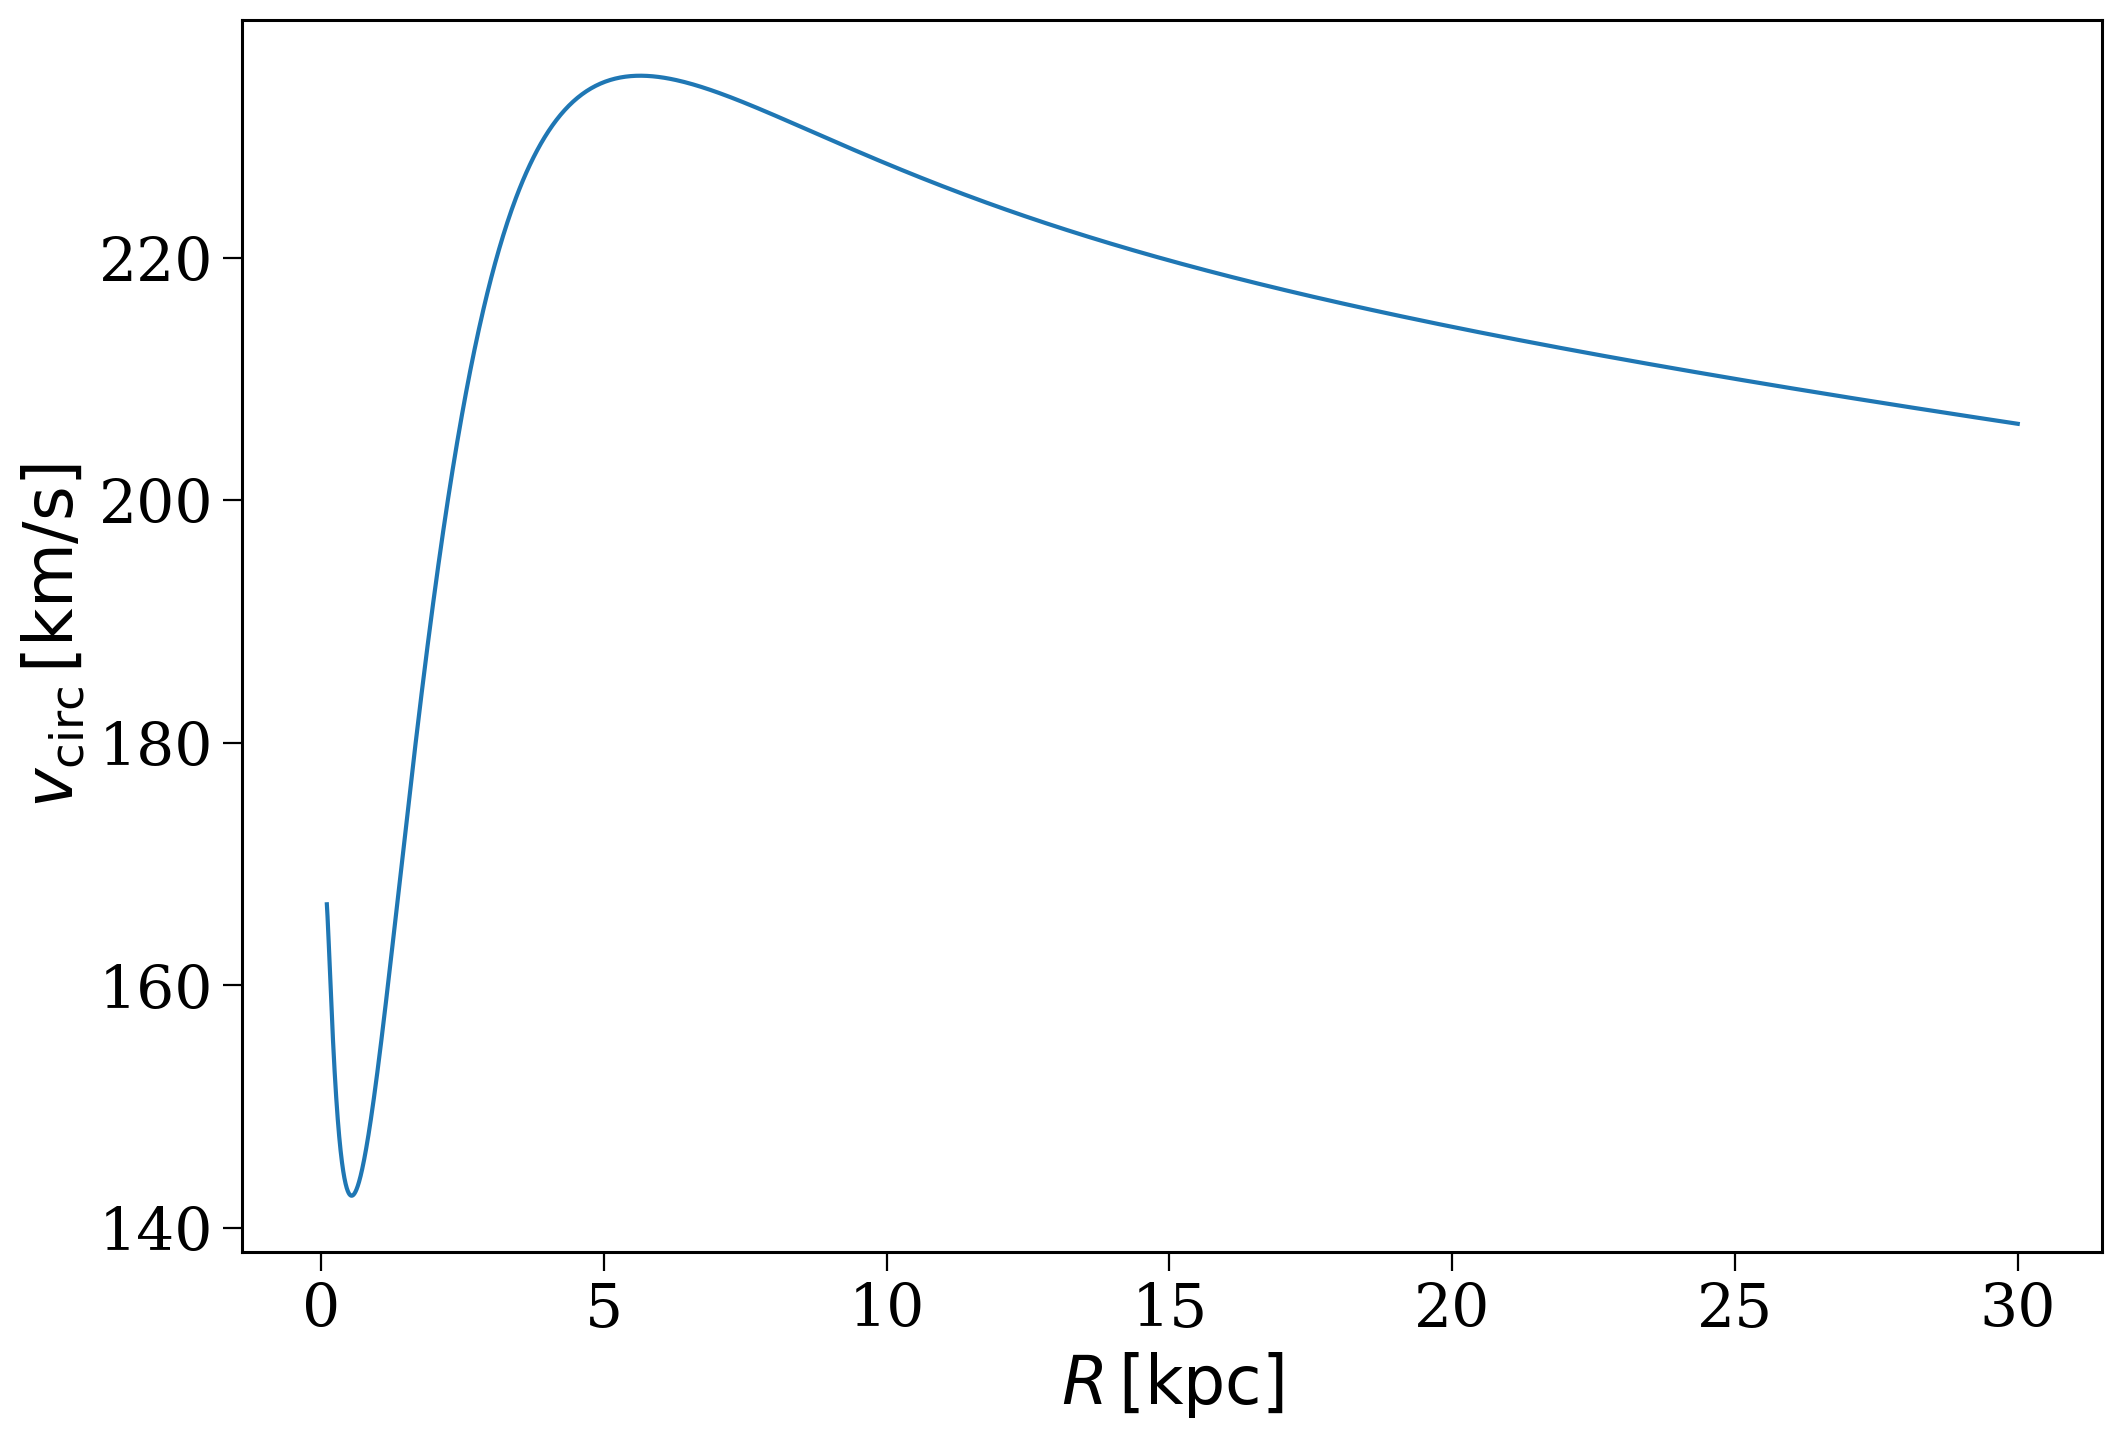

In [79]:
fig, ax = plt.subplots()

ax.plot(r_grid, get_v_circ(p.galactic_potential, r_grid))

ax.set(ylabel=r"$v_{\rm circ} \, [\rm km/s]$", xlabel=r"$R \, [\rm kpc]$")
    
plt.show()

In [59]:
just_obs_pop.final_bpp

tphys     mass_1     mass_2  kstar_1  kstar_2          sep  \
107373    4.911716   0.000000  32.901354     15.0      1.0     0.000000   
129157   11.445662   1.277584  19.995332     13.0      1.0    -1.000000   
178992   12.245887   1.277584  23.932429     13.0      1.0    -1.000000   
222982    5.606406   1.986166  34.877686     13.0      1.0    -1.000000   
343221    9.774816   1.392960  22.204477     13.0      1.0    -1.000000   
360369    5.359104   0.000000  22.255986     15.0      1.0     0.000000   
365126   10.460742   1.277584  21.781405     13.0      1.0    -1.000000   
501406    8.263616   1.433329  28.818059     13.0      1.0    -1.000000   
511038    9.917878   9.542872  20.197380     14.0      1.0    -1.000000   
515968   22.135035   1.295716  12.682110     13.0      1.0    -1.000000   
543787   13.696579   1.277584  20.338980     13.0      1.0    -1.000000   
571313    7.076505   2.133404  23.280023     13.0      1.0    -1.000000   
718786    9.132462   1.355778  28.115308     13.0      1.0    -1.000000   
889357    6.194382   2.114227  29.737628     13.0      1.0    -1.000000   
1005522   9.050132   1.645314  20.518411     13.0      1.0    -1.000000   
1041815  11.256612   1.277584  22.654849     13.0      1.0    -1.000000   
1065787   6.517704   1.952762  32.518263     13.0      1.0    -1.000000   
1112932  11.516216   0.000000  21.444902     15.0      1.0     0.000000   
1223949   4.857999   0.000000  43.913868     15.0      1.0     0.000000   
1270914   9.842821   0.000000  19.682378     15.0      1.0     0.000000   
1409433   8.390525   1.526991  23.646909     13.0      1.0    -1.000000   
1513480   6.370612   0.000000  24.956148     15.0      1.0     0.000000   
1517195   7.932993   1.450609  29.101177     13.0      1.0    -1.000000   
1616438   8.850444   1.352203  24.737193     13.0      1.0    -1.000000   
1649866  11.136035   0.000000  19.571991     15.0      1.0     0.000000   
1655734  23.671416   1.305003  14.772488     13.0      1.0    -1.000000   
1673592   8.225571   0.000000  25.143426     15.0      1.0     0.000000   
1713413  10.129003   1.333532  19.474621     13.0      1.0    -1.000000   
1733937   4.791158   2.067455  40.115041     13.0      1.0    -1.000000   
1782245   6.883950   0.000000  24.315118     15.0      1.0     0.000000   
1959852   8.982867   1.332421  26.510610     13.0      1.0    -1.000000   
2051898  13.978781   0.000000  19.412800     15.0      1.0     0.000000   
2077902  16.285317   1.587051  22.671134     13.0      1.0    -1.000000   
2078479   6.804126   0.000000  27.537218     15.0      1.0     0.000000   
2081724  10.640685   1.277584  22.198231     13.0      1.0    -1.000000   
2327129   8.551770   0.000000  28.665589     15.0      1.0     0.000000   
2414814   6.311146   8.541824  52.693563     14.0      1.0  1222.370465   
2420639   5.740885   0.000000  32.353612     15.0      1.0     0.000000   
2451098  13.002982   0.000000  18.564408     15.0      1.0     0.000000   
2502440   8.778313   0.000000  24.081400     15.0      1.0     0.000000   
2508953   7.640399   1.790467  31.627846     13.0      1.0    -1.000000   
2608461   8.465119   0.000000  24.996894     15.0      1.0     0.000000   
2656015  13.879877   0.000000  19.660844     15.0      1.0     0.000000   
2656136   4.966214   2.225880  44.373062     13.0      1.0    -1.000000   
2658294  11.024965   0.000000  17.766141     15.0      1.0     0.000000   
2670920  10.347161   1.373947  20.304521     13.0      1.0    -1.000000   
2710596   5.506396   0.000000  31.396496     15.0      1.0     0.000000   
2730703   6.001779   0.000000  31.122942     15.0      1.0     0.000000   
2792517   5.859820  31.650489   0.000000      1.0     15.0     0.000000   
2929915   9.206951   0.000000  17.283742     15.0      1.0     0.000000   
2958940  12.307727   0.000000  16.911167     15.0      1.0     0.000000   
2996071   9.647786   0.000000  18.389009     15.0      1.0     0.000000   
3021850  11.004713   0.000000  18.8029

In [43]:
observer_runaway_pop.final_vel

<Quantity [[-148.15245821,  514.33796485,  454.6800379 ],
           [  22.60332372,  356.08469543,  -34.20831419],
           [ -25.63625311,  314.0294102 ,   41.91615791],
           ...,
           [-139.25262888, -132.05573718,   -8.95109257],
           [-173.58729335,  207.04371633,   13.84220575],
           [   6.52435343, -122.05745432,  191.80249122]] km / s>

In [39]:
p.orbits

KeyboardInterrupt: 

In [33]:
just_obs

array([ 107373,  129157,  178992,  222982,  343221,  360369,  365126,
        501406,  511038,  515968,  543787,  571313,  718786,  889357,
       1005522, 1041815, 1065787, 1112932, 1223949, 1270914, 1409433,
       1513480, 1517195, 1616438, 1649866, 1655734, 1673592, 1713413,
       1733937, 1782245, 1959852, 2051898, 2077902, 2078479, 2081724,
       2327129, 2414814, 2420639, 2451098, 2502440, 2508953, 2608461,
       2656015, 2656136, 2658294, 2670920, 2710596, 2730703, 2792517,
       2929915, 2958940, 2996071, 3021850, 3041694, 3208012, 3294452])

## Ages

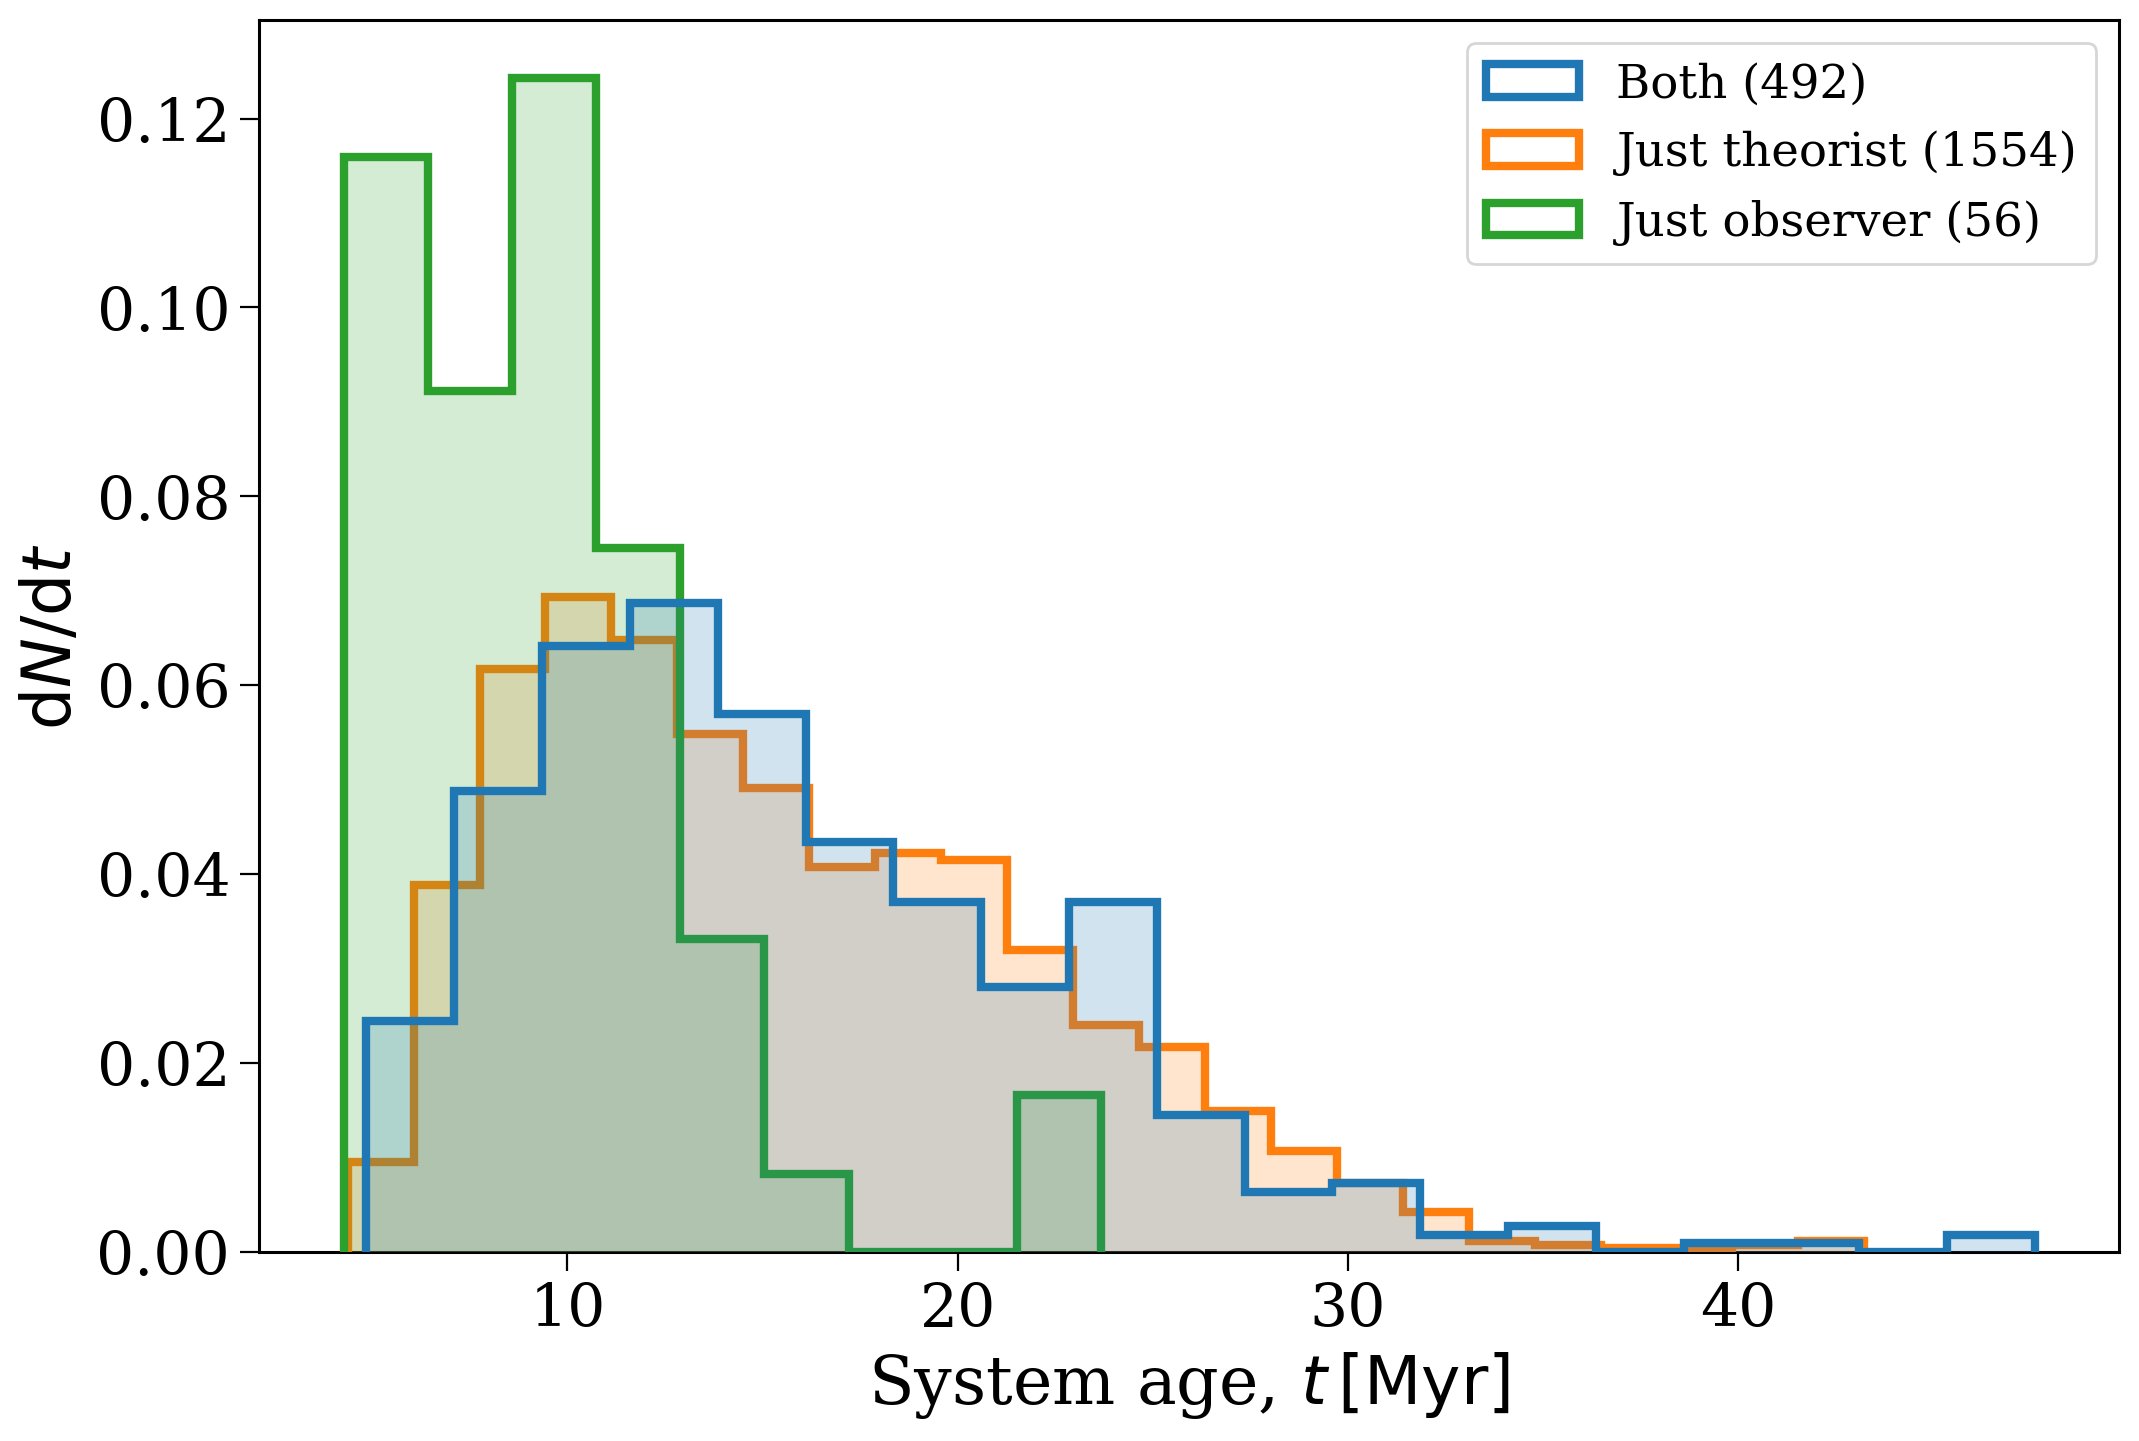

In [26]:
fig, ax = plt.subplots()

for nums, label, zorder, bins, c in zip([both_nums, just_theorist, just_obs], 
                                        [f"Both ({len(both_nums)})", f"Just theorist ({len(just_theorist)})", f"Just observer ({len(just_obs)})"],
                                        [10, 5, 5],
                                        ["fd", "fd", "fd"],
                                        ["C0", "C1", "C2"]):
    tphys = p.final_bpp.loc[nums]["tphys"].values
    ax.hist(tphys, zorder=zorder, bins=bins, alpha=0.2, density=True, color=c)
    ax.hist(tphys, histtype="step", zorder=zorder, bins=bins, density=True, color=c, lw=3, label=label)
    
ax.legend(fontsize=0.7*fs)

# ax.axvline(30, color="black", linestyle="dotted", zorder=100)

ax.set(xlabel=r"System age, $t \, [\rm Myr]$", ylabel=r"$\mathrm{d}N/\mathrm{d}t$")

plt.show()

# Runaway fractions
What fraction of O stars do runaway stars represent according to binary evolution?

In [16]:
bound = p.final_bpp["sep"] > 0.0

In [17]:
n_o_star_no_binary = ((~bound & observer_masks["o_star"][1] & observer_masks["nearby"][1]).sum()
                    + (~bound & observer_masks["o_star"][2] & observer_masks["nearby"][2]).sum()
                    + (bound & (observer_masks["o_star"][1] & observer_masks["o_star"][2] & observer_masks["nearby"][1])).sum()
                    + (bound & (observer_masks["o_star"][1] ^ observer_masks["o_star"][2] & observer_masks["nearby"][1])).sum())

In [18]:
n_o_star_total = observer_masks["o_star"][1].sum() + observer_masks["o_star"][2].sum()

In [19]:
for group, count in zip(["Theorist", "Observer"], [len(theorist_still_hot), len(observer_runaway_pop)]):
    print(f"According to the {group}")
    for total, text in zip([n_o_star_total, n_o_star_no_binary], ["counting all O stars", "counting O + O binaries as a single star"]):
        print(f"  The runaway fraction is {count / total * 100:1.1f}% when {text}")

According to the Theorist
  The runaway fraction is 1.9% when counting all O stars
  The runaway fraction is 2.5% when counting O + O binaries as a single star
According to the Observer
  The runaway fraction is 10.7% when counting all O stars
  The runaway fraction is 14.0% when counting O + O binaries as a single star


# Other nonsense

## COSMIC bug searching

In [128]:
hehg_at_mt_onset = p.bpp[(p.bpp["kstar_1"] == 8) & (p.bpp["evol_type"] == 3)]["bin_num"]
hehg_at_mt_end = p.bpp[(p.bpp["kstar_1"] == 8) & (p.bpp["evol_type"] == 4)]["bin_num"]
ce = p.bpp[p.bpp["evol_type"] == 7]["bin_num"]

In [146]:
started_mt_as_hehg = np.isin(p.bin_nums, hehg_at_mt_onset)
finished_mt_as_hehg = np.isin(p.bin_nums, hehg_at_mt_end)
experienced_ce = np.isin(p.bin_nums, ce)

In [147]:
started_mt_as_hehg.sum()

48760

In [151]:
(finished_mt_as_hehg & ~started_mt_as_hehg & experienced_ce).sum()

5072

## Mass dependent binary fractions

In [249]:
vh_bin_frac = lambda m: 0.5 + 0.25 * np.log10(m)

In [257]:
mass = np.array([0.03387365359804027, 0.0652863972800327, 0.10732527067435176, 0.2152449629076355, 0.4316820611399704, 0.8744049187657433, 1.045753040631026, 1.155061195267639, 1.9758529782002703, 3.9234492983780638, 6.386012259317638, 11.711229196523114, 29.229431744454512])
bin_frac = np.array([7.8125, 14.756944444444445, 18.40277777777778, 23.09027777777778, 29.86111111111111, 41.84027777777778, 46.701388888888886, 49.826388888888886, 67.70833333333333, 80.72916666666666, 88.71527777777777, 92.88194444444444, 95.83333333333333])

In [260]:
from scipy.interpolate import interp1d

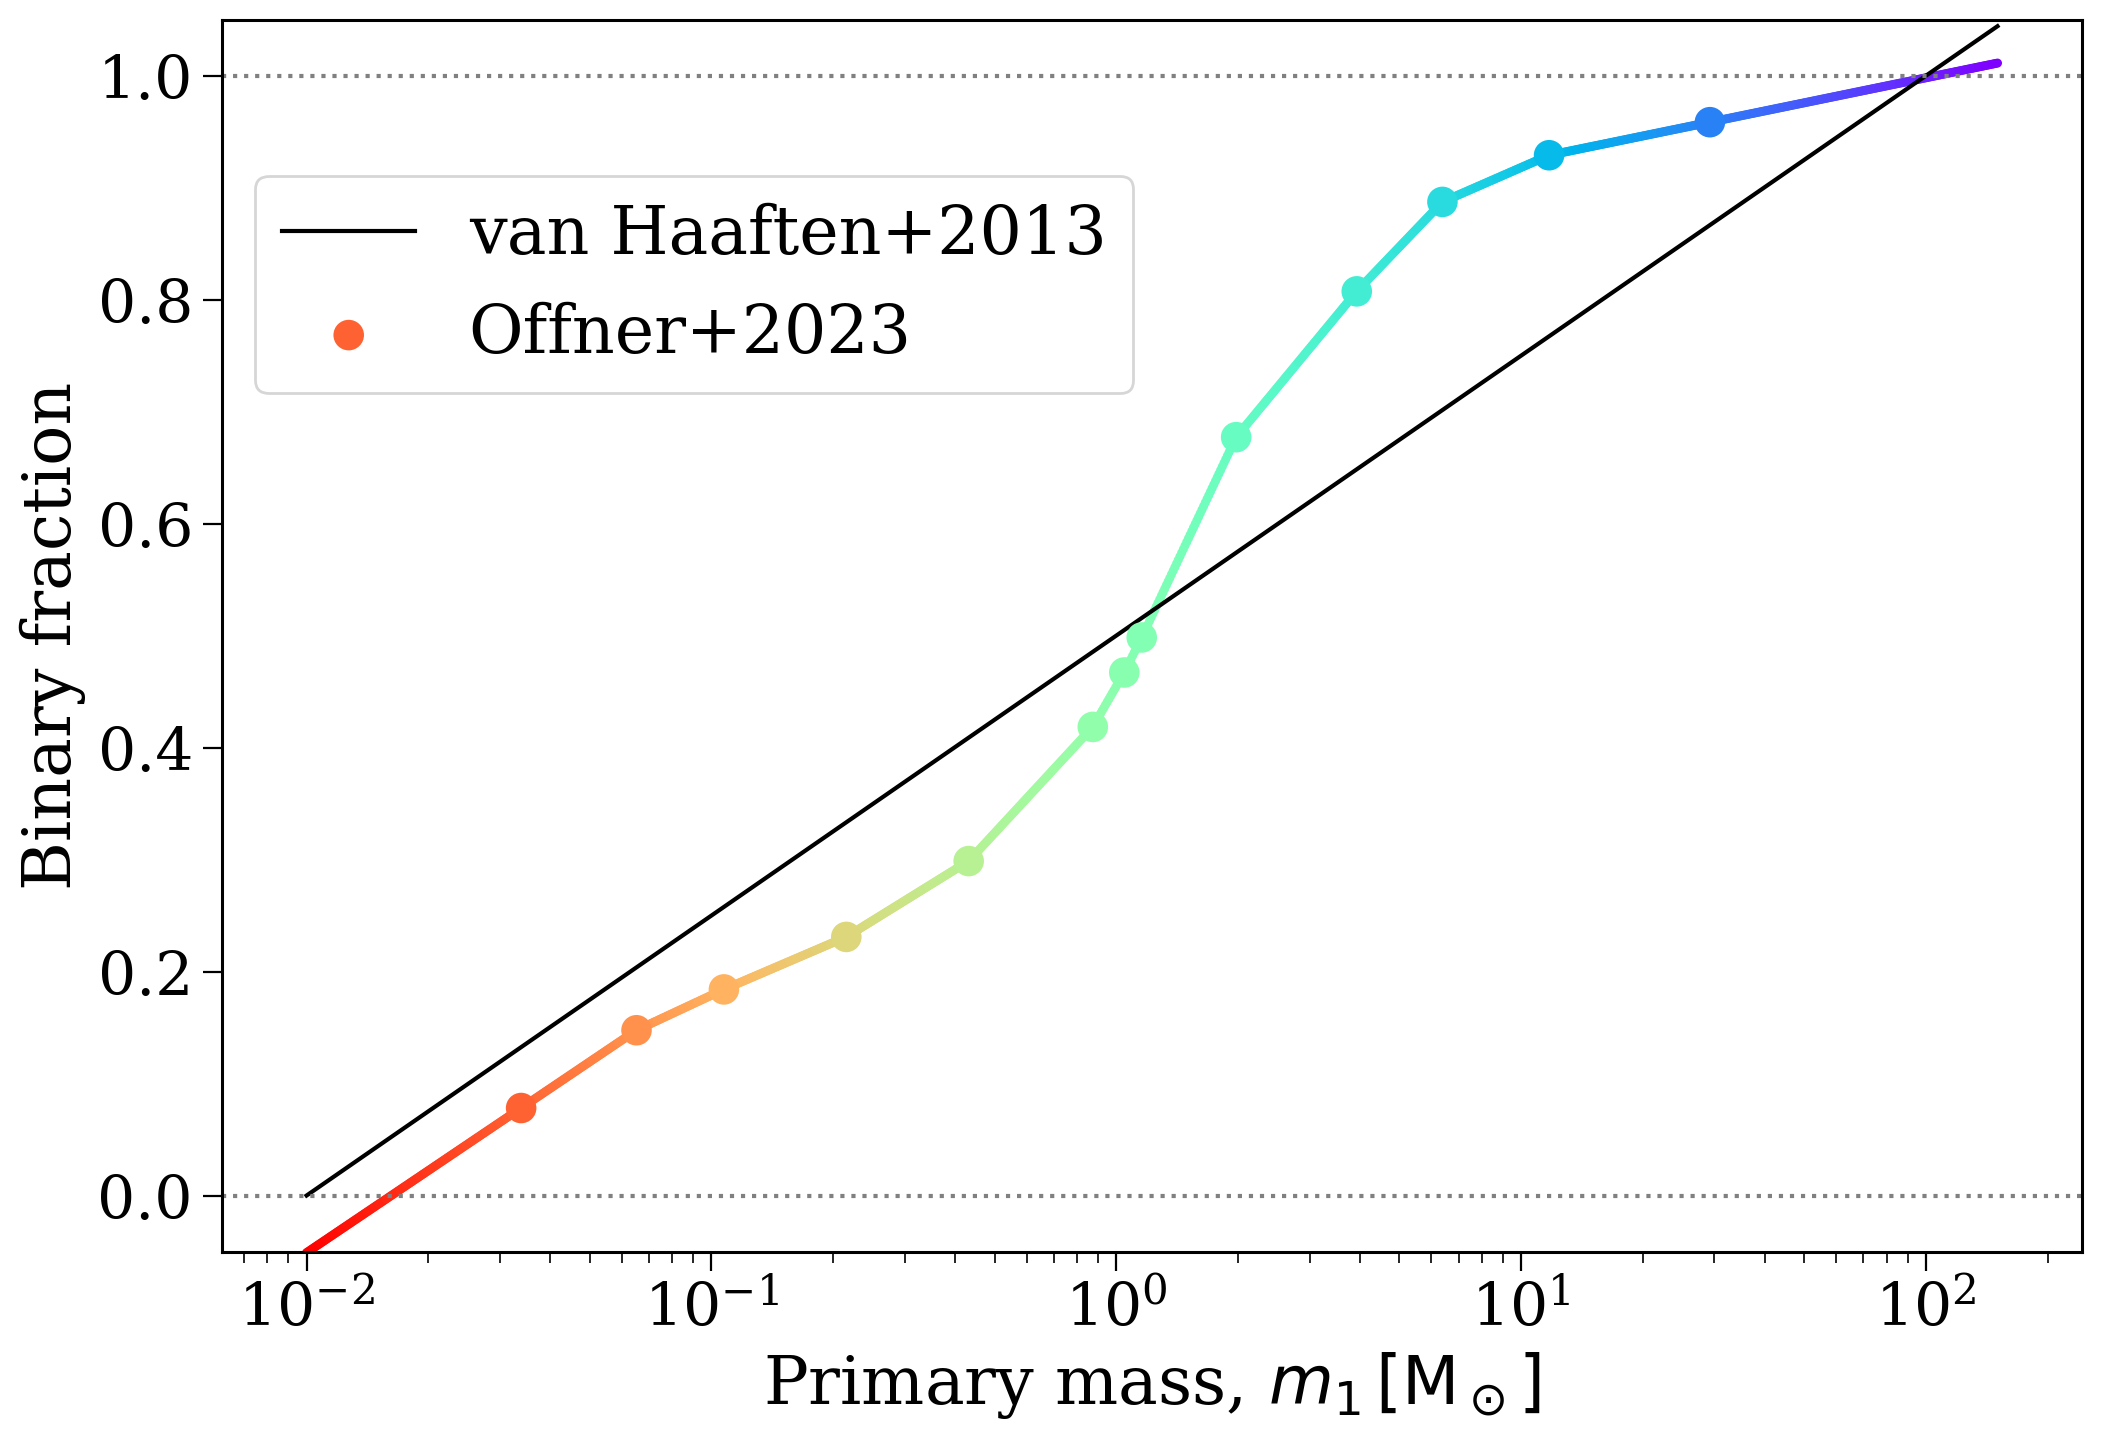

In [287]:
mass_range = np.geomspace(0.01, 150, 1000)
offner_func = interp1d(np.log10(mass), bin_frac / 100, bounds_error=False, fill_value="extrapolate")

fig, ax = plt.subplots()

ax.plot(mass_range, vh_bin_frac(mass_range), label="van Haaften+2013", color="black")
ax.scatter(mass, bin_frac / 100, c=np.log10(mass), cmap="rainbow_r", s=100, zorder=10, vmin=-2, vmax=np.log10(150), label="Offner+2023")
ax.scatter(mass_range, offner_func(np.log10(mass_range)), c=np.log10(mass_range), cmap="rainbow_r", s=5)

ax.set(xscale="log", xlabel=r"Primary mass, $m_1 \, [\rm M_\odot]$", ylabel="Binary fraction", ylim=(-0.05, 1.05))

ax.axhline(1.0, linestyle="dotted", color="grey")
ax.axhline(0.0, linestyle="dotted", color="grey")

ax.legend(loc="upper left", bbox_to_anchor=(0, 0.9))

plt.show()

# Small snapshot

In [576]:
import pynbody

In [579]:
import os

In [577]:
sim_path = "/mnt/sdceph/users/abrooks/r442.romulus25.3072g1HsbBH/r442.romulus25.3072g1HsbBH.004096/"

In [694]:
snap = pynbody.load(os.path.join(sim_path, "r442.romulus25.3072g1HsbBH.004096"))

In [695]:
h1 = snap.halos()[1]

In [594]:
h1

<SimSnap "/mnt/sdceph/users/abrooks/r442.romulus25.3072g1HsbBH/r442.romulus25.3072g1HsbBH.004096/r442.romulus25.3072g1HsbBH.004096:halo_1" len=9088044>

In [702]:
h1["iord"]

SimArray([  363071,   363959,   363960, ..., 32503221, 32503222, 32503223])

In [598]:
subsnap

<SimSnap "/mnt/sdceph/users/abrooks/r442.romulus25.3072g1HsbBH/r442.romulus25.3072g1HsbBH.004096/r442.romulus25.3072g1HsbBH.004096:halo_1:[0:9088044:1000]" len=9089>

In [703]:
subsnap = h1[::1000]
# subsnap.physical_units()
# pynbody.analysis.halo.center(subsnap, mode="ssc")

In [704]:
subsnap.write(filename="hydro_test", fmt=pynbody.tipsy.TipsySnap)

In [705]:
x = cogsworth.hydro.utils.prepare_snapshot("hydro_test")

In [706]:
pot = cogsworth.hydro.potential.get_snapshot_potential(x, verbose=True)

Computing potential for star
Computing potential for dark matter
Computing potential for gas


In [716]:
df1 = cogsworth.hydro.rewind.rewind_to_formation(x.s[0, 1, 2], pot, processes=1)
df2 = cogsworth.hydro.rewind.rewind_to_formation(x.s[0, 1, 2], pot, processes=3)


100%|██████████| 3/3 [00:00<00:00, 39.68it/s]

100%|██████████| 3/3 [00:00<00:00, 380.91it/s]


In [719]:
x["massform"]

True

In [725]:
df1

mass         Z    t_form         x         y         z  \
id                                                                     
30233027  994.1582  0.000207  0.000028  0.140852 -0.042924 -0.003562   
30234027  994.1582  0.001560  0.000029  0.044323 -0.147637  0.053602   
30235027  994.1582  0.000568  0.000034 -0.011616  0.075893  0.007917   

                v_x        v_y        v_z  
id                                         
30233027 -29.380642   8.939251   0.752831  
30234027  -9.250618  30.772614 -11.175852  
30235027   2.431683 -15.849247  -1.653091

In [724]:
(df1["x"] == df2["x"]).all()

True

In [709]:
x["r"].max()

SimArray(0.00467301, 'kpc')

# Restricted MW Model

Only keep things near the Sun

In [39]:
sfh = RecentNearSun(size=100000)

In [29]:
class RecentNearSun(cogsworth.sfh.Wagg2022):
    def __init__(self, components=["low_alpha_disc"], component_masses=[1], **kwargs):
        super().__init__(components=components, component_masses=component_masses, **kwargs)
        
    def draw_radii(self, size=None, component="low_alpha_disc"):
        if component != "low_alpha_disc":
            raise NotImplementedError()
            
        return np.random.uniform(5, 11, size) * u.kpc

    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        if component != "low_alpha_disc":
            raise NotImplementedError()

        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(200 * u.Myr / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau

In [3]:
def pR(R):
    Rd = 4
    return R/Rd**2 * np.exp(-R/Rd)

In [12]:
def fR(R):
    Rd = 4
    return 1-(R + Rd)/Rd * np.exp(-R/Rd)

In [26]:
fR(11) - fR(5)

0.4049063134102743

In [25]:
mask = (R >= 5) & (R < 11)
np.trapz(pR(R[mask]), R[mask])

0.40273661287786316

In [27]:
R = np.linspace(5, 11, 1000)
plt.plot(R, pR(R))

In [136]:
sun_loc

<Quantity [8.122, 0.   , 0.   ] kpc>

In [139]:
pot = gp.MilkyWayPotential2022()

In [140]:
import gala.dynamics as gd

In [142]:
pot.circular_velocity([8.122, 0, 0])

<Quantity [229.40403057] km / s>

In [153]:
orbit = pot.integrate_orbit(w0=gd.PhaseSpacePosition(pos=sun_loc, vel=[0, 229.40403, 0] * u.km / u.s), t1=0 * u.Myr, t2=-200 * u.Myr, dt=-1 * u.Myr)

<Quantity 217.51458783 Myr>

<Quantity 46.92285844 kpc>

In [181]:
t = np.linspace(-200, 0, 1000) * u.Myr
T = ((2 * np.pi * 8.122) * u.kpc / (229.40403 * u.km / u.s)).to(u.Myr)
theta = ((2 * np.pi * t / T) % (2 * np.pi)) * u.rad
x = 8.122 * np.cos(theta)
y = 8.122 * np.sin(theta)

In [192]:
angle = np.random.uniform(0, 2 * np.pi, 10000)
r = np.random.rand(10000)**(0.5) * 3
plt.scatter(r * np.cos(angle), r * np.sin(angle), s=1)
plt.gca().set_aspect("equal")

In [185]:
def sun_pos(t):
    sun_R = 8.122 * u.kpc
    T = ((2 * np.pi * sun_R) / (229.40403 * u.km / u.s)).to(u.Myr)
    theta = ((2 * np.pi * t / T) % (2 * np.pi)) * u.rad
    x = sun_R * np.cos(theta)
    y = sun_R * np.sin(theta)
    return x, y

In [186]:
fig, ax = plt.subplots()
ax.plot(*sun_pos(t))
orbit.plot(["x", "y"], axes=ax)

ax.set_aspect("equal")

In [341]:

from scipy.special import lambertw

In [366]:
class RecentNearSun(cogsworth.sfh.Wagg2022):
    def __init__(self, components=["low_alpha_disc"], component_masses=[1],
                 near_thresh=3 * u.kpc, **kwargs):
        self.near_thresh = near_thresh
        super().__init__(components=components, component_masses=component_masses, **kwargs)
        
    def sun_pos(self, t):
        sun_R = 8.122 * u.kpc
        sun_v = 229.40403 * u.km / u.s
        T = ((2 * np.pi * sun_R) / sun_v).to(u.Myr)
        theta = ((2 * np.pi * t / T) % (2 * np.pi)).decompose() * u.rad
        x = sun_R * np.cos(theta)
        y = sun_R * np.sin(theta)
        return x, y
        
    def draw_radii(self, tau=None, size=None):
        R_0 = 4 * u.kpc * (1 - self.alpha * (tau / (8 * u.Gyr)))
        U = np.random.rand(size)
        rho = - R_0 * (lambertw((U - 1) / np.exp(1), k=-1).real + 1)
        return rho

    def draw_lookback_times(self, size=None):
        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(200 * u.Myr / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau
    
    def sample(self):
        # create an array of which component each point belongs to
        self._which_comp = np.repeat("low_alpha_disc", self._size)

        self._tau = self.draw_lookback_times(self._size)
        sun_x, sun_y = self.sun_pos(-self._tau)
        
        rho, x, y = np.zeros(self.size) * u.kpc, np.zeros(self.size) * u.kpc, np.zeros(self.size) * u.kpc
        phi = np.zeros(self.size) * u.rad
        inds_todo = np.arange(self.size).astype(int)
        self.n_drawn = 0
        while len(inds_todo) > 0:
            rho_draw = self.draw_radii(tau=self._tau[inds_todo], size=len(inds_todo))
            phi_draw = self.draw_phi(size=len(inds_todo))
            self.n_drawn += len(inds_todo)
            
            x_draw, y_draw = rho_draw * np.cos(phi_draw), rho_draw * np.sin(phi_draw)
            
            dist_from_sun = ((sun_x[inds_todo] - x_draw)**2 + (sun_y[inds_todo] - y_draw)**2)**(.5)
            near = dist_from_sun < self.near_thresh
            
            rho[inds_todo[near]] = rho_draw[near]
            x[inds_todo[near]] = x_draw[near]
            y[inds_todo[near]] = y_draw[near]
            phi[inds_todo[near]] = phi_draw[near]
            
            inds_todo = inds_todo[~near]
    
        z = self.draw_heights(self._size)

        # shuffle the samples so components are well mixed (mostly for plotting)
        random_order = np.random.permutation(self._size)
        self._tau = self._tau[random_order]
        rho = rho[random_order]
        z = z[random_order]
        self._which_comp = self._which_comp[random_order]

        self._x = x[random_order]
        self._y = y[random_order]
        self._z = z

        # compute the metallicity given the other values
        self._Z = self.get_metallicity()
        
sfh = RecentNearSun(size=100000)

In [372]:
class RecentMW(cogsworth.sfh.Wagg2022):
    def __init__(self, components=["low_alpha_disc"], component_masses=[1], **kwargs):
        super().__init__(components=components, component_masses=component_masses, **kwargs)

    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(200 * u.Myr / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau

In [367]:
%%time
sfh = RecentNearSun(size=10_000_000)

CPU times: user 1min 26s, sys: 7.62 s, total: 1min 34s
Wall time: 1min 34s


In [371]:
sfh.size / sfh.n_drawn

0.03821580860743447

In [373]:
true_sfh = RecentMW(size=100000)

In [380]:
fig, ax = plt.subplots()

every = 100

scatter = ax.scatter(sfh.x[::every], sfh.y[::every],
                     c=sfh.tau.to(u.Myr).value[::every], s=1)
ax.scatter(true_sfh.x, true_sfh.y, c=true_sfh.tau.to(u.Myr).value, s=1, alpha=0.5, zorder=-1)
fig.colorbar(scatter, label="Lookback time")

ax.set_aspect("equal")
ax.set(xlabel=r"$x \, [\rm kpc]$", ylabel=r"$y \, [\rm kpc]$", xlim=(-20, 20), ylim=(-20, 20))

plt.show()

# Data for Machine Learning

- x
- y
- z
- vR
- vT
- vz
- sep
- kstar1
- kstar2
- class

In [58]:
o_stars = p[observer_masks["o_star"][1] | observer_masks["o_star"][2]]

In [82]:
%%time

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 173 ms


11         False
57          True
94          True
106         True
145         True
           ...  
3308693     True
3308709     True
3308816    False
3308913     True
3308935     True
Length: 43297, dtype: bool

In [80]:
5/1000*len(o_stars)

216.485

In [88]:
o_stars.disrupted.sum()

4322

In [85]:
o_stars.final_pos.shape

(47619, 3)

In [92]:
o_stars.disrupted

array([False, False,  True, ..., False,  True, False])

In [153]:
dataset = {
    "bin_num": [],
    "x": [],
    "y": [],
    "z": [],
    "vR": [],
    "vT": [],
    "vz": [],
    "sep": [],
    "kstar1": [],
    "kstar2": [],
    "is_runaway": []
}

which_o = {i:observer_masks["o_star"][i][np.isin(p.bin_nums, o_stars.bin_nums)].values for i in [1,2]}
is_runaway = np.isin(o_stars.bin_nums, theorist_still_hot)

dis_bin_nums = o_stars.bin_nums[o_stars.disrupted]

for i in range(len(o_stars)):
    bin_num = o_stars.bin_nums[i]
    bound = o_stars.final_bpp.loc[bin_num]["sep"] > 0
    if (bound & (which_o[1][i] | which_o[2][i])) | (~bound & which_o[1][i]):
        bpp_row = o_stars.final_bpp.loc[bin_num]
        dataset["bin_num"].append(bin_num)
        dataset["x"].append(o_stars.final_pos[i, 0].to(u.kpc).value)
        dataset["y"].append(o_stars.final_pos[i, 1].to(u.kpc).value)
        dataset["z"].append(o_stars.final_pos[i, 2].to(u.kpc).value)
        dataset["vR"].append(o_stars.final_vel[i, 0].to(u.km/u.s).value)
        dataset["vT"].append(o_stars.final_vel[i, 1].to(u.km/u.s).value)
        dataset["vz"].append(o_stars.final_vel[i, 2].to(u.km/u.s).value)
        dataset["sep"].append(bpp_row["sep"])
        dataset["kstar1"].append(bpp_row["kstar_1"])
        dataset["kstar2"].append(bpp_row["kstar_2"])
        dataset["is_runaway"].append(bound & which_o[2][i] & is_runaway[i])

for i in range(o_stars.disrupted.sum()):
    bin_num = dis_bin_nums[i]
    bin_ind = np.where(o_stars.bin_nums == bin_num)[0][0]
    if which_o[2][bin_ind]:
        bpp_row = o_stars.final_bpp.loc[bin_num]
        dataset["bin_num"].append(bin_num)
        dataset["x"].append(o_stars.final_pos[i + len(o_stars), 0].to(u.kpc).value)
        dataset["y"].append(o_stars.final_pos[i + len(o_stars), 1].to(u.kpc).value)
        dataset["z"].append(o_stars.final_pos[i + len(o_stars), 2].to(u.kpc).value)
        dataset["vR"].append(o_stars.final_vel[i + len(o_stars), 0].to(u.km/u.s).value)
        dataset["vT"].append(o_stars.final_vel[i + len(o_stars), 1].to(u.km/u.s).value)
        dataset["vz"].append(o_stars.final_vel[i + len(o_stars), 2].to(u.km/u.s).value)
        dataset["sep"].append(bpp_row["sep"])
        dataset["kstar1"].append(bpp_row["kstar_1"])
        dataset["kstar2"].append(bpp_row["kstar_2"])
        dataset["is_runaway"].append(is_runaway[bin_ind])

# for i in range(len(o_stars.final_pos)):

#     print(full_bin_nums[i])
    

# for bin_ind, bin_num in enumerate(o_stars.bin_nums):
#     for i in [1, 2]:
#         if which_o[i].iloc[bin_ind]:
#             if i == 1 or o_stars.final_bpp.loc[bin_num]["sep"] >= 0:
#                 dataset["x"].append(o_stars.final_pos[bin_ind, 0].to(u.kpc).value)
#             else:
#                 dataset["x"].append(o_stars.final_pos[bin_ind + len(o_stars), 0].to(u.kpc).value)

In [160]:
df = pd.DataFrame(dataset)
df.set_index("bin_num", inplace=True)

In [162]:
df.to_hdf("ml_runaways.h5", key="df")